# Quickstart Example of Advanced Off-Policy Evaluation and Selection (Discrete)
This notebook provides an example of conducting advanced **Off-policy Evaluation (OPE) and Off-Policy Selection OPS)** with a synthetic Real-Time Bidding (RTB) dataset.

This example consists of the following 3 steps: 
1. Setup, Synthetic Data Generation, and Offline Policy Learning
2. Various Off-Policy Evaluation (Policy Value Estimate, Cumulative Distribution Function Estimate)
3. Off-Policy Selection

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations of offline rl policies and model-based evaluation.  
\* Also, our implementations of OPE are highly inspired by [Open Bandit Pipeline](https://github.com/st-tech/zr-obp).

In [1]:
# delete later
%load_ext autoreload
%autoreload 2

In [2]:
# delete later
import warnings
warnings.simplefilter('ignore')

In [3]:
# delete later
import sys
sys.path.append('../')
sys.path.append('../../')

In [4]:
# import OFRL modules
import ofrl
from rtbgym import RTBEnv, CustomizedRTBEnv
from ofrl.dataset import SyntheticDataset
from ofrl.policy import OnlineHead, ContinuousEvalHead
from ofrl.policy import ContinuousTruncatedGaussianHead as TruncatedGaussianHead
from ofrl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)
from ofrl.utils import MinMaxScaler, MinMaxActionScaler

# import d3rlpy algorithms
from d3rlpy.algos import RandomPolicy
# from d3rlpy.preprocessing import MinMaxScaler, MinMaxActionScaler
from ofrl.utils import MinMaxScaler, MinMaxActionScaler

# import from other libraries
import gym
import torch
from sklearn.model_selection import train_test_split

In [5]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [6]:
# version
print(ofrl.__version__)

0.0.0


In [7]:
# set random state
random_state = 12345

In [8]:
# log directory
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

## 1. Setup, Synthetic Data Generation, and Offline Policy Learning
To begin with, we briefly describe how the RTB environment works.

#### RL setup for RTB
In RTB, the objective of the RL agent is to maximize some KPIs (number of clicks or conversions) within an episode under given budget constraints.  

We often try to achieve this by adjusting bidding price function parameter $\alpha$. By using $\alpha$, we can adjust the bid price as follows.  
$bid_{t,i} = \alpha \cdot r^{\ast}$, 
where $r^{\ast}$ denotes a predicted or expected reward (KPIs).

We often formulate this RTB problem as the following Constrained Markov Decision Process (CMDP):
- `timestep`: One episode (a day or a week) consists of several timesteps (24 hours or seven days, for instance).
- `state`: We observe some feedback from the environment at each timestep, which includes the following.
  - timestep
  - remaining budget
  - impression level features (budget consumption rate, cost per mille of impressions, auction winning rate, reward) at the previous timestep
  - adjust rate (RL agent's decision making) at the previous timestep
- `action`: Agent chooses adjust rate parameter $\alpha$ to maximize KPIs.
- `reward`: Total number of clicks or conversions obtained during the timestep.
- `constraints`: The pre-determined episodic budget should not be exceeded.

For more about the environmental configuration and its customization, please refer to [examples/quickstart/rtb_synthetic_customize_env.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_customize_env.ipynb).

In [9]:
# standardized environment for discrete action
env = gym.make("RTBEnv-continuous-v0")

In [10]:
# for api compatibility to d3rlpy
from ofrl.utils import OldGymAPIWrapper
env_ = OldGymAPIWrapper(env)

#### Synthetic Data Generation
Next, we collect logged data with the uniform random agent.

`SyntheticDataset` has the following arguments:
- `env`: RTB environment for RL defined in the previous section.
- `behavior_policy`: RL agent (or algorithm) used for the data collection.
- `maximum_step_per_episode`: Maximum number of timesteps in an episode.
- `action_meaning`: Dictionary which maps discrete action index into specific actions.
- `action_keys`: Name of the action variable at each dimension.
- `state_keys`: Name of the state variable at each dimension.
- `info_keys`: Dictionary containing of key and the type of info components.
- `random_state`: Random state.

For more about the data collection and visualization, please refer to [examples/quickstart/rtb_synthetic_data_collection.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_data_collection.ipynb).

In [11]:
# behavior policy
from d3rlpy.algos import SAC
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer

# model
sac = SAC(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,   # 0.1
        maximum=env_.action_space.high,  # 10
    ),
)
# setup replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env_,
)

In [12]:
# start training
# skip if there is a pre-trained model
sac.fit_online(
    env_,
    buffer,
    eval_env=env_,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)

2022-11-24 04:09.24 [info     ] Directory is created at d3rlpy_logs/DoubleDQN_online_20221124040924
2022-11-24 04:09.24 [debug    ] Building model...
2022-11-24 04:09.24 [debug    ] Model has been built.
2022-11-24 04:09.24 [info     ] Parameters are saved to d3rlpy_logs/DoubleDQN_online_20221124040924/params.json params={'action_scaler': None, 'batch_size': 32, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 6.25e-05, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None, 'scaler': None, 'target_update_interval': 100, 'use_gpu': None, 'algorithm': 'DoubleDQN', 'observation_shape': (7,), 'action_s

  0%|          | 0/100000 [00:00<?, ?it/s]

2022-11-24 04:09.26 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20221124040924/model_1000.pt
2022-11-24 04:09.26 [info     ] DoubleDQN_online_20221124040924: epoch=1 step=1000 epoch=1 metrics={'time_inference': 0.0006391119956970215, 'time_environment_step': 0.0011666758060455322, 'time_step': 0.0018793754577636718, 'rollout_return': 14.028169014084508, 'evaluation': 14.3} step=1000
2022-11-24 04:09.34 [info     ] Model parameters are saved to d3rlpy_logs/DoubleDQN_online_20221124040924/model_2000.pt
2022-11-24 04:09.34 [info     ] DoubleDQN_online_20221124040924: epoch=2 step=2000 epoch=2 metrics={'time_inference': 0.0006009256839752198, 'time_environment_step': 0.0012014827728271484, 'time_sample_batch': 0.00016651487350463867, 'time_algorithm_update': 0.006054023504257202, 'loss': 51.65224489116669, 'time_step': 0.008141992568969726, 'rollout_return': 11.330985915492958, 'evaluation': 6.2} step=2000
2022-11-24 04:09.39 [info     ] Model parameters are save

In [ ]:
# save model
sac.save_model("d3rlpy_logs/sac.pt")

In [12]:
# reload model
sac.build_with_env(env_)
sac.load_model("d3rlpy_logs/sac.pt")

In [13]:
behavior_policy = TruncatedGaussianHead(
    sac, 
    minimum=env.action_space.low,
    maximum=env.action_space.high,
    sigma=np.array([1.0]),
    name="sac_sigma_1.0",
    random_state=random_state,
)

In [14]:
# initialize dataset class
dataset = SyntheticDataset(
    env=env,
    behavior_policy=behavior_policy,
    state_keys=env.obs_keys,
    max_episode_steps=env.step_per_episode,
    info_keys={
        "search_volume": int,
        "impression": int,
        "click": int,
        "conversion": int,
        "average_bid_price": float,
    },
    random_state=random_state,
)

In [15]:
# collect logged data by a behavior policy
# skip if there is a preserved logged dataset
logged_dataset = dataset.obtain_episodes(n_datasets=10, n_trajectories=10000, obtain_info=True)

[obtain_datasets]:   0%|          | 0/10 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

In [16]:
with open("logs/dataset_continuous_sac_10.pkl", "wb") as f:
    pickle.dump(logged_dataset, f)

In [15]:
with open("logs/dataset_continuous_sac_10.pkl", "rb") as f:
    logged_dataset = pickle.load(f)

#### Offline Policy Learning
Here, we learn several "candidate" policies to be evaluated and selected using [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementation.

For more about the offline RL procedure, please refer to [examples/quickstart/rtb_synthetic_discrete_basic.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_discrete_basic.ipynb).

In [16]:
# import modules
from ofrl.policy.opl import OffPolicyLearning
# import models from d3rlpy
from d3rlpy.algos import CQL, IQL

In [17]:
# evaluation policies
cql_b1 = CQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)
cql_b2 = CQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)
cql_b3 = CQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)
iql_b1 = IQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)
iql_b2 = IQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[100]),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)
iql_b3 = IQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[50, 10]),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env_.action_space.low,  # minimum value that policy can take
        maximum=env_.action_space.high,  # maximum value that policy can take
    )
)

algorithms = [cql_b1, cql_b2, cql_b3, iql_b1, iql_b2, iql_b3]
algorithms_name = ["cql_b1", "cql_b2", "cql_b3", "iql_b1", "iql_b2", "iql_b3"]

In [18]:
# initialize OPL class
opl = OffPolicyLearning(
    fitting_args={
        "n_steps": 10000,
        "scorers": {},
    }
)

In [21]:
# obtain base policies
base_policies = opl.learn_base_policy(
    logged_dataset=logged_dataset,
    algorithms=algorithms,
    random_state=random_state,
)

[learn_policies: logged_datasets]:   0%|          | 0/10 [00:00<?, ?it/s]

[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-01-07 21:33.29 [debug    ] RandomIterator is selected.
2023-01-07 21:33.29 [info     ] Directory is created at d3rlpy_logs/CQL_20230107213329
2023-01-07 21:33.29 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 21:33.29 [debug    ] Building models...
2023-01-07 21:33.29 [debug    ] Models have been built.
2023-01-07 21:33.29 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230107213329/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0,

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 21:38.54 [info     ] CQL_20230107213329: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0012720966815948486, 'time_algorithm_update': 0.030037991642951966, 'temp_loss': -5.207949037623406, 'temp': 1.3282120247602462, 'alpha_loss': -15.226559216737748, 'alpha': 1.7848864259123802, 'critic_loss': 132.30502085180282, 'actor_loss': 4.516796696877852, 'time_step': 0.032203477764129636} step=10000
2023-01-07 21:38.54 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230107213329/model_10000.pt
2023-01-07 21:38.54 [debug    ] RandomIterator is selected.
2023-01-07 21:38.54 [info     ] Directory is created at d3rlpy_logs/CQL_20230107213854
2023-01-07 21:38.54 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 21:38.54 [debug    ] Building models...
2023-01-07 21:38.54 [debug    ] Models have been built.
2023-01-07 21:38.54 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230107213854/params.json params={'action_scaler': {'type': 'm

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 21:44.07 [info     ] CQL_20230107213854: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0013167466163635255, 'time_algorithm_update': 0.028806407356262206, 'temp_loss': -19.205616883945464, 'temp': 1.2417442570090294, 'alpha_loss': -7.518398852944374, 'alpha': 1.7124596183657645, 'critic_loss': 1281.316628704214, 'actor_loss': 32.03617615065575, 'time_step': 0.031010544061660768} step=10000
2023-01-07 21:44.07 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230107213854/model_10000.pt
2023-01-07 21:44.08 [debug    ] RandomIterator is selected.
2023-01-07 21:44.08 [info     ] Directory is created at d3rlpy_logs/CQL_20230107214408
2023-01-07 21:44.08 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 21:44.08 [debug    ] Building models...
2023-01-07 21:44.08 [debug    ] Models have been built.
2023-01-07 21:44.08 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230107214408/params.json params={'action_scaler': {'type': 'mi

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 21:49.21 [info     ] CQL_20230107214408: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0013046270608901977, 'time_algorithm_update': 0.028855143880844116, 'temp_loss': -5.172176461446285, 'temp': 1.3280733067393302, 'alpha_loss': -15.067401865577697, 'alpha': 1.782208565199375, 'critic_loss': 140.83352744045257, 'actor_loss': 10.66407607959509, 'time_step': 0.031045144820213318} step=10000
2023-01-07 21:49.21 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230107214408/model_10000.pt
2023-01-07 21:49.21 [debug    ] RandomIterator is selected.
2023-01-07 21:49.21 [info     ] Directory is created at d3rlpy_logs/IQL_20230107214921
2023-01-07 21:49.21 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 21:49.21 [debug    ] Building models...
2023-01-07 21:49.21 [debug    ] Models have been built.
2023-01-07 21:49.21 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230107214921/params.json params={'action_scaler': {'type': 'mi

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 21:51.35 [info     ] IQL_20230107214921: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0013607672691345214, 'time_algorithm_update': 0.011273246669769288, 'critic_loss': 227.49883086509703, 'value_loss': 9.600735846313112, 'actor_loss': 4.941364627585281, 'time_step': 0.013230511116981506} step=10000
2023-01-07 21:51.35 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230107214921/model_10000.pt
2023-01-07 21:51.35 [debug    ] RandomIterator is selected.
2023-01-07 21:51.35 [info     ] Directory is created at d3rlpy_logs/IQL_20230107215135
2023-01-07 21:51.35 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 21:51.35 [debug    ] Building models...
2023-01-07 21:51.35 [debug    ] Models have been built.
2023-01-07 21:51.35 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230107215135/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_facto

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 21:53.05 [info     ] IQL_20230107215135: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0010963359594345092, 'time_algorithm_update': 0.00728003466129303, 'critic_loss': 6725.112760241365, 'value_loss': 55.38037307239463, 'actor_loss': 14.599148408237175, 'time_step': 0.00885740990638733} step=10000
2023-01-07 21:53.05 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230107215135/model_10000.pt
2023-01-07 21:53.05 [debug    ] RandomIterator is selected.
2023-01-07 21:53.05 [info     ] Directory is created at d3rlpy_logs/IQL_20230107215305
2023-01-07 21:53.05 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 21:53.05 [debug    ] Building models...
2023-01-07 21:53.05 [debug    ] Models have been built.
2023-01-07 21:53.05 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230107215305/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 21:54.21 [info     ] IQL_20230107215305: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008772263765335083, 'time_algorithm_update': 0.006215046882629394, 'critic_loss': 218.84171694076062, 'value_loss': 10.373057059387584, 'actor_loss': 7.704384132945532, 'time_step': 0.0075158244371414185} step=10000
2023-01-07 21:54.21 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230107215305/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-01-07 21:54.21 [debug    ] RandomIterator is selected.
2023-01-07 21:54.21 [info     ] Directory is created at d3rlpy_logs/CQL_20230107215421
2023-01-07 21:54.21 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 21:54.21 [warning  ] Skip building models since they're already built.
2023-01-07 21:54.21 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230107215421/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alph

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 21:57.50 [info     ] CQL_20230107215421: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0009426074981689453, 'time_algorithm_update': 0.01908661587238312, 'temp_loss': -12.281483893394471, 'temp': 3.7164652069807054, 'alpha_loss': -25.00566524925232, 'alpha': 5.082980050110817, 'critic_loss': 35.63135879974365, 'actor_loss': 16.320214840745926, 'time_step': 0.020687044525146484} step=10000
2023-01-07 21:57.50 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230107215421/model_10000.pt
2023-01-07 21:57.50 [debug    ] RandomIterator is selected.
2023-01-07 21:57.50 [info     ] Directory is created at d3rlpy_logs/CQL_20230107215750
2023-01-07 21:57.50 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 21:57.50 [warning  ] Skip building models since they're already built.
2023-01-07 21:57.50 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230107215750/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimu

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 22:01.35 [info     ] CQL_20230107215750: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0010109105587005616, 'time_algorithm_update': 0.020520721077919007, 'temp_loss': -15.214240002322198, 'temp': 3.037416278743744, 'alpha_loss': -18.485904500424862, 'alpha': 4.811040880107879, 'critic_loss': 40.32463414669037, 'actor_loss': 18.23725888171196, 'time_step': 0.022240798711776734} step=10000
2023-01-07 22:01.35 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230107215750/model_10000.pt
2023-01-07 22:01.35 [debug    ] RandomIterator is selected.
2023-01-07 22:01.35 [info     ] Directory is created at d3rlpy_logs/CQL_20230107220135
2023-01-07 22:01.35 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 22:01.35 [warning  ] Skip building models since they're already built.
2023-01-07 22:01.35 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230107220135/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimu

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 22:06.22 [info     ] CQL_20230107220135: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.001240524697303772, 'time_algorithm_update': 0.026377616357803346, 'temp_loss': -12.23614894862175, 'temp': 3.718347655701637, 'alpha_loss': -26.928755519485474, 'alpha': 5.1086661773204805, 'critic_loss': 41.41470036411285, 'actor_loss': 18.02799809303284, 'time_step': 0.028415234422683715} step=10000
2023-01-07 22:06.22 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230107220135/model_10000.pt
2023-01-07 22:06.22 [debug    ] RandomIterator is selected.
2023-01-07 22:06.22 [info     ] Directory is created at d3rlpy_logs/IQL_20230107220622
2023-01-07 22:06.22 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 22:06.22 [warning  ] Skip building models since they're already built.
2023-01-07 22:06.22 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230107220622/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 22:08.07 [info     ] IQL_20230107220622: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0012193557500839232, 'time_algorithm_update': 0.008641308546066285, 'critic_loss': 8.484374568796158, 'value_loss': 0.7476747290392174, 'actor_loss': 5.056998817054555, 'time_step': 0.010385250186920165} step=10000
2023-01-07 22:08.07 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230107220622/model_10000.pt
2023-01-07 22:08.07 [debug    ] RandomIterator is selected.
2023-01-07 22:08.07 [info     ] Directory is created at d3rlpy_logs/IQL_20230107220807
2023-01-07 22:08.07 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 22:08.07 [warning  ] Skip building models since they're already built.
2023-01-07 22:08.07 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230107220807/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 22:09.39 [info     ] IQL_20230107220807: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0011765750885009765, 'time_algorithm_update': 0.0074402871131896975, 'critic_loss': 25.968582496786116, 'value_loss': 3.513539842694253, 'actor_loss': 5.460370038074348, 'time_step': 0.009130521249771118} step=10000
2023-01-07 22:09.39 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230107220807/model_10000.pt
2023-01-07 22:09.39 [debug    ] RandomIterator is selected.
2023-01-07 22:09.39 [info     ] Directory is created at d3rlpy_logs/IQL_20230107220939
2023-01-07 22:09.39 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 22:09.39 [warning  ] Skip building models since they're already built.
2023-01-07 22:09.39 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230107220939/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 22:11.19 [info     ] IQL_20230107220939: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.001185467529296875, 'time_algorithm_update': 0.00814941918849945, 'critic_loss': 15.741627531027794, 'value_loss': 2.2239058935763896, 'actor_loss': 0.3039389734465745, 'time_step': 0.009841765880584717} step=10000
2023-01-07 22:11.19 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230107220939/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-01-07 22:11.19 [debug    ] RandomIterator is selected.
2023-01-07 22:11.19 [info     ] Directory is created at d3rlpy_logs/CQL_20230107221119
2023-01-07 22:11.19 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 22:11.19 [warning  ] Skip building models since they're already built.
2023-01-07 22:11.19 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230107221119/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alph

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 22:16.02 [info     ] CQL_20230107221119: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0012536833047866822, 'time_algorithm_update': 0.025925694012641907, 'temp_loss': -36.216369997501374, 'temp': 11.05771773200035, 'alpha_loss': -61.15901229934693, 'alpha': 14.977615463066101, 'critic_loss': 85.57215203361511, 'actor_loss': 51.802026214790345, 'time_step': 0.028018475127220152} step=10000
2023-01-07 22:16.02 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230107221119/model_10000.pt
2023-01-07 22:16.03 [debug    ] RandomIterator is selected.
2023-01-07 22:16.03 [info     ] Directory is created at d3rlpy_logs/CQL_20230107221603
2023-01-07 22:16.03 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 22:16.03 [warning  ] Skip building models since they're already built.
2023-01-07 22:16.03 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230107221603/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minim

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 22:19.44 [info     ] CQL_20230107221603: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.001022088074684143, 'time_algorithm_update': 0.020130474448204042, 'temp_loss': -29.188395731306077, 'temp': 8.581707279014587, 'alpha_loss': -60.78041779575348, 'alpha': 14.58936827325821, 'critic_loss': 98.94795267124177, 'actor_loss': 42.069009125614166, 'time_step': 0.021901605105400086} step=10000
2023-01-07 22:19.44 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230107221603/model_10000.pt
2023-01-07 22:19.44 [debug    ] RandomIterator is selected.
2023-01-07 22:19.44 [info     ] Directory is created at d3rlpy_logs/CQL_20230107221944
2023-01-07 22:19.44 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 22:19.44 [warning  ] Skip building models since they're already built.
2023-01-07 22:19.44 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230107221944/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 22:23.24 [info     ] CQL_20230107221944: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0009920868635177613, 'time_algorithm_update': 0.020155932688713074, 'temp_loss': -36.04511192407608, 'temp': 11.064958774375915, 'alpha_loss': -74.08685930175781, 'alpha': 15.229450662326812, 'critic_loss': 94.5281762298584, 'actor_loss': 53.023546654701235, 'time_step': 0.021874086856842043} step=10000
2023-01-07 22:23.24 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230107221944/model_10000.pt
2023-01-07 22:23.25 [debug    ] RandomIterator is selected.
2023-01-07 22:23.25 [info     ] Directory is created at d3rlpy_logs/IQL_20230107222325
2023-01-07 22:23.25 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 22:23.25 [warning  ] Skip building models since they're already built.
2023-01-07 22:23.25 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230107222325/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimu

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 22:24.58 [info     ] IQL_20230107222325: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0010570921897888183, 'time_algorithm_update': 0.007693780636787414, 'critic_loss': 5.374661225676537, 'value_loss': 0.18294461419354194, 'actor_loss': 1.681565768934507, 'time_step': 0.009243152332305908} step=10000
2023-01-07 22:24.58 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230107222325/model_10000.pt
2023-01-07 22:24.58 [debug    ] RandomIterator is selected.
2023-01-07 22:24.58 [info     ] Directory is created at d3rlpy_logs/IQL_20230107222458
2023-01-07 22:24.58 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 22:24.58 [warning  ] Skip building models since they're already built.
2023-01-07 22:24.58 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230107222458/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 22:26.23 [info     ] IQL_20230107222458: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.001036657738685608, 'time_algorithm_update': 0.006819570732116699, 'critic_loss': 12.245175030851364, 'value_loss': 0.8482434410297545, 'actor_loss': 2.067314749796083, 'time_step': 0.008340688610076905} step=10000
2023-01-07 22:26.23 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230107222458/model_10000.pt
2023-01-07 22:26.23 [debug    ] RandomIterator is selected.
2023-01-07 22:26.23 [info     ] Directory is created at d3rlpy_logs/IQL_20230107222623
2023-01-07 22:26.23 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 22:26.23 [warning  ] Skip building models since they're already built.
2023-01-07 22:26.23 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230107222623/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 22:27.56 [info     ] IQL_20230107222623: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0010354602098464965, 'time_algorithm_update': 0.007694232988357544, 'critic_loss': 8.364323008215427, 'value_loss': 0.6649260821144679, 'actor_loss': 0.1883046696581063, 'time_step': 0.009229474711418151} step=10000
2023-01-07 22:27.56 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230107222623/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-01-07 22:27.56 [debug    ] RandomIterator is selected.
2023-01-07 22:27.56 [info     ] Directory is created at d3rlpy_logs/CQL_20230107222756
2023-01-07 22:27.56 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 22:27.56 [warning  ] Skip building models since they're already built.
2023-01-07 22:27.56 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230107222756/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alph

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 22:31.42 [info     ] CQL_20230107222756: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0010011778593063355, 'time_algorithm_update': 0.020670304036140442, 'temp_loss': -108.78030517501831, 'temp': 32.95170731830597, 'alpha_loss': -177.4907532409668, 'alpha': 44.88901123867035, 'critic_loss': 213.43398460769654, 'actor_loss': 149.33357943153382, 'time_step': 0.022357974886894227} step=10000
2023-01-07 22:31.42 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230107222756/model_10000.pt
2023-01-07 22:31.42 [debug    ] RandomIterator is selected.
2023-01-07 22:31.42 [info     ] Directory is created at d3rlpy_logs/CQL_20230107223142
2023-01-07 22:31.42 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 22:31.42 [warning  ] Skip building models since they're already built.
2023-01-07 22:31.42 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230107223142/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minim

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 22:35.35 [info     ] CQL_20230107223142: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0010575031042098998, 'time_algorithm_update': 0.021262160158157347, 'temp_loss': -86.86985906095505, 'temp': 25.498335134983062, 'alpha_loss': -174.51400126032829, 'alpha': 43.66452943534851, 'critic_loss': 221.05175322036743, 'actor_loss': 119.72454168205262, 'time_step': 0.02305130500793457} step=10000
2023-01-07 22:35.35 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230107223142/model_10000.pt
2023-01-07 22:35.35 [debug    ] RandomIterator is selected.
2023-01-07 22:35.35 [info     ] Directory is created at d3rlpy_logs/CQL_20230107223535
2023-01-07 22:35.35 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 22:35.35 [warning  ] Skip building models since they're already built.
2023-01-07 22:35.35 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230107223535/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minim

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 22:39.12 [info     ] CQL_20230107223535: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0009728794336318969, 'time_algorithm_update': 0.01988747835159302, 'temp_loss': -107.79852034320831, 'temp': 32.967010648918155, 'alpha_loss': -202.84013272323608, 'alpha': 45.512245571136475, 'critic_loss': 228.6274354499817, 'actor_loss': 149.23061763534545, 'time_step': 0.021520415139198303} step=10000
2023-01-07 22:39.12 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230107223535/model_10000.pt
2023-01-07 22:39.12 [debug    ] RandomIterator is selected.
2023-01-07 22:39.12 [info     ] Directory is created at d3rlpy_logs/IQL_20230107223912
2023-01-07 22:39.12 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 22:39.12 [warning  ] Skip building models since they're already built.
2023-01-07 22:39.12 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230107223912/params.json params={'action_scaler': {'type': 'min_max', 'params': {'mini

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 22:40.33 [info     ] IQL_20230107223912: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0009044501781463624, 'time_algorithm_update': 0.006704874062538147, 'critic_loss': 4.287244442605973, 'value_loss': 0.03933570506708347, 'actor_loss': 0.11767255313849892, 'time_step': 0.008028856778144836} step=10000
2023-01-07 22:40.33 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230107223912/model_10000.pt
2023-01-07 22:40.33 [debug    ] RandomIterator is selected.
2023-01-07 22:40.33 [info     ] Directory is created at d3rlpy_logs/IQL_20230107224033
2023-01-07 22:40.33 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 22:40.33 [warning  ] Skip building models since they're already built.
2023-01-07 22:40.33 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230107224033/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector'

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 22:41.52 [info     ] IQL_20230107224033: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0009487458944320679, 'time_algorithm_update': 0.006357511854171753, 'critic_loss': 8.422061061263085, 'value_loss': 0.22478350247987547, 'actor_loss': 0.18177891455641365, 'time_step': 0.0077530486345291135} step=10000
2023-01-07 22:41.52 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230107224033/model_10000.pt
2023-01-07 22:41.52 [debug    ] RandomIterator is selected.
2023-01-07 22:41.52 [info     ] Directory is created at d3rlpy_logs/IQL_20230107224152
2023-01-07 22:41.52 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 22:41.52 [warning  ] Skip building models since they're already built.
2023-01-07 22:41.52 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230107224152/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 22:43.13 [info     ] IQL_20230107224152: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0009132177114486694, 'time_algorithm_update': 0.006681455826759338, 'critic_loss': 5.147773799359799, 'value_loss': 0.11102304255065974, 'actor_loss': 0.11701682124005747, 'time_step': 0.00801610586643219} step=10000
2023-01-07 22:43.13 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230107224152/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-01-07 22:43.13 [debug    ] RandomIterator is selected.
2023-01-07 22:43.13 [info     ] Directory is created at d3rlpy_logs/CQL_20230107224313
2023-01-07 22:43.13 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 22:43.13 [warning  ] Skip building models since they're already built.
2023-01-07 22:43.13 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230107224313/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alph

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 22:46.42 [info     ] CQL_20230107224313: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0009548419952392578, 'time_algorithm_update': 0.019072669672966003, 'temp_loss': -319.145190927887, 'temp': 98.0039730682373, 'alpha_loss': -515.24461771698, 'alpha': 134.5202627418518, 'critic_loss': 558.4175617858887, 'actor_loss': 427.781537159729, 'time_step': 0.02067190752029419} step=10000
2023-01-07 22:46.42 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230107224313/model_10000.pt
2023-01-07 22:46.42 [debug    ] RandomIterator is selected.
2023-01-07 22:46.42 [info     ] Directory is created at d3rlpy_logs/CQL_20230107224642
2023-01-07 22:46.42 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 22:46.42 [warning  ] Skip building models since they're already built.
2023-01-07 22:46.42 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230107224642/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': arra

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 22:50.15 [info     ] CQL_20230107224642: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.001006455945968628, 'time_algorithm_update': 0.019471764993667602, 'temp_loss': -109.05262992578149, 'temp': 67.86283705406188, 'alpha_loss': -463.26511739047766, 'alpha': 129.1616460823059, 'critic_loss': 515.193311477375, 'actor_loss': 188.22966358951928, 'time_step': 0.021145607304573058} step=10000
2023-01-07 22:50.15 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230107224642/model_10000.pt
2023-01-07 22:50.15 [debug    ] RandomIterator is selected.
2023-01-07 22:50.15 [info     ] Directory is created at d3rlpy_logs/CQL_20230107225015
2023-01-07 22:50.15 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 22:50.15 [warning  ] Skip building models since they're already built.
2023-01-07 22:50.15 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230107225015/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 22:53.40 [info     ] CQL_20230107225015: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0009370301723480225, 'time_algorithm_update': 0.018744474172592163, 'temp_loss': -316.70550579833986, 'temp': 98.04681311607361, 'alpha_loss': -519.0725201217651, 'alpha': 134.60031544799804, 'critic_loss': 548.677621270752, 'actor_loss': 425.9115964202881, 'time_step': 0.02031006953716278} step=10000
2023-01-07 22:53.40 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230107225015/model_10000.pt
2023-01-07 22:53.40 [debug    ] RandomIterator is selected.
2023-01-07 22:53.40 [info     ] Directory is created at d3rlpy_logs/IQL_20230107225340
2023-01-07 22:53.40 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 22:53.40 [warning  ] Skip building models since they're already built.
2023-01-07 22:53.40 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230107225340/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum'

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 22:55.03 [info     ] IQL_20230107225340: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0009081868648529053, 'time_algorithm_update': 0.006810060787200927, 'critic_loss': 3.91893039059639, 'value_loss': 0.009028846162580885, 'actor_loss': 0.07141941882027313, 'time_step': 0.008125938129425048} step=10000
2023-01-07 22:55.03 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230107225340/model_10000.pt
2023-01-07 22:55.03 [debug    ] RandomIterator is selected.
2023-01-07 22:55.03 [info     ] Directory is created at d3rlpy_logs/IQL_20230107225503
2023-01-07 22:55.03 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 22:55.03 [warning  ] Skip building models since they're already built.
2023-01-07 22:55.03 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230107225503/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector'

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 22:56.15 [info     ] IQL_20230107225503: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008820688009262085, 'time_algorithm_update': 0.005896582245826721, 'critic_loss': 5.884610757899284, 'value_loss': 0.03458433229278307, 'actor_loss': 0.06587419002620154, 'time_step': 0.007179761075973511} step=10000
2023-01-07 22:56.15 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230107225503/model_10000.pt
2023-01-07 22:56.15 [debug    ] RandomIterator is selected.
2023-01-07 22:56.15 [info     ] Directory is created at d3rlpy_logs/IQL_20230107225615
2023-01-07 22:56.15 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 22:56.15 [warning  ] Skip building models since they're already built.
2023-01-07 22:56.15 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230107225615/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector'

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 22:57.32 [info     ] IQL_20230107225615: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000863086724281311, 'time_algorithm_update': 0.006355372285842895, 'critic_loss': 4.083079894852638, 'value_loss': 0.013739607636991422, 'actor_loss': 0.061357043871452334, 'time_step': 0.007609979915618897} step=10000
2023-01-07 22:57.32 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230107225615/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-01-07 22:57.33 [debug    ] RandomIterator is selected.
2023-01-07 22:57.33 [info     ] Directory is created at d3rlpy_logs/CQL_20230107225733
2023-01-07 22:57.33 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 22:57.33 [warning  ] Skip building models since they're already built.
2023-01-07 22:57.33 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230107225733/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alph

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 23:00.45 [info     ] CQL_20230107225733: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008772794008255005, 'time_algorithm_update': 0.017634240794181823, 'temp_loss': -946.9628068572998, 'temp': 291.63032380828855, 'alpha_loss': -1534.5785050109864, 'alpha': 403.8408989059448, 'critic_loss': 1585.6548665161133, 'actor_loss': 1250.1383242126465, 'time_step': 0.01909853925704956} step=10000
2023-01-07 23:00.45 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230107225733/model_10000.pt
2023-01-07 23:00.45 [debug    ] RandomIterator is selected.
2023-01-07 23:00.45 [info     ] Directory is created at d3rlpy_logs/CQL_20230107230045
2023-01-07 23:00.45 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 23:00.45 [warning  ] Skip building models since they're already built.
2023-01-07 23:00.45 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230107230045/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minim

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 23:03.55 [info     ] CQL_20230107230045: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008736339330673218, 'time_algorithm_update': 0.01735663766860962, 'temp_loss': 67.54027779617905, 'temp': 49.19155567703247, 'alpha_loss': -1325.806317733574, 'alpha': 374.5108803329468, 'critic_loss': 1366.1750397518158, 'actor_loss': -5.252895318853855, 'time_step': 0.01881334683895111} step=10000
2023-01-07 23:03.55 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230107230045/model_10000.pt
2023-01-07 23:03.55 [debug    ] RandomIterator is selected.
2023-01-07 23:03.55 [info     ] Directory is created at d3rlpy_logs/CQL_20230107230355
2023-01-07 23:03.55 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 23:03.55 [warning  ] Skip building models since they're already built.
2023-01-07 23:03.55 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230107230355/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum':

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 23:07.04 [info     ] CQL_20230107230355: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008674003124237061, 'time_algorithm_update': 0.017328235626220705, 'temp_loss': -942.0997027679443, 'temp': 291.83847227630616, 'alpha_loss': -1546.179449987793, 'alpha': 404.09253390808107, 'critic_loss': 1576.5417961364747, 'actor_loss': 1245.3818116607665, 'time_step': 0.018780816173553466} step=10000
2023-01-07 23:07.04 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230107230355/model_10000.pt
2023-01-07 23:07.05 [debug    ] RandomIterator is selected.
2023-01-07 23:07.05 [info     ] Directory is created at d3rlpy_logs/IQL_20230107230705
2023-01-07 23:07.05 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 23:07.05 [warning  ] Skip building models since they're already built.
2023-01-07 23:07.05 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230107230705/params.json params={'action_scaler': {'type': 'min_max', 'params': {'mini

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 23:08.22 [info     ] IQL_20230107230705: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000849845814704895, 'time_algorithm_update': 0.006461107325553894, 'critic_loss': 3.780565751314163, 'value_loss': 0.004115365295985248, 'actor_loss': 0.06888053549079923, 'time_step': 0.007694196057319641} step=10000
2023-01-07 23:08.22 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230107230705/model_10000.pt
2023-01-07 23:08.22 [debug    ] RandomIterator is selected.
2023-01-07 23:08.22 [info     ] Directory is created at d3rlpy_logs/IQL_20230107230822
2023-01-07 23:08.22 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 23:08.22 [warning  ] Skip building models since they're already built.
2023-01-07 23:08.22 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230107230822/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector'

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 23:09.33 [info     ] IQL_20230107230822: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008493435621261597, 'time_algorithm_update': 0.005806507611274719, 'critic_loss': 5.433980216383934, 'value_loss': 0.016441092350590044, 'actor_loss': 0.04900841055596247, 'time_step': 0.007041303825378418} step=10000
2023-01-07 23:09.33 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230107230822/model_10000.pt
2023-01-07 23:09.34 [debug    ] RandomIterator is selected.
2023-01-07 23:09.34 [info     ] Directory is created at d3rlpy_logs/IQL_20230107230934
2023-01-07 23:09.34 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 23:09.34 [warning  ] Skip building models since they're already built.
2023-01-07 23:09.34 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230107230934/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 23:10.50 [info     ] IQL_20230107230934: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008468012571334839, 'time_algorithm_update': 0.006350984764099121, 'critic_loss': 3.9082825454473498, 'value_loss': 0.006901875380572164, 'actor_loss': 0.05469107756363228, 'time_step': 0.0075868839263916014} step=10000
2023-01-07 23:10.50 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230107230934/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-01-07 23:10.51 [debug    ] RandomIterator is selected.
2023-01-07 23:10.51 [info     ] Directory is created at d3rlpy_logs/CQL_20230107231051
2023-01-07 23:10.51 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 23:10.51 [warning  ] Skip building models since they're already built.
2023-01-07 23:10.51 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230107231051/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alph

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 23:14.00 [info     ] CQL_20230107231051: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008660560131072998, 'time_algorithm_update': 0.017349041986465454, 'temp_loss': -2835.50895791626, 'temp': 868.830990133667, 'alpha_loss': -4642.119249194336, 'alpha': 1214.2236115478515, 'critic_loss': 4696.624666455078, 'actor_loss': 3713.3978868164063, 'time_step': 0.018799992513656615} step=10000
2023-01-07 23:14.00 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230107231051/model_10000.pt
2023-01-07 23:14.00 [debug    ] RandomIterator is selected.
2023-01-07 23:14.00 [info     ] Directory is created at d3rlpy_logs/CQL_20230107231400
2023-01-07 23:14.00 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 23:14.00 [warning  ] Skip building models since they're already built.
2023-01-07 23:14.00 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230107231400/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum'

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 23:17.09 [info     ] CQL_20230107231400: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008722462177276611, 'time_algorithm_update': 0.017245792722702026, 'temp_loss': 30.413328881305457, 'temp': 21.238979411697386, 'alpha_loss': -3857.281297418094, 'alpha': 1090.1061868774414, 'critic_loss': 3899.517537563896, 'actor_loss': 3.3344461786879225, 'time_step': 0.018708344388008117} step=10000
2023-01-07 23:17.09 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230107231400/model_10000.pt
2023-01-07 23:17.09 [debug    ] RandomIterator is selected.
2023-01-07 23:17.09 [info     ] Directory is created at d3rlpy_logs/CQL_20230107231709
2023-01-07 23:17.09 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 23:17.09 [warning  ] Skip building models since they're already built.
2023-01-07 23:17.09 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230107231709/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minim

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 23:20.18 [info     ] CQL_20230107231709: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008664371967315674, 'time_algorithm_update': 0.01731659526824951, 'temp_loss': -2809.142778387451, 'temp': 869.0678517242432, 'alpha_loss': -4647.217191516113, 'alpha': 1214.294341912842, 'critic_loss': 4685.3695787231445, 'actor_loss': 3686.839716894531, 'time_step': 0.01876807107925415} step=10000
2023-01-07 23:20.18 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230107231709/model_10000.pt
2023-01-07 23:20.18 [debug    ] RandomIterator is selected.
2023-01-07 23:20.18 [info     ] Directory is created at d3rlpy_logs/IQL_20230107232018
2023-01-07 23:20.18 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 23:20.18 [warning  ] Skip building models since they're already built.
2023-01-07 23:20.18 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230107232018/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum':

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 23:21.38 [info     ] IQL_20230107232018: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008528716802597046, 'time_algorithm_update': 0.006632375168800354, 'critic_loss': 3.7340879652380945, 'value_loss': 0.002626519066328183, 'actor_loss': 0.07387718040102627, 'time_step': 0.007871106886863708} step=10000
2023-01-07 23:21.38 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230107232018/model_10000.pt
2023-01-07 23:21.38 [debug    ] RandomIterator is selected.
2023-01-07 23:21.38 [info     ] Directory is created at d3rlpy_logs/IQL_20230107232138
2023-01-07 23:21.38 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 23:21.38 [warning  ] Skip building models since they're already built.
2023-01-07 23:21.38 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230107232138/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vecto

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 23:22.50 [info     ] IQL_20230107232138: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000846598768234253, 'time_algorithm_update': 0.005883372354507446, 'critic_loss': 4.645830785083771, 'value_loss': 0.0038190749227069317, 'actor_loss': 0.03752494737820234, 'time_step': 0.007109940934181214} step=10000
2023-01-07 23:22.50 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230107232138/model_10000.pt
2023-01-07 23:22.50 [debug    ] RandomIterator is selected.
2023-01-07 23:22.50 [info     ] Directory is created at d3rlpy_logs/IQL_20230107232250
2023-01-07 23:22.50 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 23:22.50 [warning  ] Skip building models since they're already built.
2023-01-07 23:22.50 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230107232250/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 23:24.08 [info     ] IQL_20230107232250: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008453088521957398, 'time_algorithm_update': 0.006454285502433777, 'critic_loss': 3.790545981478691, 'value_loss': 0.0029514455503085626, 'actor_loss': 0.03217057791370898, 'time_step': 0.007689028072357178} step=10000
2023-01-07 23:24.08 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230107232250/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-01-07 23:24.08 [debug    ] RandomIterator is selected.
2023-01-07 23:24.08 [info     ] Directory is created at d3rlpy_logs/CQL_20230107232408
2023-01-07 23:24.08 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 23:24.08 [warning  ] Skip building models since they're already built.
2023-01-07 23:24.08 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230107232408/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alph

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 23:27.14 [info     ] CQL_20230107232408: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008581845760345459, 'time_algorithm_update': 0.017033856248855592, 'temp_loss': -8420.404387890625, 'temp': 2587.3865501098635, 'alpha_loss': -13798.232772509766, 'alpha': 3645.0955779663086, 'critic_loss': 13864.848825390625, 'actor_loss': 11000.005787353515, 'time_step': 0.01846966941356659} step=10000
2023-01-07 23:27.14 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230107232408/model_10000.pt
2023-01-07 23:27.14 [debug    ] RandomIterator is selected.
2023-01-07 23:27.14 [info     ] Directory is created at d3rlpy_logs/CQL_20230107232714
2023-01-07 23:27.14 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 23:27.14 [warning  ] Skip building models since they're already built.
2023-01-07 23:27.14 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230107232714/params.json params={'action_scaler': {'type': 'min_max', 'params': {'mini

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 23:30.16 [info     ] CQL_20230107232714: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008537024736404419, 'time_algorithm_update': 0.016608671855926512, 'temp_loss': 12.07922931965217, 'temp': 8.9659083714962, 'alpha_loss': -11001.801637704133, 'alpha': 3175.54814095459, 'critic_loss': 11026.044019792556, 'actor_loss': 5.161780795753748, 'time_step': 0.018046391439437866} step=10000
2023-01-07 23:30.16 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230107232714/model_10000.pt
2023-01-07 23:30.16 [debug    ] RandomIterator is selected.
2023-01-07 23:30.16 [info     ] Directory is created at d3rlpy_logs/CQL_20230107233016
2023-01-07 23:30.16 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 23:30.16 [warning  ] Skip building models since they're already built.
2023-01-07 23:30.16 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230107233016/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 23:33.23 [info     ] CQL_20230107233016: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008670947790145874, 'time_algorithm_update': 0.017047100925445556, 'temp_loss': -8331.45101213379, 'temp': 2586.877851159668, 'alpha_loss': -13798.886059277344, 'alpha': 3644.6847072875976, 'critic_loss': 13838.536316894531, 'actor_loss': 10938.749889648438, 'time_step': 0.01849446187019348} step=10000
2023-01-07 23:33.23 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230107233016/model_10000.pt
2023-01-07 23:33.23 [debug    ] RandomIterator is selected.
2023-01-07 23:33.23 [info     ] Directory is created at d3rlpy_logs/IQL_20230107233323
2023-01-07 23:33.23 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 23:33.23 [warning  ] Skip building models since they're already built.
2023-01-07 23:33.23 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230107233323/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimu

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 23:34.42 [info     ] IQL_20230107233323: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008188558340072632, 'time_algorithm_update': 0.006600867772102356, 'critic_loss': 3.6920131739258766, 'value_loss': 0.0018409057199954987, 'actor_loss': 0.07314537340406095, 'time_step': 0.007789145541191101} step=10000
2023-01-07 23:34.42 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230107233323/model_10000.pt
2023-01-07 23:34.42 [debug    ] RandomIterator is selected.
2023-01-07 23:34.42 [info     ] Directory is created at d3rlpy_logs/IQL_20230107233442
2023-01-07 23:34.42 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 23:34.42 [warning  ] Skip building models since they're already built.
2023-01-07 23:34.42 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230107233442/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vect

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 23:35.54 [info     ] IQL_20230107233442: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008263144969940185, 'time_algorithm_update': 0.005899045920372009, 'critic_loss': 4.998641423225402, 'value_loss': 0.003130609863693826, 'actor_loss': 0.029016923170327207, 'time_step': 0.007103073525428772} step=10000
2023-01-07 23:35.54 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230107233442/model_10000.pt
2023-01-07 23:35.54 [debug    ] RandomIterator is selected.
2023-01-07 23:35.54 [info     ] Directory is created at d3rlpy_logs/IQL_20230107233554
2023-01-07 23:35.54 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 23:35.54 [warning  ] Skip building models since they're already built.
2023-01-07 23:35.54 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230107233554/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vecto

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 23:37.10 [info     ] IQL_20230107233554: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008151428699493408, 'time_algorithm_update': 0.006401233291625977, 'critic_loss': 3.7677729091882703, 'value_loss': 0.0013853442965220894, 'actor_loss': -0.05815984162945533, 'time_step': 0.007581326246261596} step=10000
2023-01-07 23:37.10 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230107233554/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-01-07 23:37.10 [debug    ] RandomIterator is selected.
2023-01-07 23:37.10 [info     ] Directory is created at d3rlpy_logs/CQL_20230107233710
2023-01-07 23:37.10 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 23:37.10 [warning  ] Skip building models since they're already built.
2023-01-07 23:37.10 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230107233710/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alph

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 23:40.15 [info     ] CQL_20230107233710: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008518527030944824, 'time_algorithm_update': 0.01690882806777954, 'temp_loss': -25114.864568847657, 'temp': 7705.90228618164, 'alpha_loss': -41417.41890019531, 'alpha': 10950.674874365235, 'critic_loss': 41500.11730859375, 'actor_loss': 32830.95275175781, 'time_step': 0.01833905417919159} step=10000
2023-01-07 23:40.15 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230107233710/model_10000.pt
2023-01-07 23:40.16 [debug    ] RandomIterator is selected.
2023-01-07 23:40.16 [info     ] Directory is created at d3rlpy_logs/CQL_20230107234016
2023-01-07 23:40.16 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 23:40.16 [warning  ] Skip building models since they're already built.
2023-01-07 23:40.16 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230107234016/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum':

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 23:43.15 [info     ] CQL_20230107234016: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.000852664065361023, 'time_algorithm_update': 0.016341706013679503, 'temp_loss': 3.946054040524736, 'temp': 4.041514989042282, 'alpha_loss': -30646.227028455352, 'alpha': 9301.042028808593, 'critic_loss': 30652.046621479036, 'actor_loss': 3.9956397843547165, 'time_step': 0.01777129063606262} step=10000
2023-01-07 23:43.15 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230107234016/model_10000.pt
2023-01-07 23:43.15 [debug    ] RandomIterator is selected.
2023-01-07 23:43.15 [info     ] Directory is created at d3rlpy_logs/CQL_20230107234315
2023-01-07 23:43.15 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 23:43.15 [warning  ] Skip building models since they're already built.
2023-01-07 23:43.15 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230107234315/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum'

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 23:46.20 [info     ] CQL_20230107234315: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008519960165023803, 'time_algorithm_update': 0.01687519202232361, 'temp_loss': -24850.85067548828, 'temp': 7703.297721826172, 'alpha_loss': -41461.20691796875, 'alpha': 10950.991191601563, 'critic_loss': 41528.8194890625, 'actor_loss': 32581.62941308594, 'time_step': 0.018304320216178893} step=10000
2023-01-07 23:46.20 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230107234315/model_10000.pt
2023-01-07 23:46.20 [debug    ] RandomIterator is selected.
2023-01-07 23:46.20 [info     ] Directory is created at d3rlpy_logs/IQL_20230107234620
2023-01-07 23:46.20 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 23:46.20 [warning  ] Skip building models since they're already built.
2023-01-07 23:46.20 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230107234620/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum':

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 23:47.42 [info     ] IQL_20230107234620: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008382329463958741, 'time_algorithm_update': 0.0069833487033844, 'critic_loss': 3.675718276357651, 'value_loss': 0.0015270241056481609, 'actor_loss': 0.06941398476922186, 'time_step': 0.008195533919334412} step=10000
2023-01-07 23:47.42 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230107234620/model_10000.pt
2023-01-07 23:47.42 [debug    ] RandomIterator is selected.
2023-01-07 23:47.42 [info     ] Directory is created at d3rlpy_logs/IQL_20230107234742
2023-01-07 23:47.42 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 23:47.42 [warning  ] Skip building models since they're already built.
2023-01-07 23:47.42 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230107234742/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector'

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 23:48.56 [info     ] IQL_20230107234742: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008216672420501709, 'time_algorithm_update': 0.0061157870054244995, 'critic_loss': 4.553534284329414, 'value_loss': 0.003410036833619233, 'actor_loss': 0.031053123064804823, 'time_step': 0.007318400239944458} step=10000
2023-01-07 23:48.56 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230107234742/model_10000.pt
2023-01-07 23:48.56 [debug    ] RandomIterator is selected.
2023-01-07 23:48.56 [info     ] Directory is created at d3rlpy_logs/IQL_20230107234856
2023-01-07 23:48.56 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 23:48.56 [warning  ] Skip building models since they're already built.
2023-01-07 23:48.56 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230107234856/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vect

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 23:50.15 [info     ] IQL_20230107234856: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008154127359390259, 'time_algorithm_update': 0.006621216797828675, 'critic_loss': 3.721447239780426, 'value_loss': 0.0010977725963806733, 'actor_loss': -0.06319518646857468, 'time_step': 0.007807163310050965} step=10000
2023-01-07 23:50.15 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230107234856/model_10000.pt


[learn_policies: algorithms]:   0%|          | 0/6 [00:00<?, ?it/s]

2023-01-07 23:50.16 [debug    ] RandomIterator is selected.
2023-01-07 23:50.16 [info     ] Directory is created at d3rlpy_logs/CQL_20230107235016
2023-01-07 23:50.16 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 23:50.16 [warning  ] Skip building models since they're already built.
2023-01-07 23:50.16 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230107235016/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alph

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 23:53.20 [info     ] CQL_20230107235016: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008483180522918701, 'time_algorithm_update': 0.01685314042568207, 'temp_loss': -74232.06392304688, 'temp': 22934.93251503906, 'alpha_loss': -125231.33028125, 'alpha': 32917.73672851562, 'critic_loss': 125210.52477304687, 'actor_loss': 97271.10378554687, 'time_step': 0.018277688574790955} step=10000
2023-01-07 23:53.20 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230107235016/model_10000.pt
2023-01-07 23:53.20 [debug    ] RandomIterator is selected.
2023-01-07 23:53.20 [info     ] Directory is created at d3rlpy_logs/CQL_20230107235320
2023-01-07 23:53.20 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 23:53.20 [warning  ] Skip building models since they're already built.
2023-01-07 23:53.20 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230107235320/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': 

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-07 23:56.38 [info     ] CQL_20230107235320: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008564603328704834, 'time_algorithm_update': 0.018222042870521545, 'temp_loss': 1.0743545884231105, 'temp': 2.0496702679514884, 'alpha_loss': -82841.33133958434, 'alpha': 27191.462828808595, 'critic_loss': 82910.43849508476, 'actor_loss': 3.1263515559446065, 'time_step': 0.019655887436866762} step=10000
2023-01-07 23:56.38 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230107235320/model_10000.pt
2023-01-07 23:56.38 [debug    ] RandomIterator is selected.
2023-01-07 23:56.38 [info     ] Directory is created at d3rlpy_logs/CQL_20230107235638
2023-01-07 23:56.38 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-07 23:56.38 [warning  ] Skip building models since they're already built.
2023-01-07 23:56.38 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230107235638/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minim

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-08 00:00.18 [info     ] CQL_20230107235638: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0010165873527526856, 'time_algorithm_update': 0.020017084407806397, 'temp_loss': -73463.13628261718, 'temp': 22923.048026953125, 'alpha_loss': -120654.73020195312, 'alpha': 32817.448901171876, 'critic_loss': 120904.89929453125, 'actor_loss': 96494.47221054687, 'time_step': 0.02170809574127197} step=10000
2023-01-08 00:00.18 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230107235638/model_10000.pt
2023-01-08 00:00.18 [debug    ] RandomIterator is selected.
2023-01-08 00:00.18 [info     ] Directory is created at d3rlpy_logs/IQL_20230108000018
2023-01-08 00:00.18 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 00:00.18 [warning  ] Skip building models since they're already built.
2023-01-08 00:00.18 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230108000018/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minim

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-08 00:01.42 [info     ] IQL_20230108000018: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008162761211395264, 'time_algorithm_update': 0.007168365573883057, 'critic_loss': 3.6962385141849516, 'value_loss': 0.0018956082466436784, 'actor_loss': 0.0699275880918256, 'time_step': 0.008358456230163574} step=10000
2023-01-08 00:01.42 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230108000018/model_10000.pt
2023-01-08 00:01.42 [debug    ] RandomIterator is selected.
2023-01-08 00:01.42 [info     ] Directory is created at d3rlpy_logs/IQL_20230108000142
2023-01-08 00:01.42 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 00:01.42 [warning  ] Skip building models since they're already built.
2023-01-08 00:01.42 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230108000142/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vecto

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-08 00:02.59 [info     ] IQL_20230108000142: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008176585197448731, 'time_algorithm_update': 0.006397218465805054, 'critic_loss': 4.707947190475464, 'value_loss': 0.0020514041298651136, 'actor_loss': 0.039024088708194904, 'time_step': 0.00758876051902771} step=10000
2023-01-08 00:02.59 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230108000142/model_10000.pt
2023-01-08 00:02.59 [debug    ] RandomIterator is selected.
2023-01-08 00:02.59 [info     ] Directory is created at d3rlpy_logs/IQL_20230108000259
2023-01-08 00:02.59 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 00:02.59 [warning  ] Skip building models since they're already built.
2023-01-08 00:02.59 [info     ] Parameters are saved to d3rlpy_logs/IQL_20230108000259/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vecto

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-01-08 00:04.21 [info     ] IQL_20230108000259: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008163991451263428, 'time_algorithm_update': 0.006937200212478638, 'critic_loss': 3.7223118964910507, 'value_loss': 0.001009629866766045, 'actor_loss': -0.05977808577157557, 'time_step': 0.008125993776321411} step=10000
2023-01-08 00:04.21 [info     ] Model parameters are saved to d3rlpy_logs/IQL_20230108000259/model_10000.pt


In [22]:
with open("d3rlpy_logs/multiple_continuous_base_policies.pkl", "wb") as f:
    pickle.dump(base_policies, f)

In [19]:
with open("d3rlpy_logs/multiple_continuous_base_policies.pkl", "rb") as f:
    base_policies = pickle.load(f)

In [20]:
# policy wrapper
policy_wrappers = {
    "gauss_05": (
        TruncatedGaussianHead, {
            "sigma": np.array([0.5]),
            "minimum": env.action_space.low,
            "maximum": env.action_space.high,
        }
    ),
    "gauss_10": (
        TruncatedGaussianHead, {
            "sigma": np.array([1.0]),
            "minimum": env.action_space.low,
            "maximum": env.action_space.high,
        }
    ),
}

In [21]:
eval_policies = opl.apply_head(
    base_policies=base_policies,
    base_policies_name=algorithms_name,
    policy_wrappers=policy_wrappers,
    random_state=random_state,
)

In [22]:
[eval_policy.name for eval_policy in eval_policies[0]]

['cql_b1_gauss_05',
 'cql_b1_gauss_10',
 'cql_b2_gauss_05',
 'cql_b2_gauss_10',
 'cql_b3_gauss_05',
 'cql_b3_gauss_10',
 'iql_b1_gauss_05',
 'iql_b1_gauss_10',
 'iql_b2_gauss_05',
 'iql_b2_gauss_10',
 'iql_b3_gauss_05',
 'iql_b3_gauss_10']

## 2. Various Off-Policy Evaluation
In this section, we aim at evaluating the various performance statistics of policies in an offline manner.

### Preparation: Create OPE Input

First, we obtain input dictionary using the CreateOPEInput class.

In [23]:
# import ope modules from OFRL
from ofrl.ope import CreateOPEInput

In [24]:
# first, prepare OPE inputs
prep = CreateOPEInput(
    env=env,
    model_args={
        "fqe": {
            "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
            "q_func_factory": MeanQFunctionFactory(),
            "learning_rate": 1e-4,
            "use_gpu": torch.cuda.is_available(),
        }
    },
    state_scaler=MinMaxScaler(
        minimum=logged_dataset.get(0)["state"].min(axis=0),
        maximum=logged_dataset.get(0)["state"].max(axis=0),
    ),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # minimum value that policy can take
        maximum=env.action_space.high,  # maximum value that policy can take
    ),
    sigma=0.1,
)

In [35]:
# takes time
input_dict = prep.obtain_whole_inputs(
    logged_dataset=logged_dataset,
    evaluation_policies=eval_policies,
    require_value_prediction=True,
    n_trajectories_on_policy_evaluation=100,
    random_state=random_state,
)

[collect input data: datasets]:   0%|          | 0/10 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-01-08 06:50.44 [debug    ] RoundIterator is selected.
2023-01-08 06:50.44 [info     ] Directory is created at d3rlpy_logs/FQE_20230108065044
2023-01-08 06:50.44 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:50.44 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 06:50.44 [debug    ] Building models...
2023-01-08 06:50.44 [debug    ] Models have been built.
2023-01-08 06:50.44 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108065044/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'wei

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:50.45 [info     ] FQE_20230108065044: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016760757991245815, 'time_algorithm_update': 0.0019737107413155693, 'loss': 24.42799894469125, 'time_step': 0.0022202283995492117} step=700
2023-01-08 06:50.45 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108065044/model_700.pt
2023-01-08 06:50.45 [debug    ] RoundIterator is selected.
2023-01-08 06:50.45 [info     ] Directory is created at d3rlpy_logs/FQE_20230108065045
2023-01-08 06:50.45 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:50.45 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 06:50.45 [debug    ] Building models...
2023-01-08 06:50.45 [debug    ] Models have been built.
2023-01-08 06:50.45 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108065045/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:50.47 [info     ] FQE_20230108065045: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001674577168055943, 'time_algorithm_update': 0.0018201078687395367, 'loss': 26.758583623341153, 'time_step': 0.0020673905100141252} step=700
2023-01-08 06:50.47 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108065045/model_700.pt
2023-01-08 06:50.47 [debug    ] RoundIterator is selected.
2023-01-08 06:50.47 [info     ] Directory is created at d3rlpy_logs/FQE_20230108065047
2023-01-08 06:50.47 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:50.47 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 06:50.47 [debug    ] Building models...
2023-01-08 06:50.47 [debug    ] Models have been built.
2023-01-08 06:50.47 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108065047/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:50.48 [info     ] FQE_20230108065047: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00014817237854003907, 'time_algorithm_update': 0.001661956650870187, 'loss': 15.262145469529289, 'time_step': 0.0018698913710457937} step=700
2023-01-08 06:50.48 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108065047/model_700.pt
2023-01-08 06:50.48 [debug    ] RoundIterator is selected.
2023-01-08 06:50.48 [info     ] Directory is created at d3rlpy_logs/FQE_20230108065048
2023-01-08 06:50.48 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:50.48 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 06:50.48 [debug    ] Building models...
2023-01-08 06:50.48 [debug    ] Models have been built.
2023-01-08 06:50.48 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108065048/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:50.50 [info     ] FQE_20230108065048: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00014817987169538226, 'time_algorithm_update': 0.0016419397081647602, 'loss': 15.26810806615012, 'time_step': 0.0018489009993416922} step=700
2023-01-08 06:50.50 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108065048/model_700.pt
2023-01-08 06:50.50 [debug    ] RoundIterator is selected.
2023-01-08 06:50.50 [info     ] Directory is created at d3rlpy_logs/FQE_20230108065050
2023-01-08 06:50.50 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:50.50 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 06:50.50 [debug    ] Building models...
2023-01-08 06:50.50 [debug    ] Models have been built.
2023-01-08 06:50.50 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108065050/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:50.51 [info     ] FQE_20230108065050: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015733684812273299, 'time_algorithm_update': 0.0017869741576058524, 'loss': 18.76122067315238, 'time_step': 0.002016596794128418} step=700
2023-01-08 06:50.51 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108065050/model_700.pt
2023-01-08 06:50.51 [debug    ] RoundIterator is selected.
2023-01-08 06:50.51 [info     ] Directory is created at d3rlpy_logs/FQE_20230108065051
2023-01-08 06:50.51 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:50.51 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 06:50.51 [debug    ] Building models...
2023-01-08 06:50.51 [debug    ] Models have been built.
2023-01-08 06:50.51 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108065051/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'e

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:50.53 [info     ] FQE_20230108065051: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00017000368663242884, 'time_algorithm_update': 0.0018529520715985979, 'loss': 17.962546191215516, 'time_step': 0.0020942143031529017} step=700
2023-01-08 06:50.53 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108065051/model_700.pt
2023-01-08 06:50.53 [debug    ] RoundIterator is selected.
2023-01-08 06:50.53 [info     ] Directory is created at d3rlpy_logs/FQE_20230108065053
2023-01-08 06:50.53 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:50.53 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 06:50.53 [debug    ] Building models...
2023-01-08 06:50.53 [debug    ] Models have been built.
2023-01-08 06:50.53 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108065053/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:50.54 [info     ] FQE_20230108065053: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00014485904148646764, 'time_algorithm_update': 0.0016193015234810964, 'loss': 15.403410333224706, 'time_step': 0.0018241150038582937} step=700
2023-01-08 06:50.54 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108065053/model_700.pt
2023-01-08 06:50.54 [debug    ] RoundIterator is selected.
2023-01-08 06:50.54 [info     ] Directory is created at d3rlpy_logs/FQE_20230108065054
2023-01-08 06:50.54 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:50.54 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 06:50.54 [debug    ] Building models...
2023-01-08 06:50.54 [debug    ] Models have been built.
2023-01-08 06:50.54 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108065054/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:50.55 [info     ] FQE_20230108065054: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001322385243007115, 'time_algorithm_update': 0.0015178462437220983, 'loss': 14.519484583309719, 'time_step': 0.0017014881542750768} step=700
2023-01-08 06:50.55 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108065054/model_700.pt
2023-01-08 06:50.55 [debug    ] RoundIterator is selected.
2023-01-08 06:50.55 [info     ] Directory is created at d3rlpy_logs/FQE_20230108065055
2023-01-08 06:50.55 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:50.55 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 06:50.55 [debug    ] Building models...
2023-01-08 06:50.55 [debug    ] Models have been built.
2023-01-08 06:50.55 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108065055/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:50.57 [info     ] FQE_20230108065055: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001403219359261649, 'time_algorithm_update': 0.0015422916412353516, 'loss': 17.105910593441553, 'time_step': 0.0017431136540004186} step=700
2023-01-08 06:50.57 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108065055/model_700.pt
2023-01-08 06:50.57 [debug    ] RoundIterator is selected.
2023-01-08 06:50.57 [info     ] Directory is created at d3rlpy_logs/FQE_20230108065057
2023-01-08 06:50.57 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:50.57 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 06:50.57 [debug    ] Building models...
2023-01-08 06:50.57 [debug    ] Models have been built.
2023-01-08 06:50.57 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108065057/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:50.58 [info     ] FQE_20230108065057: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00017659766333443777, 'time_algorithm_update': 0.0020414495468139646, 'loss': 15.778530938965934, 'time_step': 0.002286576884133475} step=700
2023-01-08 06:50.58 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108065057/model_700.pt
2023-01-08 06:50.58 [debug    ] RoundIterator is selected.
2023-01-08 06:50.58 [info     ] Directory is created at d3rlpy_logs/FQE_20230108065058
2023-01-08 06:50.58 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:50.58 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 06:50.58 [debug    ] Building models...
2023-01-08 06:50.58 [debug    ] Models have been built.
2023-01-08 06:50.58 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108065058/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:51.00 [info     ] FQE_20230108065058: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00018783262797764368, 'time_algorithm_update': 0.002249507563454764, 'loss': 14.581728789465767, 'time_step': 0.0025003865786961147} step=700
2023-01-08 06:51.00 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108065058/model_700.pt
2023-01-08 06:51.00 [debug    ] RoundIterator is selected.
2023-01-08 06:51.00 [info     ] Directory is created at d3rlpy_logs/FQE_20230108065100
2023-01-08 06:51.00 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:51.00 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 06:51.00 [debug    ] Building models...
2023-01-08 06:51.00 [debug    ] Models have been built.
2023-01-08 06:51.00 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108065100/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:51.02 [info     ] FQE_20230108065100: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00018677302769252232, 'time_algorithm_update': 0.002733156681060791, 'loss': 14.939180370058333, 'time_step': 0.002995335374559675} step=700
2023-01-08 06:51.02 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108065100/model_700.pt


[collect input data]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-01-08 06:55.36 [debug    ] RoundIterator is selected.
2023-01-08 06:55.36 [info     ] Directory is created at d3rlpy_logs/FQE_20230108065536
2023-01-08 06:55.36 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:55.36 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 06:55.36 [debug    ] Building models...
2023-01-08 06:55.37 [debug    ] Models have been built.
2023-01-08 06:55.37 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108065536/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'wei

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:55.38 [info     ] FQE_20230108065536: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00017657245908464704, 'time_algorithm_update': 0.0020137037549700057, 'loss': 25.7640603685379, 'time_step': 0.002273340906415667} step=700
2023-01-08 06:55.38 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108065536/model_700.pt
2023-01-08 06:55.38 [debug    ] RoundIterator is selected.
2023-01-08 06:55.38 [info     ] Directory is created at d3rlpy_logs/FQE_20230108065538
2023-01-08 06:55.38 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:55.38 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 06:55.38 [debug    ] Building models...
2023-01-08 06:55.38 [debug    ] Models have been built.
2023-01-08 06:55.38 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108065538/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'en

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:55.40 [info     ] FQE_20230108065538: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001931333541870117, 'time_algorithm_update': 0.0022531001908438547, 'loss': 15.889796725000654, 'time_step': 0.0025297549792698453} step=700
2023-01-08 06:55.40 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108065538/model_700.pt
2023-01-08 06:55.40 [debug    ] RoundIterator is selected.
2023-01-08 06:55.40 [info     ] Directory is created at d3rlpy_logs/FQE_20230108065540
2023-01-08 06:55.40 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:55.40 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 06:55.40 [debug    ] Building models...
2023-01-08 06:55.40 [debug    ] Models have been built.
2023-01-08 06:55.40 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108065540/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:55.42 [info     ] FQE_20230108065540: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001840172495160784, 'time_algorithm_update': 0.002159616265978132, 'loss': 13.934091763496399, 'time_step': 0.0024115221840994698} step=700
2023-01-08 06:55.42 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108065540/model_700.pt
2023-01-08 06:55.42 [debug    ] RoundIterator is selected.
2023-01-08 06:55.42 [info     ] Directory is created at d3rlpy_logs/FQE_20230108065542
2023-01-08 06:55.42 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:55.42 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 06:55.42 [debug    ] Building models...
2023-01-08 06:55.42 [debug    ] Models have been built.
2023-01-08 06:55.42 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108065542/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'e

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:55.44 [info     ] FQE_20230108065542: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.000182689939226423, 'time_algorithm_update': 0.0021464593069893973, 'loss': 14.327891649518694, 'time_step': 0.0023970896857125417} step=700
2023-01-08 06:55.44 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108065542/model_700.pt
2023-01-08 06:55.44 [debug    ] RoundIterator is selected.
2023-01-08 06:55.44 [info     ] Directory is created at d3rlpy_logs/FQE_20230108065544
2023-01-08 06:55.44 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:55.44 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 06:55.44 [debug    ] Building models...
2023-01-08 06:55.44 [debug    ] Models have been built.
2023-01-08 06:55.44 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108065544/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'e

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:55.46 [info     ] FQE_20230108065544: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00020248753683907645, 'time_algorithm_update': 0.00238398654120309, 'loss': 19.98421906062535, 'time_step': 0.0026734587124415806} step=700
2023-01-08 06:55.46 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108065544/model_700.pt
2023-01-08 06:55.46 [debug    ] RoundIterator is selected.
2023-01-08 06:55.46 [info     ] Directory is created at d3rlpy_logs/FQE_20230108065546
2023-01-08 06:55.46 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:55.46 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 06:55.46 [debug    ] Building models...
2023-01-08 06:55.46 [debug    ] Models have been built.
2023-01-08 06:55.46 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108065546/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'en

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:55.47 [info     ] FQE_20230108065546: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00018023695264543805, 'time_algorithm_update': 0.0021196814945765906, 'loss': 16.4784475503649, 'time_step': 0.0023766020366123744} step=700
2023-01-08 06:55.47 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108065546/model_700.pt
2023-01-08 06:55.47 [debug    ] RoundIterator is selected.
2023-01-08 06:55.47 [info     ] Directory is created at d3rlpy_logs/FQE_20230108065547
2023-01-08 06:55.47 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:55.47 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 06:55.47 [debug    ] Building models...
2023-01-08 06:55.47 [debug    ] Models have been built.
2023-01-08 06:55.47 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108065547/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'e

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:55.49 [info     ] FQE_20230108065547: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00018294164112636022, 'time_algorithm_update': 0.0021225237846374512, 'loss': 14.55305533681597, 'time_step': 0.0023707263810294017} step=700
2023-01-08 06:55.49 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108065547/model_700.pt
2023-01-08 06:55.49 [debug    ] RoundIterator is selected.
2023-01-08 06:55.49 [info     ] Directory is created at d3rlpy_logs/FQE_20230108065549
2023-01-08 06:55.49 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:55.49 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 06:55.49 [debug    ] Building models...
2023-01-08 06:55.49 [debug    ] Models have been built.
2023-01-08 06:55.49 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108065549/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:55.51 [info     ] FQE_20230108065549: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00018396377563476563, 'time_algorithm_update': 0.0021299379212515695, 'loss': 14.945857706069946, 'time_step': 0.0023864333970206124} step=700
2023-01-08 06:55.51 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108065549/model_700.pt
2023-01-08 06:55.51 [debug    ] RoundIterator is selected.
2023-01-08 06:55.51 [info     ] Directory is created at d3rlpy_logs/FQE_20230108065551
2023-01-08 06:55.51 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:55.51 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 06:55.51 [debug    ] Building models...
2023-01-08 06:55.51 [debug    ] Models have been built.
2023-01-08 06:55.51 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108065551/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:55.53 [info     ] FQE_20230108065551: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001862924439566476, 'time_algorithm_update': 0.00213005610874721, 'loss': 15.174927994864328, 'time_step': 0.0023895393099103656} step=700
2023-01-08 06:55.53 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108065551/model_700.pt
2023-01-08 06:55.53 [debug    ] RoundIterator is selected.
2023-01-08 06:55.53 [info     ] Directory is created at d3rlpy_logs/FQE_20230108065553
2023-01-08 06:55.53 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:55.53 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 06:55.53 [debug    ] Building models...
2023-01-08 06:55.53 [debug    ] Models have been built.
2023-01-08 06:55.53 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108065553/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'en

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:55.54 [info     ] FQE_20230108065553: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00018617255347115654, 'time_algorithm_update': 0.0021076675823756626, 'loss': 14.967071446691241, 'time_step': 0.002362463814871652} step=700
2023-01-08 06:55.54 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108065553/model_700.pt
2023-01-08 06:55.54 [debug    ] RoundIterator is selected.
2023-01-08 06:55.54 [info     ] Directory is created at d3rlpy_logs/FQE_20230108065554
2023-01-08 06:55.54 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:55.54 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 06:55.54 [debug    ] Building models...
2023-01-08 06:55.54 [debug    ] Models have been built.
2023-01-08 06:55.54 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108065554/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:55.56 [info     ] FQE_20230108065554: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001904364994594029, 'time_algorithm_update': 0.0022168384279523576, 'loss': 14.751010410445078, 'time_step': 0.002474064486367362} step=700
2023-01-08 06:55.56 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108065554/model_700.pt
2023-01-08 06:55.56 [debug    ] RoundIterator is selected.
2023-01-08 06:55.56 [info     ] Directory is created at d3rlpy_logs/FQE_20230108065556
2023-01-08 06:55.56 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 06:55.56 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 06:55.56 [debug    ] Building models...
2023-01-08 06:55.56 [debug    ] Models have been built.
2023-01-08 06:55.56 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108065556/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'e

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 06:55.58 [info     ] FQE_20230108065556: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00019389425005231586, 'time_algorithm_update': 0.0022456233842032295, 'loss': 13.870690416608538, 'time_step': 0.0025084424018859863} step=700
2023-01-08 06:55.58 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108065556/model_700.pt


[collect input data]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-01-08 07:00.36 [debug    ] RoundIterator is selected.
2023-01-08 07:00.36 [info     ] Directory is created at d3rlpy_logs/FQE_20230108070036
2023-01-08 07:00.36 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:00.36 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:00.36 [debug    ] Building models...
2023-01-08 07:00.36 [debug    ] Models have been built.
2023-01-08 07:00.36 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108070036/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'wei

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:00.38 [info     ] FQE_20230108070036: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00019349098205566405, 'time_algorithm_update': 0.0024160265922546385, 'loss': 19.758734228270395, 'time_step': 0.0026961244855608258} step=700
2023-01-08 07:00.38 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108070036/model_700.pt
2023-01-08 07:00.38 [debug    ] RoundIterator is selected.
2023-01-08 07:00.38 [info     ] Directory is created at d3rlpy_logs/FQE_20230108070038
2023-01-08 07:00.38 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:00.38 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:00.38 [debug    ] Building models...
2023-01-08 07:00.38 [debug    ] Models have been built.
2023-01-08 07:00.38 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108070038/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:00.40 [info     ] FQE_20230108070038: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00019339970179966517, 'time_algorithm_update': 0.0025563246863228935, 'loss': 29.48773108141763, 'time_step': 0.002842879295349121} step=700
2023-01-08 07:00.40 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108070038/model_700.pt
2023-01-08 07:00.40 [debug    ] RoundIterator is selected.
2023-01-08 07:00.40 [info     ] Directory is created at d3rlpy_logs/FQE_20230108070040
2023-01-08 07:00.40 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:00.40 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:00.40 [debug    ] Building models...
2023-01-08 07:00.40 [debug    ] Models have been built.
2023-01-08 07:00.40 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108070040/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'e

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:00.42 [info     ] FQE_20230108070040: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00018353768757411413, 'time_algorithm_update': 0.0023278522491455077, 'loss': 14.61992881502424, 'time_step': 0.002580711841583252} step=700
2023-01-08 07:00.42 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108070040/model_700.pt
2023-01-08 07:00.42 [debug    ] RoundIterator is selected.
2023-01-08 07:00.42 [info     ] Directory is created at d3rlpy_logs/FQE_20230108070042
2023-01-08 07:00.42 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:00.42 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:00.42 [debug    ] Building models...
2023-01-08 07:00.42 [debug    ] Models have been built.
2023-01-08 07:00.42 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108070042/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'e

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:00.44 [info     ] FQE_20230108070042: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00020097289766584124, 'time_algorithm_update': 0.0025128027370997837, 'loss': 15.193741581099374, 'time_step': 0.002784585612160819} step=700
2023-01-08 07:00.44 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108070042/model_700.pt
2023-01-08 07:00.44 [debug    ] RoundIterator is selected.
2023-01-08 07:00.44 [info     ] Directory is created at d3rlpy_logs/FQE_20230108070044
2023-01-08 07:00.44 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:00.44 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:00.44 [debug    ] Building models...
2023-01-08 07:00.44 [debug    ] Models have been built.
2023-01-08 07:00.44 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108070044/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:00.46 [info     ] FQE_20230108070044: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00019530670983450754, 'time_algorithm_update': 0.002546426228114537, 'loss': 16.96129670415606, 'time_step': 0.00281555209841047} step=700
2023-01-08 07:00.46 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108070044/model_700.pt
2023-01-08 07:00.46 [debug    ] RoundIterator is selected.
2023-01-08 07:00.46 [info     ] Directory is created at d3rlpy_logs/FQE_20230108070046
2023-01-08 07:00.46 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:00.46 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:00.46 [debug    ] Building models...
2023-01-08 07:00.46 [debug    ] Models have been built.
2023-01-08 07:00.46 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108070046/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'enc

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:00.50 [info     ] FQE_20230108070046: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00030308825629098076, 'time_algorithm_update': 0.004137323583875384, 'loss': 20.928765214511326, 'time_step': 0.004534847055162702} step=700
2023-01-08 07:00.50 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108070046/model_700.pt
2023-01-08 07:00.50 [debug    ] RoundIterator is selected.
2023-01-08 07:00.50 [info     ] Directory is created at d3rlpy_logs/FQE_20230108070050
2023-01-08 07:00.50 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:00.50 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:00.50 [debug    ] Building models...
2023-01-08 07:00.50 [debug    ] Models have been built.
2023-01-08 07:00.50 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108070050/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'e

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:00.53 [info     ] FQE_20230108070050: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0002980388913835798, 'time_algorithm_update': 0.0033730605670384, 'loss': 14.22721816267286, 'time_step': 0.003802055971963065} step=700
2023-01-08 07:00.53 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108070050/model_700.pt
2023-01-08 07:00.53 [debug    ] RoundIterator is selected.
2023-01-08 07:00.53 [info     ] Directory is created at d3rlpy_logs/FQE_20230108070053
2023-01-08 07:00.53 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:00.53 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:00.53 [debug    ] Building models...
2023-01-08 07:00.53 [debug    ] Models have been built.
2023-01-08 07:00.53 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108070053/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encod

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:00.55 [info     ] FQE_20230108070053: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00020846503121512276, 'time_algorithm_update': 0.002457455566951207, 'loss': 19.835404198510307, 'time_step': 0.0027626173836844308} step=700
2023-01-08 07:00.55 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108070053/model_700.pt
2023-01-08 07:00.55 [debug    ] RoundIterator is selected.
2023-01-08 07:00.55 [info     ] Directory is created at d3rlpy_logs/FQE_20230108070055
2023-01-08 07:00.55 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:00.55 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:00.55 [debug    ] Building models...
2023-01-08 07:00.55 [debug    ] Models have been built.
2023-01-08 07:00.55 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108070055/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:00.57 [info     ] FQE_20230108070055: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00020022664751325335, 'time_algorithm_update': 0.002417597770690918, 'loss': 16.67795036520277, 'time_step': 0.002708050182887486} step=700
2023-01-08 07:00.57 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108070055/model_700.pt
2023-01-08 07:00.57 [debug    ] RoundIterator is selected.
2023-01-08 07:00.57 [info     ] Directory is created at d3rlpy_logs/FQE_20230108070057
2023-01-08 07:00.57 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:00.57 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:00.57 [debug    ] Building models...
2023-01-08 07:00.57 [debug    ] Models have been built.
2023-01-08 07:00.57 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108070057/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'en

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:00.58 [info     ] FQE_20230108070057: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00018548318317958287, 'time_algorithm_update': 0.002211385795048305, 'loss': 14.879719065938676, 'time_step': 0.002474836621965681} step=700
2023-01-08 07:00.58 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108070057/model_700.pt
2023-01-08 07:00.58 [debug    ] RoundIterator is selected.
2023-01-08 07:00.58 [info     ] Directory is created at d3rlpy_logs/FQE_20230108070058
2023-01-08 07:00.58 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:00.58 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:00.58 [debug    ] Building models...
2023-01-08 07:00.58 [debug    ] Models have been built.
2023-01-08 07:00.58 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108070058/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'e

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:01.00 [info     ] FQE_20230108070058: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00020503180367606027, 'time_algorithm_update': 0.0024508210590907507, 'loss': 18.432996014186315, 'time_step': 0.0027426900182451522} step=700
2023-01-08 07:01.00 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108070058/model_700.pt
2023-01-08 07:01.00 [debug    ] RoundIterator is selected.
2023-01-08 07:01.00 [info     ] Directory is created at d3rlpy_logs/FQE_20230108070100
2023-01-08 07:01.00 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:01.00 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:01.00 [debug    ] Building models...
2023-01-08 07:01.00 [debug    ] Models have been built.
2023-01-08 07:01.00 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108070100/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:01.02 [info     ] FQE_20230108070100: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0002131244114467076, 'time_algorithm_update': 0.0025144147872924803, 'loss': 15.263403846195766, 'time_step': 0.0028117305891854423} step=700
2023-01-08 07:01.02 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108070100/model_700.pt


[collect input data]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-01-08 07:05.10 [debug    ] RoundIterator is selected.
2023-01-08 07:05.10 [info     ] Directory is created at d3rlpy_logs/FQE_20230108070510
2023-01-08 07:05.10 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:05.10 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:05.10 [debug    ] Building models...
2023-01-08 07:05.10 [debug    ] Models have been built.
2023-01-08 07:05.10 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108070510/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'wei

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:05.12 [info     ] FQE_20230108070510: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001582721301487514, 'time_algorithm_update': 0.0018119072914123534, 'loss': 27.295131320272173, 'time_step': 0.0020474069459097727} step=700
2023-01-08 07:05.12 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108070510/model_700.pt
2023-01-08 07:05.12 [debug    ] RoundIterator is selected.
2023-01-08 07:05.12 [info     ] Directory is created at d3rlpy_logs/FQE_20230108070512
2023-01-08 07:05.12 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:05.12 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:05.12 [debug    ] Building models...
2023-01-08 07:05.12 [debug    ] Models have been built.
2023-01-08 07:05.12 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108070512/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:05.13 [info     ] FQE_20230108070512: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015385832105364118, 'time_algorithm_update': 0.0017957394463675362, 'loss': 19.65143871511732, 'time_step': 0.0020198757307870047} step=700
2023-01-08 07:05.13 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108070512/model_700.pt
2023-01-08 07:05.13 [debug    ] RoundIterator is selected.
2023-01-08 07:05.13 [info     ] Directory is created at d3rlpy_logs/FQE_20230108070513
2023-01-08 07:05.13 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:05.13 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:05.13 [debug    ] Building models...
2023-01-08 07:05.13 [debug    ] Models have been built.
2023-01-08 07:05.13 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108070513/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:05.15 [info     ] FQE_20230108070513: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015000615801130022, 'time_algorithm_update': 0.0017516561916896276, 'loss': 14.849023173877171, 'time_step': 0.0019600987434387207} step=700
2023-01-08 07:05.15 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108070513/model_700.pt
2023-01-08 07:05.15 [debug    ] RoundIterator is selected.
2023-01-08 07:05.15 [info     ] Directory is created at d3rlpy_logs/FQE_20230108070515
2023-01-08 07:05.15 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:05.15 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:05.15 [debug    ] Building models...
2023-01-08 07:05.15 [debug    ] Models have been built.
2023-01-08 07:05.15 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108070515/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:05.16 [info     ] FQE_20230108070515: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016623190471104214, 'time_algorithm_update': 0.0019155212811061313, 'loss': 14.20314710685185, 'time_step': 0.002146860190800258} step=700
2023-01-08 07:05.16 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108070515/model_700.pt
2023-01-08 07:05.16 [debug    ] RoundIterator is selected.
2023-01-08 07:05.16 [info     ] Directory is created at d3rlpy_logs/FQE_20230108070516
2023-01-08 07:05.16 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:05.16 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:05.16 [debug    ] Building models...
2023-01-08 07:05.16 [debug    ] Models have been built.
2023-01-08 07:05.16 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108070516/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'e

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:05.18 [info     ] FQE_20230108070516: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001631978579929897, 'time_algorithm_update': 0.0018996834754943849, 'loss': 17.179086273738317, 'time_step': 0.002135439940861293} step=700
2023-01-08 07:05.18 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108070516/model_700.pt
2023-01-08 07:05.18 [debug    ] RoundIterator is selected.
2023-01-08 07:05.18 [info     ] Directory is created at d3rlpy_logs/FQE_20230108070518
2023-01-08 07:05.18 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:05.18 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:05.18 [debug    ] Building models...
2023-01-08 07:05.18 [debug    ] Models have been built.
2023-01-08 07:05.18 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108070518/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'e

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:05.20 [info     ] FQE_20230108070518: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016354765210832868, 'time_algorithm_update': 0.0018917792184012278, 'loss': 16.704615972382683, 'time_step': 0.0021277458327157157} step=700
2023-01-08 07:05.20 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108070518/model_700.pt
2023-01-08 07:05.20 [debug    ] RoundIterator is selected.
2023-01-08 07:05.20 [info     ] Directory is created at d3rlpy_logs/FQE_20230108070520
2023-01-08 07:05.20 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:05.20 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:05.20 [debug    ] Building models...
2023-01-08 07:05.20 [debug    ] Models have been built.
2023-01-08 07:05.20 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108070520/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:05.21 [info     ] FQE_20230108070520: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00014704908643450057, 'time_algorithm_update': 0.0017319669042314802, 'loss': 14.909852521760124, 'time_step': 0.0019354312760489327} step=700
2023-01-08 07:05.21 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108070520/model_700.pt
2023-01-08 07:05.21 [debug    ] RoundIterator is selected.
2023-01-08 07:05.21 [info     ] Directory is created at d3rlpy_logs/FQE_20230108070521
2023-01-08 07:05.21 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:05.21 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:05.21 [debug    ] Building models...
2023-01-08 07:05.21 [debug    ] Models have been built.
2023-01-08 07:05.21 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108070521/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:05.22 [info     ] FQE_20230108070521: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00014886345182146344, 'time_algorithm_update': 0.0017329917635236468, 'loss': 16.878631689207893, 'time_step': 0.0019475272723606654} step=700
2023-01-08 07:05.23 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108070521/model_700.pt
2023-01-08 07:05.23 [debug    ] RoundIterator is selected.
2023-01-08 07:05.23 [info     ] Directory is created at d3rlpy_logs/FQE_20230108070523
2023-01-08 07:05.23 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:05.23 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:05.23 [debug    ] Building models...
2023-01-08 07:05.23 [debug    ] Models have been built.
2023-01-08 07:05.23 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108070523/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:05.24 [info     ] FQE_20230108070523: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00017975807189941407, 'time_algorithm_update': 0.002014287199292864, 'loss': 14.61795932497297, 'time_step': 0.0022634850229535783} step=700
2023-01-08 07:05.24 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108070523/model_700.pt
2023-01-08 07:05.24 [debug    ] RoundIterator is selected.
2023-01-08 07:05.24 [info     ] Directory is created at d3rlpy_logs/FQE_20230108070524
2023-01-08 07:05.24 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:05.24 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:05.24 [debug    ] Building models...
2023-01-08 07:05.24 [debug    ] Models have been built.
2023-01-08 07:05.24 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108070524/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'e

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:05.26 [info     ] FQE_20230108070524: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00019174609865461078, 'time_algorithm_update': 0.002066852024623326, 'loss': 15.163016829490662, 'time_step': 0.002328415598188128} step=700
2023-01-08 07:05.26 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108070524/model_700.pt
2023-01-08 07:05.26 [debug    ] RoundIterator is selected.
2023-01-08 07:05.26 [info     ] Directory is created at d3rlpy_logs/FQE_20230108070526
2023-01-08 07:05.26 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:05.26 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:05.26 [debug    ] Building models...
2023-01-08 07:05.26 [debug    ] Models have been built.
2023-01-08 07:05.26 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108070526/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'e

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:05.28 [info     ] FQE_20230108070526: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00020065205437796456, 'time_algorithm_update': 0.002206331661769322, 'loss': 15.838564272608076, 'time_step': 0.0024842841284615654} step=700
2023-01-08 07:05.28 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108070526/model_700.pt
2023-01-08 07:05.28 [debug    ] RoundIterator is selected.
2023-01-08 07:05.28 [info     ] Directory is created at d3rlpy_logs/FQE_20230108070528
2023-01-08 07:05.28 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:05.28 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:05.28 [debug    ] Building models...
2023-01-08 07:05.28 [debug    ] Models have been built.
2023-01-08 07:05.28 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108070528/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:05.29 [info     ] FQE_20230108070528: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001744903836931501, 'time_algorithm_update': 0.0020274390493120464, 'loss': 15.058952916009085, 'time_step': 0.0022671519007001605} step=700
2023-01-08 07:05.29 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108070528/model_700.pt


[collect input data]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-01-08 07:09.31 [debug    ] RoundIterator is selected.
2023-01-08 07:09.31 [info     ] Directory is created at d3rlpy_logs/FQE_20230108070931
2023-01-08 07:09.31 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:09.31 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:09.31 [debug    ] Building models...
2023-01-08 07:09.31 [debug    ] Models have been built.
2023-01-08 07:09.31 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108070931/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'wei

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:09.32 [info     ] FQE_20230108070931: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001586294174194336, 'time_algorithm_update': 0.001817136151450021, 'loss': 24.552025711877004, 'time_step': 0.0020503960336957657} step=700
2023-01-08 07:09.32 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108070931/model_700.pt
2023-01-08 07:09.32 [debug    ] RoundIterator is selected.
2023-01-08 07:09.32 [info     ] Directory is created at d3rlpy_logs/FQE_20230108070932
2023-01-08 07:09.32 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:09.32 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:09.32 [debug    ] Building models...
2023-01-08 07:09.32 [debug    ] Models have been built.
2023-01-08 07:09.32 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108070932/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'e

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:09.34 [info     ] FQE_20230108070932: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016045774732317242, 'time_algorithm_update': 0.0018473240307399204, 'loss': 17.51941963468279, 'time_step': 0.0020808969225202287} step=700
2023-01-08 07:09.34 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108070932/model_700.pt
2023-01-08 07:09.34 [debug    ] RoundIterator is selected.
2023-01-08 07:09.34 [info     ] Directory is created at d3rlpy_logs/FQE_20230108070934
2023-01-08 07:09.34 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:09.34 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:09.34 [debug    ] Building models...
2023-01-08 07:09.34 [debug    ] Models have been built.
2023-01-08 07:09.34 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108070934/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:09.35 [info     ] FQE_20230108070934: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015825952802385603, 'time_algorithm_update': 0.0018194893428257533, 'loss': 14.282539663996015, 'time_step': 0.002036869525909424} step=700
2023-01-08 07:09.35 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108070934/model_700.pt
2023-01-08 07:09.35 [debug    ] RoundIterator is selected.
2023-01-08 07:09.35 [info     ] Directory is created at d3rlpy_logs/FQE_20230108070935
2023-01-08 07:09.35 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:09.35 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:09.35 [debug    ] Building models...
2023-01-08 07:09.35 [debug    ] Models have been built.
2023-01-08 07:09.35 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108070935/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:09.37 [info     ] FQE_20230108070935: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016618149621146065, 'time_algorithm_update': 0.001891075542994908, 'loss': 14.756840383665903, 'time_step': 0.0021203599657331194} step=700
2023-01-08 07:09.37 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108070935/model_700.pt
2023-01-08 07:09.37 [debug    ] RoundIterator is selected.
2023-01-08 07:09.37 [info     ] Directory is created at d3rlpy_logs/FQE_20230108070937
2023-01-08 07:09.37 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:09.37 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:09.37 [debug    ] Building models...
2023-01-08 07:09.37 [debug    ] Models have been built.
2023-01-08 07:09.37 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108070937/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:09.38 [info     ] FQE_20230108070937: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00017723287854875836, 'time_algorithm_update': 0.0020040365627833775, 'loss': 14.968642468452453, 'time_step': 0.0022500518390110563} step=700
2023-01-08 07:09.38 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108070937/model_700.pt
2023-01-08 07:09.38 [debug    ] RoundIterator is selected.
2023-01-08 07:09.38 [info     ] Directory is created at d3rlpy_logs/FQE_20230108070938
2023-01-08 07:09.38 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:09.38 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:09.38 [debug    ] Building models...
2023-01-08 07:09.38 [debug    ] Models have been built.
2023-01-08 07:09.38 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108070938/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:09.40 [info     ] FQE_20230108070938: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00019181728363037109, 'time_algorithm_update': 0.002155773639678955, 'loss': 19.472991155896867, 'time_step': 0.0024327479090009417} step=700
2023-01-08 07:09.40 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108070938/model_700.pt
2023-01-08 07:09.40 [debug    ] RoundIterator is selected.
2023-01-08 07:09.40 [info     ] Directory is created at d3rlpy_logs/FQE_20230108070940
2023-01-08 07:09.40 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:09.40 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:09.40 [debug    ] Building models...
2023-01-08 07:09.40 [debug    ] Models have been built.
2023-01-08 07:09.40 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108070940/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:09.42 [info     ] FQE_20230108070940: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001930597850254604, 'time_algorithm_update': 0.002353804111480713, 'loss': 13.942319797107151, 'time_step': 0.0026191132409232004} step=700
2023-01-08 07:09.42 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108070940/model_700.pt
2023-01-08 07:09.42 [debug    ] RoundIterator is selected.
2023-01-08 07:09.42 [info     ] Directory is created at d3rlpy_logs/FQE_20230108070942
2023-01-08 07:09.42 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:09.42 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:09.42 [debug    ] Building models...
2023-01-08 07:09.42 [debug    ] Models have been built.
2023-01-08 07:09.42 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108070942/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'e

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:09.44 [info     ] FQE_20230108070942: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001722104208809989, 'time_algorithm_update': 0.002011302879878453, 'loss': 16.727598635809763, 'time_step': 0.0022549584933689664} step=700
2023-01-08 07:09.44 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108070942/model_700.pt
2023-01-08 07:09.44 [debug    ] RoundIterator is selected.
2023-01-08 07:09.44 [info     ] Directory is created at d3rlpy_logs/FQE_20230108070944
2023-01-08 07:09.44 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:09.44 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:09.44 [debug    ] Building models...
2023-01-08 07:09.44 [debug    ] Models have been built.
2023-01-08 07:09.44 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108070944/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'e

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:09.45 [info     ] FQE_20230108070944: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016538245337350028, 'time_algorithm_update': 0.0019400347982134138, 'loss': 15.213111260277884, 'time_step': 0.002166461944580078} step=700
2023-01-08 07:09.45 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108070944/model_700.pt
2023-01-08 07:09.45 [debug    ] RoundIterator is selected.
2023-01-08 07:09.45 [info     ] Directory is created at d3rlpy_logs/FQE_20230108070945
2023-01-08 07:09.45 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:09.45 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:09.45 [debug    ] Building models...
2023-01-08 07:09.45 [debug    ] Models have been built.
2023-01-08 07:09.45 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108070945/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:09.47 [info     ] FQE_20230108070945: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00017417056219918388, 'time_algorithm_update': 0.0019821892465863907, 'loss': 18.241834885733468, 'time_step': 0.0022322678565979003} step=700
2023-01-08 07:09.47 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108070945/model_700.pt
2023-01-08 07:09.47 [debug    ] RoundIterator is selected.
2023-01-08 07:09.47 [info     ] Directory is created at d3rlpy_logs/FQE_20230108070947
2023-01-08 07:09.47 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:09.47 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:09.47 [debug    ] Building models...
2023-01-08 07:09.47 [debug    ] Models have been built.
2023-01-08 07:09.47 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108070947/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:09.49 [info     ] FQE_20230108070947: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016602073396955217, 'time_algorithm_update': 0.0019466682842799595, 'loss': 15.996473872320992, 'time_step': 0.002182184968675886} step=700
2023-01-08 07:09.49 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108070947/model_700.pt
2023-01-08 07:09.49 [debug    ] RoundIterator is selected.
2023-01-08 07:09.49 [info     ] Directory is created at d3rlpy_logs/FQE_20230108070949
2023-01-08 07:09.49 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:09.49 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:09.49 [debug    ] Building models...
2023-01-08 07:09.49 [debug    ] Models have been built.
2023-01-08 07:09.49 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108070949/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:09.50 [info     ] FQE_20230108070949: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00017822129385811942, 'time_algorithm_update': 0.0023018029757908413, 'loss': 14.191327242851257, 'time_step': 0.0025451431955610003} step=700
2023-01-08 07:09.50 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108070949/model_700.pt


[collect input data]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-01-08 07:13.48 [debug    ] RoundIterator is selected.
2023-01-08 07:13.48 [info     ] Directory is created at d3rlpy_logs/FQE_20230108071348
2023-01-08 07:13.48 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:13.48 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:13.48 [debug    ] Building models...
2023-01-08 07:13.48 [debug    ] Models have been built.
2023-01-08 07:13.48 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108071348/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'wei

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:13.49 [info     ] FQE_20230108071348: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001458249773297991, 'time_algorithm_update': 0.0016932007244655064, 'loss': 22.4994518498012, 'time_step': 0.0019046671049935478} step=700
2023-01-08 07:13.49 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108071348/model_700.pt
2023-01-08 07:13.49 [debug    ] RoundIterator is selected.
2023-01-08 07:13.49 [info     ] Directory is created at d3rlpy_logs/FQE_20230108071349
2023-01-08 07:13.49 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:13.49 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:13.49 [debug    ] Building models...
2023-01-08 07:13.49 [debug    ] Models have been built.
2023-01-08 07:13.49 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108071349/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'en

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:13.51 [info     ] FQE_20230108071349: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016174112047467914, 'time_algorithm_update': 0.0019727502550397603, 'loss': 19.922000505583625, 'time_step': 0.002205125263759068} step=700
2023-01-08 07:13.51 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108071349/model_700.pt
2023-01-08 07:13.51 [debug    ] RoundIterator is selected.
2023-01-08 07:13.51 [info     ] Directory is created at d3rlpy_logs/FQE_20230108071351
2023-01-08 07:13.51 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:13.51 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:13.51 [debug    ] Building models...
2023-01-08 07:13.51 [debug    ] Models have been built.
2023-01-08 07:13.51 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108071351/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:13.52 [info     ] FQE_20230108071351: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00018706934792654854, 'time_algorithm_update': 0.0018160741669791085, 'loss': 14.445695184298923, 'time_step': 0.0020608047076634} step=700
2023-01-08 07:13.52 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108071351/model_700.pt
2023-01-08 07:13.52 [debug    ] RoundIterator is selected.
2023-01-08 07:13.52 [info     ] Directory is created at d3rlpy_logs/FQE_20230108071352
2023-01-08 07:13.52 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:13.52 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:13.52 [debug    ] Building models...
2023-01-08 07:13.52 [debug    ] Models have been built.
2023-01-08 07:13.52 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108071352/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'en

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:13.54 [info     ] FQE_20230108071352: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001425971303667341, 'time_algorithm_update': 0.0016901912008013044, 'loss': 15.500935664176941, 'time_step': 0.0018913602828979491} step=700
2023-01-08 07:13.54 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108071352/model_700.pt
2023-01-08 07:13.54 [debug    ] RoundIterator is selected.
2023-01-08 07:13.54 [info     ] Directory is created at d3rlpy_logs/FQE_20230108071354
2023-01-08 07:13.54 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:13.54 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:13.54 [debug    ] Building models...
2023-01-08 07:13.54 [debug    ] Models have been built.
2023-01-08 07:13.54 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108071354/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:13.55 [info     ] FQE_20230108071354: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00014454126358032227, 'time_algorithm_update': 0.0017245357377188547, 'loss': 17.20624829701015, 'time_step': 0.001928798130580357} step=700
2023-01-08 07:13.55 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108071354/model_700.pt
2023-01-08 07:13.55 [debug    ] RoundIterator is selected.
2023-01-08 07:13.55 [info     ] Directory is created at d3rlpy_logs/FQE_20230108071355
2023-01-08 07:13.55 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:13.55 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:13.55 [debug    ] Building models...
2023-01-08 07:13.55 [debug    ] Models have been built.
2023-01-08 07:13.55 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108071355/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'e

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:13.57 [info     ] FQE_20230108071355: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015428474971226284, 'time_algorithm_update': 0.0018048105921064104, 'loss': 19.241202125549318, 'time_step': 0.002029564721243722} step=700
2023-01-08 07:13.57 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108071355/model_700.pt
2023-01-08 07:13.57 [debug    ] RoundIterator is selected.
2023-01-08 07:13.57 [info     ] Directory is created at d3rlpy_logs/FQE_20230108071357
2023-01-08 07:13.57 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:13.57 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:13.57 [debug    ] Building models...
2023-01-08 07:13.57 [debug    ] Models have been built.
2023-01-08 07:13.57 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108071357/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:13.58 [info     ] FQE_20230108071357: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00014701741082327705, 'time_algorithm_update': 0.0017189012254987444, 'loss': 15.892600726400103, 'time_step': 0.001925879887172154} step=700
2023-01-08 07:13.58 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108071357/model_700.pt
2023-01-08 07:13.58 [debug    ] RoundIterator is selected.
2023-01-08 07:13.58 [info     ] Directory is created at d3rlpy_logs/FQE_20230108071358
2023-01-08 07:13.58 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:13.58 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:13.58 [debug    ] Building models...
2023-01-08 07:13.58 [debug    ] Models have been built.
2023-01-08 07:13.58 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108071358/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:14.00 [info     ] FQE_20230108071358: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015504768916538782, 'time_algorithm_update': 0.001780358042035784, 'loss': 15.1370613690785, 'time_step': 0.00199815034866333} step=700
2023-01-08 07:14.00 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108071358/model_700.pt
2023-01-08 07:14.00 [debug    ] RoundIterator is selected.
2023-01-08 07:14.00 [info     ] Directory is created at d3rlpy_logs/FQE_20230108071400
2023-01-08 07:14.00 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:14.00 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:14.00 [debug    ] Building models...
2023-01-08 07:14.00 [debug    ] Models have been built.
2023-01-08 07:14.00 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108071400/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'enco

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:14.01 [info     ] FQE_20230108071400: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015898261751447405, 'time_algorithm_update': 0.0018694775445120676, 'loss': 15.73289313180106, 'time_step': 0.002096437386104039} step=700
2023-01-08 07:14.01 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108071400/model_700.pt
2023-01-08 07:14.01 [debug    ] RoundIterator is selected.
2023-01-08 07:14.01 [info     ] Directory is created at d3rlpy_logs/FQE_20230108071401
2023-01-08 07:14.01 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:14.01 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:14.01 [debug    ] Building models...
2023-01-08 07:14.01 [debug    ] Models have been built.
2023-01-08 07:14.01 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108071401/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'e

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:14.03 [info     ] FQE_20230108071401: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00014843668256487165, 'time_algorithm_update': 0.0017341790880475725, 'loss': 15.298006014142718, 'time_step': 0.0019418178285871234} step=700
2023-01-08 07:14.03 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108071401/model_700.pt
2023-01-08 07:14.03 [debug    ] RoundIterator is selected.
2023-01-08 07:14.03 [info     ] Directory is created at d3rlpy_logs/FQE_20230108071403
2023-01-08 07:14.03 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:14.03 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:14.03 [debug    ] Building models...
2023-01-08 07:14.03 [debug    ] Models have been built.
2023-01-08 07:14.03 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108071403/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:14.04 [info     ] FQE_20230108071403: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015183789389474053, 'time_algorithm_update': 0.0017982585089547293, 'loss': 14.358954516138349, 'time_step': 0.002009051186697824} step=700
2023-01-08 07:14.04 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108071403/model_700.pt
2023-01-08 07:14.04 [debug    ] RoundIterator is selected.
2023-01-08 07:14.04 [info     ] Directory is created at d3rlpy_logs/FQE_20230108071404
2023-01-08 07:14.04 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:14.04 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:14.04 [debug    ] Building models...
2023-01-08 07:14.04 [debug    ] Models have been built.
2023-01-08 07:14.04 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108071404/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:14.06 [info     ] FQE_20230108071404: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015075206756591796, 'time_algorithm_update': 0.001769019535609654, 'loss': 15.302663779258728, 'time_step': 0.0019819487844194685} step=700
2023-01-08 07:14.06 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108071404/model_700.pt


[collect input data]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-01-08 07:18.09 [debug    ] RoundIterator is selected.
2023-01-08 07:18.09 [info     ] Directory is created at d3rlpy_logs/FQE_20230108071809
2023-01-08 07:18.09 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:18.09 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:18.09 [debug    ] Building models...
2023-01-08 07:18.09 [debug    ] Models have been built.
2023-01-08 07:18.09 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108071809/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'wei

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:18.10 [info     ] FQE_20230108071809: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001669348989214216, 'time_algorithm_update': 0.001870896475655692, 'loss': 23.78271025930132, 'time_step': 0.0021229403359549386} step=700
2023-01-08 07:18.10 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108071809/model_700.pt
2023-01-08 07:18.10 [debug    ] RoundIterator is selected.
2023-01-08 07:18.10 [info     ] Directory is created at d3rlpy_logs/FQE_20230108071810
2023-01-08 07:18.10 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:18.10 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:18.10 [debug    ] Building models...
2023-01-08 07:18.10 [debug    ] Models have been built.
2023-01-08 07:18.10 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108071810/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'en

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:18.12 [info     ] FQE_20230108071810: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015987089702061244, 'time_algorithm_update': 0.0018422637666974748, 'loss': 20.935219470432827, 'time_step': 0.002082744325910296} step=700
2023-01-08 07:18.12 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108071810/model_700.pt
2023-01-08 07:18.12 [debug    ] RoundIterator is selected.
2023-01-08 07:18.12 [info     ] Directory is created at d3rlpy_logs/FQE_20230108071812
2023-01-08 07:18.12 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:18.12 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:18.12 [debug    ] Building models...
2023-01-08 07:18.12 [debug    ] Models have been built.
2023-01-08 07:18.12 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108071812/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:18.13 [info     ] FQE_20230108071812: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015569891248430525, 'time_algorithm_update': 0.0018125687326703752, 'loss': 14.274935697146825, 'time_step': 0.00203061580657959} step=700
2023-01-08 07:18.13 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108071812/model_700.pt
2023-01-08 07:18.13 [debug    ] RoundIterator is selected.
2023-01-08 07:18.13 [info     ] Directory is created at d3rlpy_logs/FQE_20230108071813
2023-01-08 07:18.13 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:18.13 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:18.13 [debug    ] Building models...
2023-01-08 07:18.13 [debug    ] Models have been built.
2023-01-08 07:18.13 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108071813/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'e

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:18.15 [info     ] FQE_20230108071813: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016456127166748048, 'time_algorithm_update': 0.0018525447164263044, 'loss': 19.6776021364757, 'time_step': 0.002092513016292027} step=700
2023-01-08 07:18.15 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108071813/model_700.pt
2023-01-08 07:18.15 [debug    ] RoundIterator is selected.
2023-01-08 07:18.15 [info     ] Directory is created at d3rlpy_logs/FQE_20230108071815
2023-01-08 07:18.15 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:18.15 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:18.15 [debug    ] Building models...
2023-01-08 07:18.15 [debug    ] Models have been built.
2023-01-08 07:18.15 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108071815/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'en

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:18.16 [info     ] FQE_20230108071815: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016187667846679688, 'time_algorithm_update': 0.0018713617324829103, 'loss': 19.66451719079699, 'time_step': 0.0021137261390686037} step=700
2023-01-08 07:18.16 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108071815/model_700.pt
2023-01-08 07:18.16 [debug    ] RoundIterator is selected.
2023-01-08 07:18.16 [info     ] Directory is created at d3rlpy_logs/FQE_20230108071816
2023-01-08 07:18.16 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:18.16 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:18.16 [debug    ] Building models...
2023-01-08 07:18.16 [debug    ] Models have been built.
2023-01-08 07:18.16 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108071816/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:18.18 [info     ] FQE_20230108071816: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00017244236809866768, 'time_algorithm_update': 0.001946437018258231, 'loss': 23.538973805563792, 'time_step': 0.0022069031851632255} step=700
2023-01-08 07:18.18 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108071816/model_700.pt
2023-01-08 07:18.18 [debug    ] RoundIterator is selected.
2023-01-08 07:18.18 [info     ] Directory is created at d3rlpy_logs/FQE_20230108071818
2023-01-08 07:18.18 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:18.18 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:18.18 [debug    ] Building models...
2023-01-08 07:18.18 [debug    ] Models have been built.
2023-01-08 07:18.18 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108071818/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:18.20 [info     ] FQE_20230108071818: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00017523493085588727, 'time_algorithm_update': 0.0019532435280936104, 'loss': 14.182850086348397, 'time_step': 0.002197645391736712} step=700
2023-01-08 07:18.20 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108071818/model_700.pt
2023-01-08 07:18.20 [debug    ] RoundIterator is selected.
2023-01-08 07:18.20 [info     ] Directory is created at d3rlpy_logs/FQE_20230108071820
2023-01-08 07:18.20 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:18.20 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:18.20 [debug    ] Building models...
2023-01-08 07:18.20 [debug    ] Models have been built.
2023-01-08 07:18.20 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108071820/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:18.21 [info     ] FQE_20230108071820: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016576222011021206, 'time_algorithm_update': 0.0018934549604143415, 'loss': 14.696897388866969, 'time_step': 0.0021249825613839286} step=700
2023-01-08 07:18.21 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108071820/model_700.pt
2023-01-08 07:18.21 [debug    ] RoundIterator is selected.
2023-01-08 07:18.21 [info     ] Directory is created at d3rlpy_logs/FQE_20230108071821
2023-01-08 07:18.21 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:18.21 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:18.21 [debug    ] Building models...
2023-01-08 07:18.21 [debug    ] Models have been built.
2023-01-08 07:18.21 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108071821/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:18.23 [info     ] FQE_20230108071821: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015481063297816686, 'time_algorithm_update': 0.0017808399881635393, 'loss': 15.375994745663235, 'time_step': 0.0020008213179452078} step=700
2023-01-08 07:18.23 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108071821/model_700.pt
2023-01-08 07:18.23 [debug    ] RoundIterator is selected.
2023-01-08 07:18.23 [info     ] Directory is created at d3rlpy_logs/FQE_20230108071823
2023-01-08 07:18.23 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:18.23 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:18.23 [debug    ] Building models...
2023-01-08 07:18.23 [debug    ] Models have been built.
2023-01-08 07:18.23 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108071823/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:18.24 [info     ] FQE_20230108071823: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00018160717827933175, 'time_algorithm_update': 0.0020347704206194195, 'loss': 14.478735210554941, 'time_step': 0.002275482927049909} step=700
2023-01-08 07:18.24 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108071823/model_700.pt
2023-01-08 07:18.24 [debug    ] RoundIterator is selected.
2023-01-08 07:18.24 [info     ] Directory is created at d3rlpy_logs/FQE_20230108071824
2023-01-08 07:18.24 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:18.24 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:18.24 [debug    ] Building models...
2023-01-08 07:18.24 [debug    ] Models have been built.
2023-01-08 07:18.24 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108071824/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:18.26 [info     ] FQE_20230108071824: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001477994237627302, 'time_algorithm_update': 0.0017354239736284529, 'loss': 15.379605481284006, 'time_step': 0.0019431539944240025} step=700
2023-01-08 07:18.26 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108071824/model_700.pt
2023-01-08 07:18.26 [debug    ] RoundIterator is selected.
2023-01-08 07:18.26 [info     ] Directory is created at d3rlpy_logs/FQE_20230108071826
2023-01-08 07:18.26 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:18.26 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:18.26 [debug    ] Building models...
2023-01-08 07:18.26 [debug    ] Models have been built.
2023-01-08 07:18.26 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108071826/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:18.27 [info     ] FQE_20230108071826: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001691028050013951, 'time_algorithm_update': 0.001909294469015939, 'loss': 18.68243911743164, 'time_step': 0.002153506278991699} step=700
2023-01-08 07:18.27 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108071826/model_700.pt


[collect input data]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-01-08 07:22.25 [debug    ] RoundIterator is selected.
2023-01-08 07:22.25 [info     ] Directory is created at d3rlpy_logs/FQE_20230108072225
2023-01-08 07:22.25 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:22.25 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:22.25 [debug    ] Building models...
2023-01-08 07:22.25 [debug    ] Models have been built.
2023-01-08 07:22.25 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108072225/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'wei

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:22.27 [info     ] FQE_20230108072225: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015000581741333007, 'time_algorithm_update': 0.001709681579044887, 'loss': 24.975326957702638, 'time_step': 0.0019310416494097028} step=700
2023-01-08 07:22.27 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108072225/model_700.pt
2023-01-08 07:22.27 [debug    ] RoundIterator is selected.
2023-01-08 07:22.27 [info     ] Directory is created at d3rlpy_logs/FQE_20230108072227
2023-01-08 07:22.27 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:22.27 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:22.27 [debug    ] Building models...
2023-01-08 07:22.27 [debug    ] Models have been built.
2023-01-08 07:22.27 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108072227/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:22.28 [info     ] FQE_20230108072227: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015731641224452428, 'time_algorithm_update': 0.0018494244984218053, 'loss': 18.551621136665343, 'time_step': 0.0020757971491132464} step=700
2023-01-08 07:22.28 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108072227/model_700.pt
2023-01-08 07:22.28 [debug    ] RoundIterator is selected.
2023-01-08 07:22.28 [info     ] Directory is created at d3rlpy_logs/FQE_20230108072228
2023-01-08 07:22.28 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:22.28 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:22.28 [debug    ] Building models...
2023-01-08 07:22.28 [debug    ] Models have been built.
2023-01-08 07:22.28 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108072228/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:22.30 [info     ] FQE_20230108072228: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015561001641409739, 'time_algorithm_update': 0.001814556121826172, 'loss': 15.31911089352199, 'time_step': 0.0020344223294939314} step=700
2023-01-08 07:22.30 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108072228/model_700.pt
2023-01-08 07:22.30 [debug    ] RoundIterator is selected.
2023-01-08 07:22.30 [info     ] Directory is created at d3rlpy_logs/FQE_20230108072230
2023-01-08 07:22.30 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:22.30 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:22.30 [debug    ] Building models...
2023-01-08 07:22.30 [debug    ] Models have been built.
2023-01-08 07:22.30 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108072230/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'e

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:22.31 [info     ] FQE_20230108072230: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001598508017403739, 'time_algorithm_update': 0.0018487865584237235, 'loss': 14.921372657503401, 'time_step': 0.002070559433528355} step=700
2023-01-08 07:22.31 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108072230/model_700.pt
2023-01-08 07:22.31 [debug    ] RoundIterator is selected.
2023-01-08 07:22.31 [info     ] Directory is created at d3rlpy_logs/FQE_20230108072231
2023-01-08 07:22.31 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:22.31 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:22.31 [debug    ] Building models...
2023-01-08 07:22.31 [debug    ] Models have been built.
2023-01-08 07:22.31 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108072231/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'e

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:22.33 [info     ] FQE_20230108072231: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015830789293561664, 'time_algorithm_update': 0.0018571853637695313, 'loss': 17.75798582281385, 'time_step': 0.002085066863468715} step=700
2023-01-08 07:22.33 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108072231/model_700.pt
2023-01-08 07:22.33 [debug    ] RoundIterator is selected.
2023-01-08 07:22.33 [info     ] Directory is created at d3rlpy_logs/FQE_20230108072233
2023-01-08 07:22.33 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:22.33 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:22.33 [debug    ] Building models...
2023-01-08 07:22.33 [debug    ] Models have been built.
2023-01-08 07:22.33 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108072233/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'e

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:22.34 [info     ] FQE_20230108072233: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001610738890511649, 'time_algorithm_update': 0.0018922339166913714, 'loss': 16.963127249308993, 'time_step': 0.0021235132217407226} step=700
2023-01-08 07:22.34 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108072233/model_700.pt
2023-01-08 07:22.34 [debug    ] RoundIterator is selected.
2023-01-08 07:22.34 [info     ] Directory is created at d3rlpy_logs/FQE_20230108072234
2023-01-08 07:22.34 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:22.34 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:22.34 [debug    ] Building models...
2023-01-08 07:22.34 [debug    ] Models have been built.
2023-01-08 07:22.34 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108072234/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:22.36 [info     ] FQE_20230108072234: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016064064843314033, 'time_algorithm_update': 0.0018464200837271555, 'loss': 15.267998375211443, 'time_step': 0.0020731803349086217} step=700
2023-01-08 07:22.36 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108072234/model_700.pt
2023-01-08 07:22.36 [debug    ] RoundIterator is selected.
2023-01-08 07:22.36 [info     ] Directory is created at d3rlpy_logs/FQE_20230108072236
2023-01-08 07:22.36 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:22.36 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:22.36 [debug    ] Building models...
2023-01-08 07:22.36 [debug    ] Models have been built.
2023-01-08 07:22.36 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108072236/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:22.37 [info     ] FQE_20230108072236: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015488862991333007, 'time_algorithm_update': 0.001803241797855922, 'loss': 14.392267815044947, 'time_step': 0.002020138672419957} step=700
2023-01-08 07:22.37 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108072236/model_700.pt
2023-01-08 07:22.37 [debug    ] RoundIterator is selected.
2023-01-08 07:22.37 [info     ] Directory is created at d3rlpy_logs/FQE_20230108072237
2023-01-08 07:22.37 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:22.37 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:22.37 [debug    ] Building models...
2023-01-08 07:22.37 [debug    ] Models have been built.
2023-01-08 07:22.37 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108072237/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'e

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:22.39 [info     ] FQE_20230108072237: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015013933181762696, 'time_algorithm_update': 0.0017360762187412808, 'loss': 15.509782735279629, 'time_step': 0.0019462098394121444} step=700
2023-01-08 07:22.39 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108072237/model_700.pt
2023-01-08 07:22.39 [debug    ] RoundIterator is selected.
2023-01-08 07:22.39 [info     ] Directory is created at d3rlpy_logs/FQE_20230108072239
2023-01-08 07:22.39 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:22.39 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:22.39 [debug    ] Building models...
2023-01-08 07:22.39 [debug    ] Models have been built.
2023-01-08 07:22.39 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108072239/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:22.40 [info     ] FQE_20230108072239: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001573051725115095, 'time_algorithm_update': 0.0018015139443533761, 'loss': 14.812589642660958, 'time_step': 0.0020190422875540595} step=700
2023-01-08 07:22.40 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108072239/model_700.pt
2023-01-08 07:22.40 [debug    ] RoundIterator is selected.
2023-01-08 07:22.40 [info     ] Directory is created at d3rlpy_logs/FQE_20230108072240
2023-01-08 07:22.40 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:22.40 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:22.40 [debug    ] Building models...
2023-01-08 07:22.40 [debug    ] Models have been built.
2023-01-08 07:22.40 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108072240/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:22.42 [info     ] FQE_20230108072240: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015664986201695033, 'time_algorithm_update': 0.0018144028527396067, 'loss': 15.446769133295332, 'time_step': 0.002037921973637172} step=700
2023-01-08 07:22.42 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108072240/model_700.pt
2023-01-08 07:22.42 [debug    ] RoundIterator is selected.
2023-01-08 07:22.42 [info     ] Directory is created at d3rlpy_logs/FQE_20230108072242
2023-01-08 07:22.42 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:22.42 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:22.42 [debug    ] Building models...
2023-01-08 07:22.42 [debug    ] Models have been built.
2023-01-08 07:22.42 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108072242/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:22.43 [info     ] FQE_20230108072242: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015148639678955078, 'time_algorithm_update': 0.001780517782483782, 'loss': 14.227984206335885, 'time_step': 0.001990079198564802} step=700
2023-01-08 07:22.43 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108072242/model_700.pt


[collect input data]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-01-08 07:26.38 [debug    ] RoundIterator is selected.
2023-01-08 07:26.38 [info     ] Directory is created at d3rlpy_logs/FQE_20230108072638
2023-01-08 07:26.38 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:26.38 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:26.38 [debug    ] Building models...
2023-01-08 07:26.38 [debug    ] Models have been built.
2023-01-08 07:26.38 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108072638/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'wei

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:26.40 [info     ] FQE_20230108072638: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001455576079232352, 'time_algorithm_update': 0.0017046124594552177, 'loss': 24.574448900903974, 'time_step': 0.001921426568712507} step=700
2023-01-08 07:26.40 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108072638/model_700.pt
2023-01-08 07:26.40 [debug    ] RoundIterator is selected.
2023-01-08 07:26.40 [info     ] Directory is created at d3rlpy_logs/FQE_20230108072640
2023-01-08 07:26.40 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:26.40 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:26.40 [debug    ] Building models...
2023-01-08 07:26.40 [debug    ] Models have been built.
2023-01-08 07:26.40 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108072640/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'e

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:26.41 [info     ] FQE_20230108072640: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00014862639563424247, 'time_algorithm_update': 0.0017772698402404785, 'loss': 17.272764019966125, 'time_step': 0.0019910168647766114} step=700
2023-01-08 07:26.41 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108072640/model_700.pt
2023-01-08 07:26.41 [debug    ] RoundIterator is selected.
2023-01-08 07:26.41 [info     ] Directory is created at d3rlpy_logs/FQE_20230108072641
2023-01-08 07:26.41 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:26.41 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:26.41 [debug    ] Building models...
2023-01-08 07:26.41 [debug    ] Models have been built.
2023-01-08 07:26.41 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108072641/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:26.43 [info     ] FQE_20230108072641: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015071766717093333, 'time_algorithm_update': 0.0017781148638044086, 'loss': 14.663234304700579, 'time_step': 0.0019901612826756067} step=700
2023-01-08 07:26.43 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108072641/model_700.pt
2023-01-08 07:26.43 [debug    ] RoundIterator is selected.
2023-01-08 07:26.43 [info     ] Directory is created at d3rlpy_logs/FQE_20230108072643
2023-01-08 07:26.43 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:26.43 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:26.43 [debug    ] Building models...
2023-01-08 07:26.43 [debug    ] Models have been built.
2023-01-08 07:26.43 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108072643/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:26.44 [info     ] FQE_20230108072643: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015121562140328544, 'time_algorithm_update': 0.0017839292117527554, 'loss': 14.856662461417063, 'time_step': 0.0019977283477783203} step=700
2023-01-08 07:26.44 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108072643/model_700.pt
2023-01-08 07:26.44 [debug    ] RoundIterator is selected.
2023-01-08 07:26.44 [info     ] Directory is created at d3rlpy_logs/FQE_20230108072644
2023-01-08 07:26.44 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:26.44 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:26.44 [debug    ] Building models...
2023-01-08 07:26.44 [debug    ] Models have been built.
2023-01-08 07:26.44 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108072644/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:26.46 [info     ] FQE_20230108072644: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015541349138532365, 'time_algorithm_update': 0.0018362712860107422, 'loss': 15.903423320906503, 'time_step': 0.002054058143070766} step=700
2023-01-08 07:26.46 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108072644/model_700.pt
2023-01-08 07:26.46 [debug    ] RoundIterator is selected.
2023-01-08 07:26.46 [info     ] Directory is created at d3rlpy_logs/FQE_20230108072646
2023-01-08 07:26.46 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:26.46 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:26.46 [debug    ] Building models...
2023-01-08 07:26.46 [debug    ] Models have been built.
2023-01-08 07:26.46 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108072646/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:26.47 [info     ] FQE_20230108072646: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015810455594744002, 'time_algorithm_update': 0.0018802574702671596, 'loss': 14.714546190670559, 'time_step': 0.002099320547921317} step=700
2023-01-08 07:26.47 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108072646/model_700.pt
2023-01-08 07:26.47 [debug    ] RoundIterator is selected.
2023-01-08 07:26.47 [info     ] Directory is created at d3rlpy_logs/FQE_20230108072647
2023-01-08 07:26.47 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:26.47 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:26.47 [debug    ] Building models...
2023-01-08 07:26.47 [debug    ] Models have been built.
2023-01-08 07:26.47 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108072647/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:26.49 [info     ] FQE_20230108072647: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00017209393637520926, 'time_algorithm_update': 0.001996387072971889, 'loss': 14.671113698823111, 'time_step': 0.00223379339490618} step=700
2023-01-08 07:26.49 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108072647/model_700.pt
2023-01-08 07:26.49 [debug    ] RoundIterator is selected.
2023-01-08 07:26.49 [info     ] Directory is created at d3rlpy_logs/FQE_20230108072649
2023-01-08 07:26.49 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:26.49 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:26.49 [debug    ] Building models...
2023-01-08 07:26.49 [debug    ] Models have been built.
2023-01-08 07:26.49 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108072649/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'en

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:26.50 [info     ] FQE_20230108072649: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015675749097551617, 'time_algorithm_update': 0.001873556205204555, 'loss': 15.782029222079686, 'time_step': 0.0020962377956935336} step=700
2023-01-08 07:26.50 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108072649/model_700.pt
2023-01-08 07:26.50 [debug    ] RoundIterator is selected.
2023-01-08 07:26.50 [info     ] Directory is created at d3rlpy_logs/FQE_20230108072650
2023-01-08 07:26.50 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:26.50 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:26.50 [debug    ] Building models...
2023-01-08 07:26.50 [debug    ] Models have been built.
2023-01-08 07:26.50 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108072650/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:26.52 [info     ] FQE_20230108072650: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016635145459856305, 'time_algorithm_update': 0.0018738603591918945, 'loss': 14.515446934700012, 'time_step': 0.002104217665536063} step=700
2023-01-08 07:26.52 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108072650/model_700.pt
2023-01-08 07:26.52 [debug    ] RoundIterator is selected.
2023-01-08 07:26.52 [info     ] Directory is created at d3rlpy_logs/FQE_20230108072652
2023-01-08 07:26.52 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:26.52 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:26.52 [debug    ] Building models...
2023-01-08 07:26.52 [debug    ] Models have been built.
2023-01-08 07:26.52 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108072652/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:26.54 [info     ] FQE_20230108072652: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015970230102539063, 'time_algorithm_update': 0.0018005565234592983, 'loss': 15.299408893585206, 'time_step': 0.0020293218748910088} step=700
2023-01-08 07:26.54 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108072652/model_700.pt
2023-01-08 07:26.54 [debug    ] RoundIterator is selected.
2023-01-08 07:26.54 [info     ] Directory is created at d3rlpy_logs/FQE_20230108072654
2023-01-08 07:26.54 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:26.54 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:26.54 [debug    ] Building models...
2023-01-08 07:26.54 [debug    ] Models have been built.
2023-01-08 07:26.54 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108072654/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:26.55 [info     ] FQE_20230108072654: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016626902988978794, 'time_algorithm_update': 0.001898481845855713, 'loss': 14.644514358384269, 'time_step': 0.002131446770259312} step=700
2023-01-08 07:26.55 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108072654/model_700.pt
2023-01-08 07:26.55 [debug    ] RoundIterator is selected.
2023-01-08 07:26.55 [info     ] Directory is created at d3rlpy_logs/FQE_20230108072655
2023-01-08 07:26.55 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:26.55 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:26.55 [debug    ] Building models...
2023-01-08 07:26.55 [debug    ] Models have been built.
2023-01-08 07:26.55 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108072655/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'e

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:26.57 [info     ] FQE_20230108072655: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016157899584089006, 'time_algorithm_update': 0.001845346178327288, 'loss': 17.780162901878356, 'time_step': 0.00207315342766898} step=700
2023-01-08 07:26.57 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108072655/model_700.pt


[collect input data]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[fit FQE model]:   0%|          | 0/12 [00:00<?, ?it/s]

2023-01-08 07:30.54 [debug    ] RoundIterator is selected.
2023-01-08 07:30.54 [info     ] Directory is created at d3rlpy_logs/FQE_20230108073054
2023-01-08 07:30.54 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:30.54 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:30.54 [debug    ] Building models...
2023-01-08 07:30.54 [debug    ] Models have been built.
2023-01-08 07:30.54 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108073054/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 1.0, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'wei

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:30.56 [info     ] FQE_20230108073054: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016293866293770926, 'time_algorithm_update': 0.001851386683327811, 'loss': 20.025211082867212, 'time_step': 0.0020900395938328333} step=700
2023-01-08 07:30.56 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108073054/model_700.pt
2023-01-08 07:30.56 [debug    ] RoundIterator is selected.
2023-01-08 07:30.56 [info     ] Directory is created at d3rlpy_logs/FQE_20230108073056
2023-01-08 07:30.56 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:30.56 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:30.56 [debug    ] Building models...
2023-01-08 07:30.56 [debug    ] Models have been built.
2023-01-08 07:30.56 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108073056/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:30.57 [info     ] FQE_20230108073056: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00017347778592790875, 'time_algorithm_update': 0.0019593289920261927, 'loss': 20.54549002919878, 'time_step': 0.0022132505689348493} step=700
2023-01-08 07:30.58 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108073056/model_700.pt
2023-01-08 07:30.58 [debug    ] RoundIterator is selected.
2023-01-08 07:30.58 [info     ] Directory is created at d3rlpy_logs/FQE_20230108073058
2023-01-08 07:30.58 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:30.58 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:30.58 [debug    ] Building models...
2023-01-08 07:30.58 [debug    ] Models have been built.
2023-01-08 07:30.58 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108073058/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:30.59 [info     ] FQE_20230108073058: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001754202161516462, 'time_algorithm_update': 0.002026166915893555, 'loss': 17.791745321410044, 'time_step': 0.00227705717086792} step=700
2023-01-08 07:30.59 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108073058/model_700.pt
2023-01-08 07:30.59 [debug    ] RoundIterator is selected.
2023-01-08 07:30.59 [info     ] Directory is created at d3rlpy_logs/FQE_20230108073059
2023-01-08 07:30.59 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:30.59 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:30.59 [debug    ] Building models...
2023-01-08 07:30.59 [debug    ] Models have been built.
2023-01-08 07:30.59 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108073059/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'enc

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:31.01 [info     ] FQE_20230108073059: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016474451337541852, 'time_algorithm_update': 0.0018812210219247, 'loss': 14.437033882822309, 'time_step': 0.002111788477216448} step=700
2023-01-08 07:31.01 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108073059/model_700.pt
2023-01-08 07:31.01 [debug    ] RoundIterator is selected.
2023-01-08 07:31.01 [info     ] Directory is created at d3rlpy_logs/FQE_20230108073101
2023-01-08 07:31.01 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:31.01 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:31.01 [debug    ] Building models...
2023-01-08 07:31.01 [debug    ] Models have been built.
2023-01-08 07:31.01 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108073101/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'enc

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:31.02 [info     ] FQE_20230108073101: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016882317406790597, 'time_algorithm_update': 0.0019813530785696845, 'loss': 17.365723615373884, 'time_step': 0.0022232835633414134} step=700
2023-01-08 07:31.02 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108073101/model_700.pt
2023-01-08 07:31.02 [debug    ] RoundIterator is selected.
2023-01-08 07:31.02 [info     ] Directory is created at d3rlpy_logs/FQE_20230108073102
2023-01-08 07:31.02 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:31.02 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:31.02 [debug    ] Building models...
2023-01-08 07:31.02 [debug    ] Models have been built.
2023-01-08 07:31.02 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108073102/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:31.04 [info     ] FQE_20230108073102: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00018008879252842495, 'time_algorithm_update': 0.0020034262112208776, 'loss': 24.1324009173257, 'time_step': 0.002268080370766776} step=700
2023-01-08 07:31.04 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108073102/model_700.pt
2023-01-08 07:31.04 [debug    ] RoundIterator is selected.
2023-01-08 07:31.04 [info     ] Directory is created at d3rlpy_logs/FQE_20230108073104
2023-01-08 07:31.04 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:31.04 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:31.04 [debug    ] Building models...
2023-01-08 07:31.04 [debug    ] Models have been built.
2023-01-08 07:31.04 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108073104/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'en

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:31.06 [info     ] FQE_20230108073104: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016673667090279714, 'time_algorithm_update': 0.0018796120371137347, 'loss': 13.99254139968327, 'time_step': 0.002112064702170236} step=700
2023-01-08 07:31.06 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108073104/model_700.pt
2023-01-08 07:31.06 [debug    ] RoundIterator is selected.
2023-01-08 07:31.06 [info     ] Directory is created at d3rlpy_logs/FQE_20230108073106
2023-01-08 07:31.06 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:31.06 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:31.06 [debug    ] Building models...
2023-01-08 07:31.06 [debug    ] Models have been built.
2023-01-08 07:31.06 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108073106/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'e

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:31.07 [info     ] FQE_20230108073106: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016044139862060548, 'time_algorithm_update': 0.0018129726818629673, 'loss': 15.30031698840005, 'time_step': 0.0020420026779174806} step=700
2023-01-08 07:31.07 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108073106/model_700.pt
2023-01-08 07:31.07 [debug    ] RoundIterator is selected.
2023-01-08 07:31.07 [info     ] Directory is created at d3rlpy_logs/FQE_20230108073107
2023-01-08 07:31.07 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:31.07 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:31.07 [debug    ] Building models...
2023-01-08 07:31.07 [debug    ] Models have been built.
2023-01-08 07:31.07 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108073107/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:31.09 [info     ] FQE_20230108073107: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016446965081351144, 'time_algorithm_update': 0.0018015735489981515, 'loss': 15.579943433489118, 'time_step': 0.002030972753252302} step=700
2023-01-08 07:31.09 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108073107/model_700.pt
2023-01-08 07:31.09 [debug    ] RoundIterator is selected.
2023-01-08 07:31.09 [info     ] Directory is created at d3rlpy_logs/FQE_20230108073109
2023-01-08 07:31.09 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:31.09 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:31.09 [debug    ] Building models...
2023-01-08 07:31.09 [debug    ] Models have been built.
2023-01-08 07:31.09 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108073109/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, '

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:31.10 [info     ] FQE_20230108073109: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00016172102519444056, 'time_algorithm_update': 0.0018152236938476563, 'loss': 15.726655522074019, 'time_step': 0.0020452499389648437} step=700
2023-01-08 07:31.10 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108073109/model_700.pt
2023-01-08 07:31.10 [debug    ] RoundIterator is selected.
2023-01-08 07:31.10 [info     ] Directory is created at d3rlpy_logs/FQE_20230108073110
2023-01-08 07:31.10 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:31.10 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:31.10 [debug    ] Building models...
2023-01-08 07:31.10 [debug    ] Models have been built.
2023-01-08 07:31.10 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108073110/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:31.12 [info     ] FQE_20230108073110: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.0001588099343436105, 'time_algorithm_update': 0.001827000890459333, 'loss': 14.21912826538086, 'time_step': 0.0020501651082720077} step=700
2023-01-08 07:31.12 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108073110/model_700.pt
2023-01-08 07:31.12 [debug    ] RoundIterator is selected.
2023-01-08 07:31.12 [info     ] Directory is created at d3rlpy_logs/FQE_20230108073112
2023-01-08 07:31.12 [debug    ] Fitting scaler...              scaler=min_max
2023-01-08 07:31.12 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-01-08 07:31.12 [debug    ] Building models...
2023-01-08 07:31.12 [debug    ] Models have been built.
2023-01-08 07:31.12 [info     ] Parameters are saved to d3rlpy_logs/FQE_20230108073112/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'en

Epoch 1/1:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-08 07:31.13 [info     ] FQE_20230108073112: epoch=1 step=700 epoch=1 metrics={'time_sample_batch': 0.00015740156173706056, 'time_algorithm_update': 0.0018244944299970354, 'loss': 14.982321150643484, 'time_step': 0.00204150881086077} step=700
2023-01-08 07:31.13 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20230108073112/model_700.pt


[collect input data]:   0%|          | 0/12 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

In [36]:
with open("logs/ope_input_dict_continuous_multiple_datasets.pkl", "wb") as f:
    pickle.dump(input_dict, f)

In [25]:
with open("logs/ope_input_dict_continuous_multiple_datasets.pkl", "rb") as f:
    input_dict = pickle.load(f)

#### Basic Estimation

The most common approach in OPE is to estimate the estimators' average policy performance, the *policy value*.

$$ V(\pi) := \mathbb{E}\left[\sum_{t=1}^T \gamma^{t-1} r_t \mid \pi \right] $$

In [26]:
# import ope modules from OFRL
from ofrl.ope import OffPolicyEvaluation as BasicOPE
from ofrl.ope import ContinuousDirectMethod as DM
from ofrl.ope import ContinuousTrajectoryWiseImportanceSampling as TIS
from ofrl.ope import ContinuousPerDecisionImportanceSampling as PDIS
from ofrl.ope import ContinuousDoublyRobust as DR
from ofrl.ope import ContinuousSelfNormalizedTrajectoryWiseImportanceSampling as SNTIS
from ofrl.ope import ContinuousSelfNormalizedPerDecisionImportanceSampling as SNPDIS
from ofrl.ope import ContinuousSelfNormalizedDoublyRobust as SNDR

In [27]:
ope = BasicOPE(
    logged_dataset=logged_dataset,
    ope_estimators=[DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()],
)

In [28]:
# policy value estimation by ope
policy_value_df_dict, policy_value_interval_df_dict = ope.summarize_off_policy_estimates(input_dict, random_state=random_state)
# dictionary of the estimation
policy_value_df_dict[0]

{'cql_b1_gauss_05':            policy_value  relative_policy_value
 on_policy  1.449000e+01           1.000000e+00
 dm         3.165960e+00           2.184928e-01
 tis        9.560441e-08           6.597958e-09
 pdis       1.321397e+01           9.119371e-01
 dr         1.853513e+01           1.279167e+00
 sntis      1.916476e+01           1.322620e+00
 snpdis     1.272009e+01           8.778531e-01
 sndr       1.409615e+01           9.728189e-01,
 'cql_b1_gauss_10':            policy_value  relative_policy_value
 on_policy     14.490000               1.000000
 dm             6.854784               0.473070
 tis            0.000024               0.000002
 pdis          14.179033               0.978539
 dr            24.789035               1.710768
 sntis         18.436019               1.272327
 snpdis        12.318140               0.850113
 sndr          15.867806               1.095087,
 'cql_b2_gauss_05':            policy_value  relative_policy_value
 on_policy     16.050000     

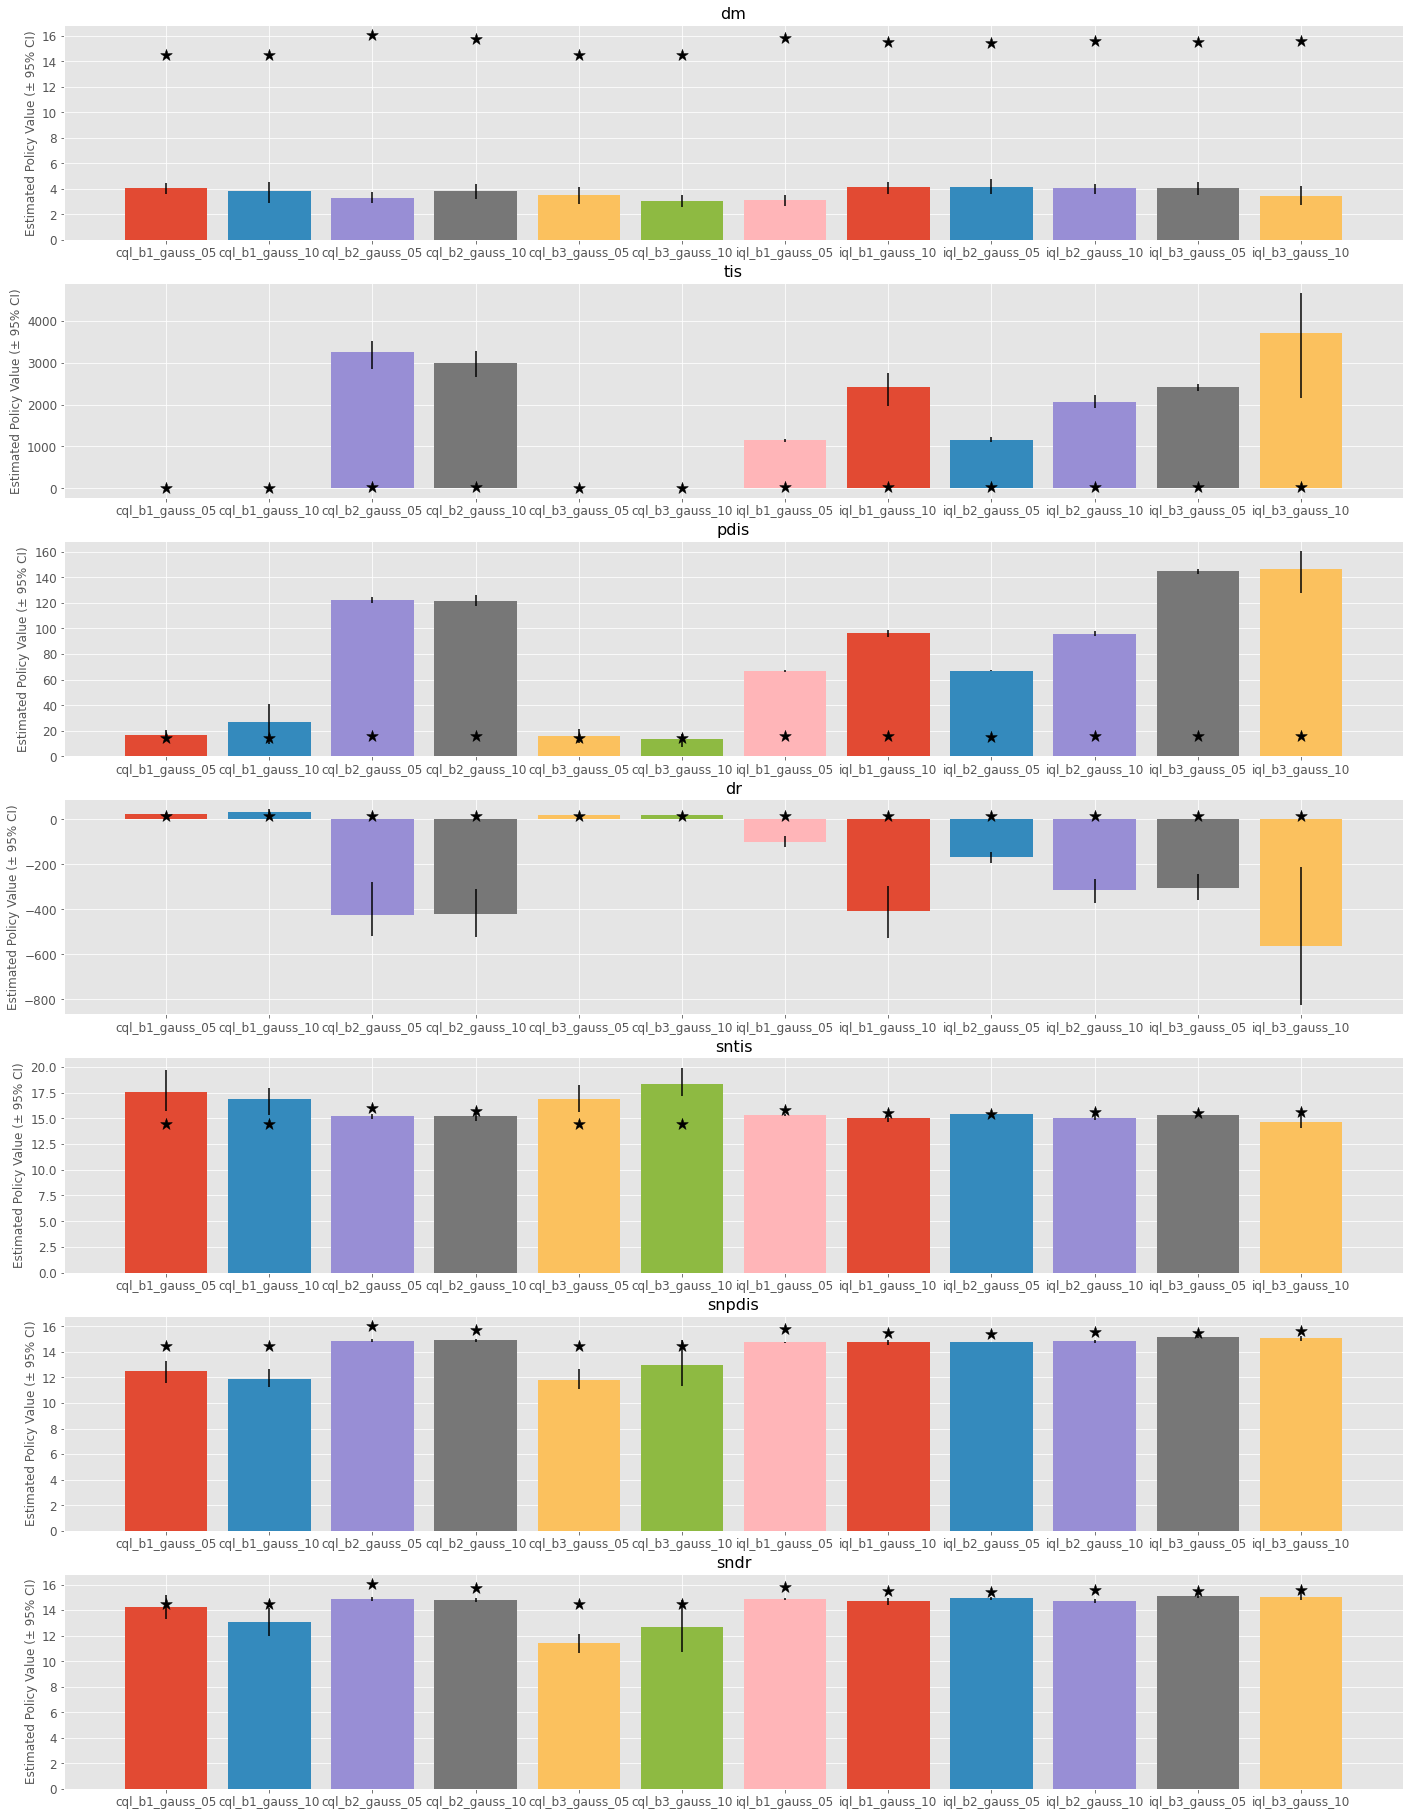

In [29]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="ci",
    hue="policy",
    random_state=random_state,
)

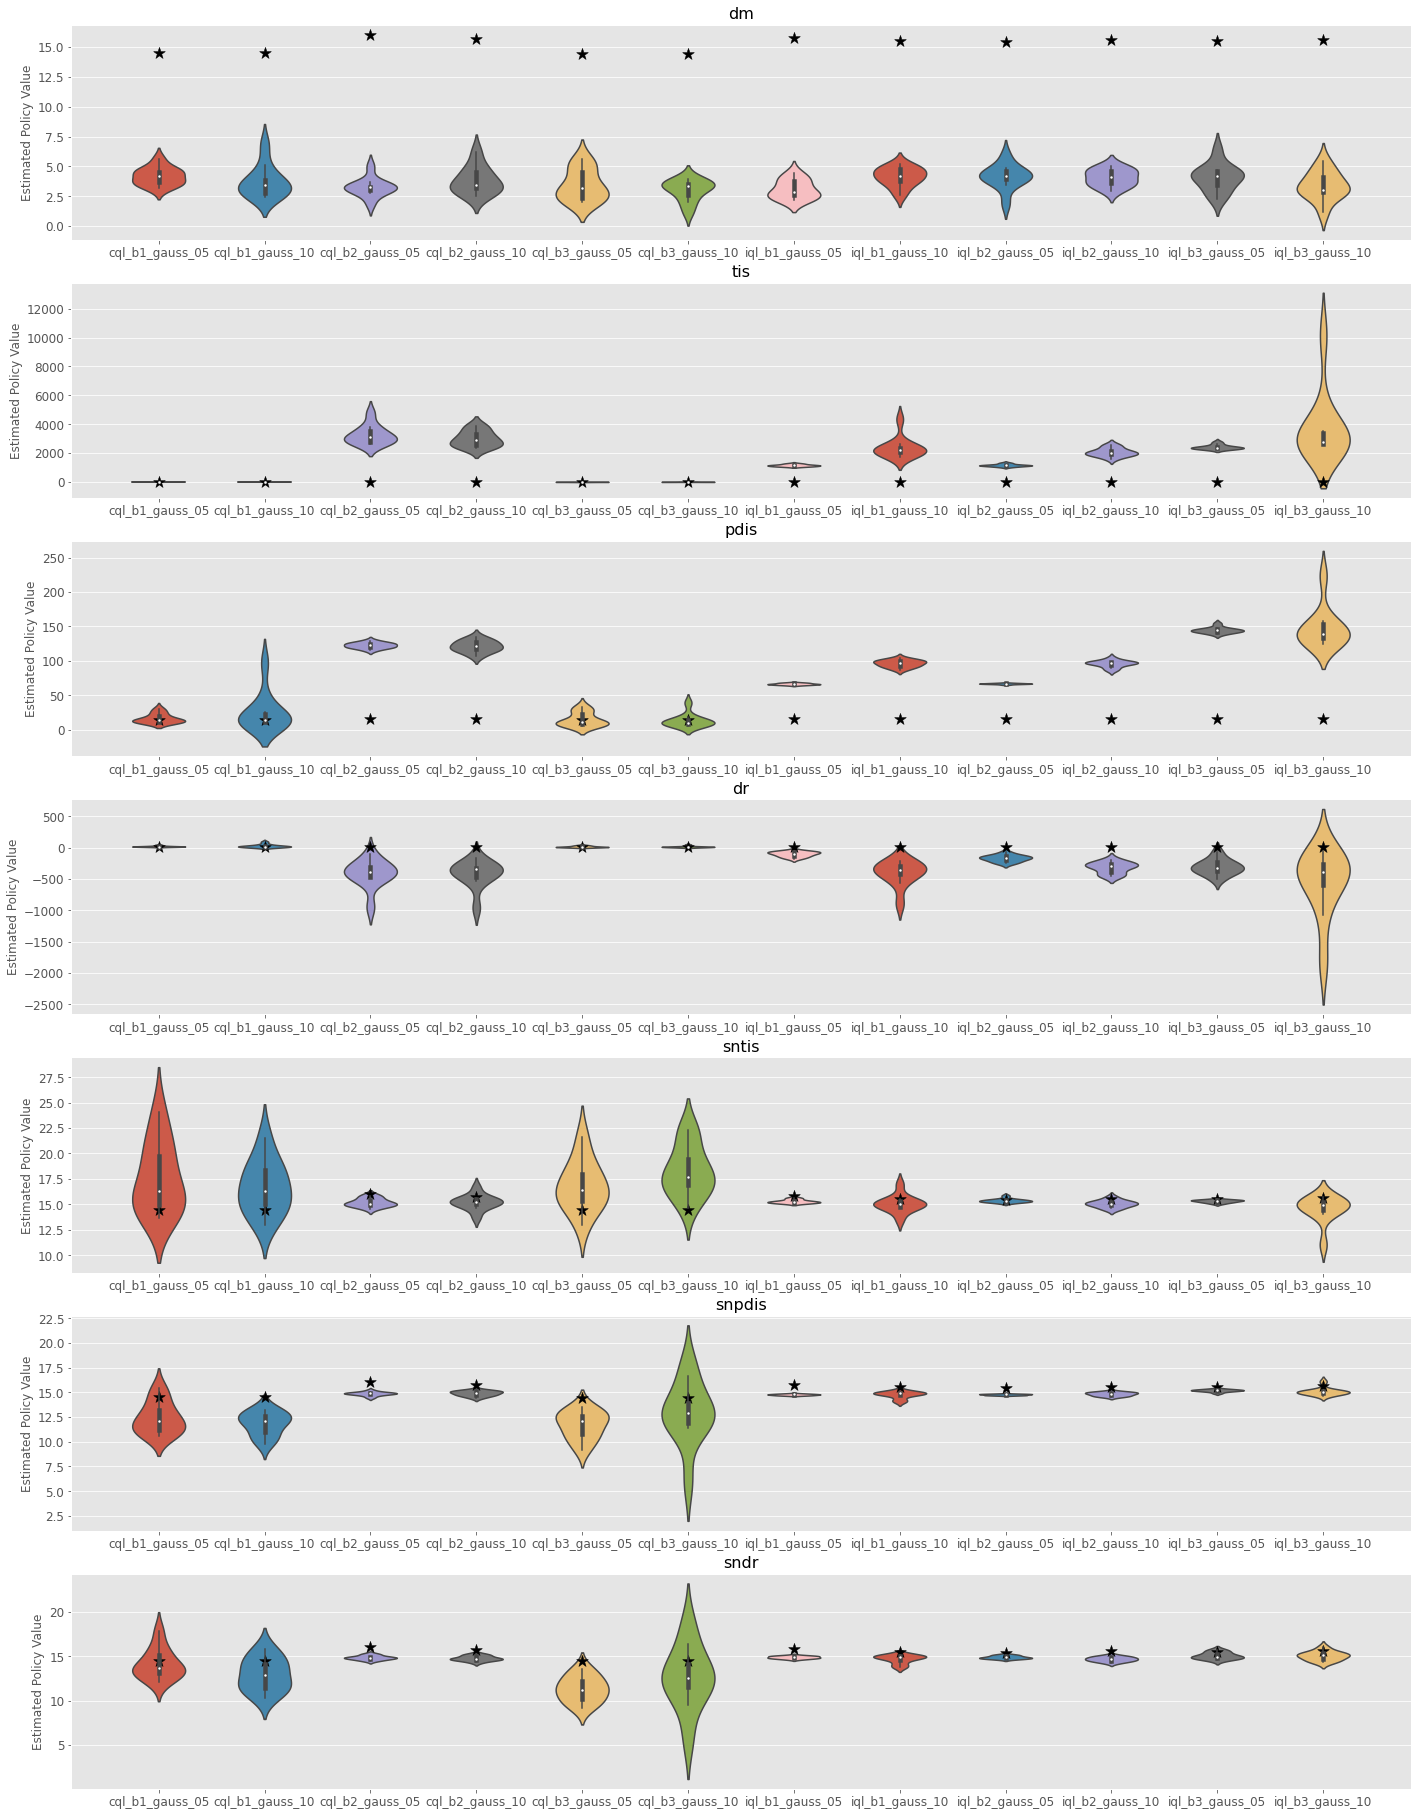

In [30]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="violin",
    hue="policy",
    random_state=random_state,
)

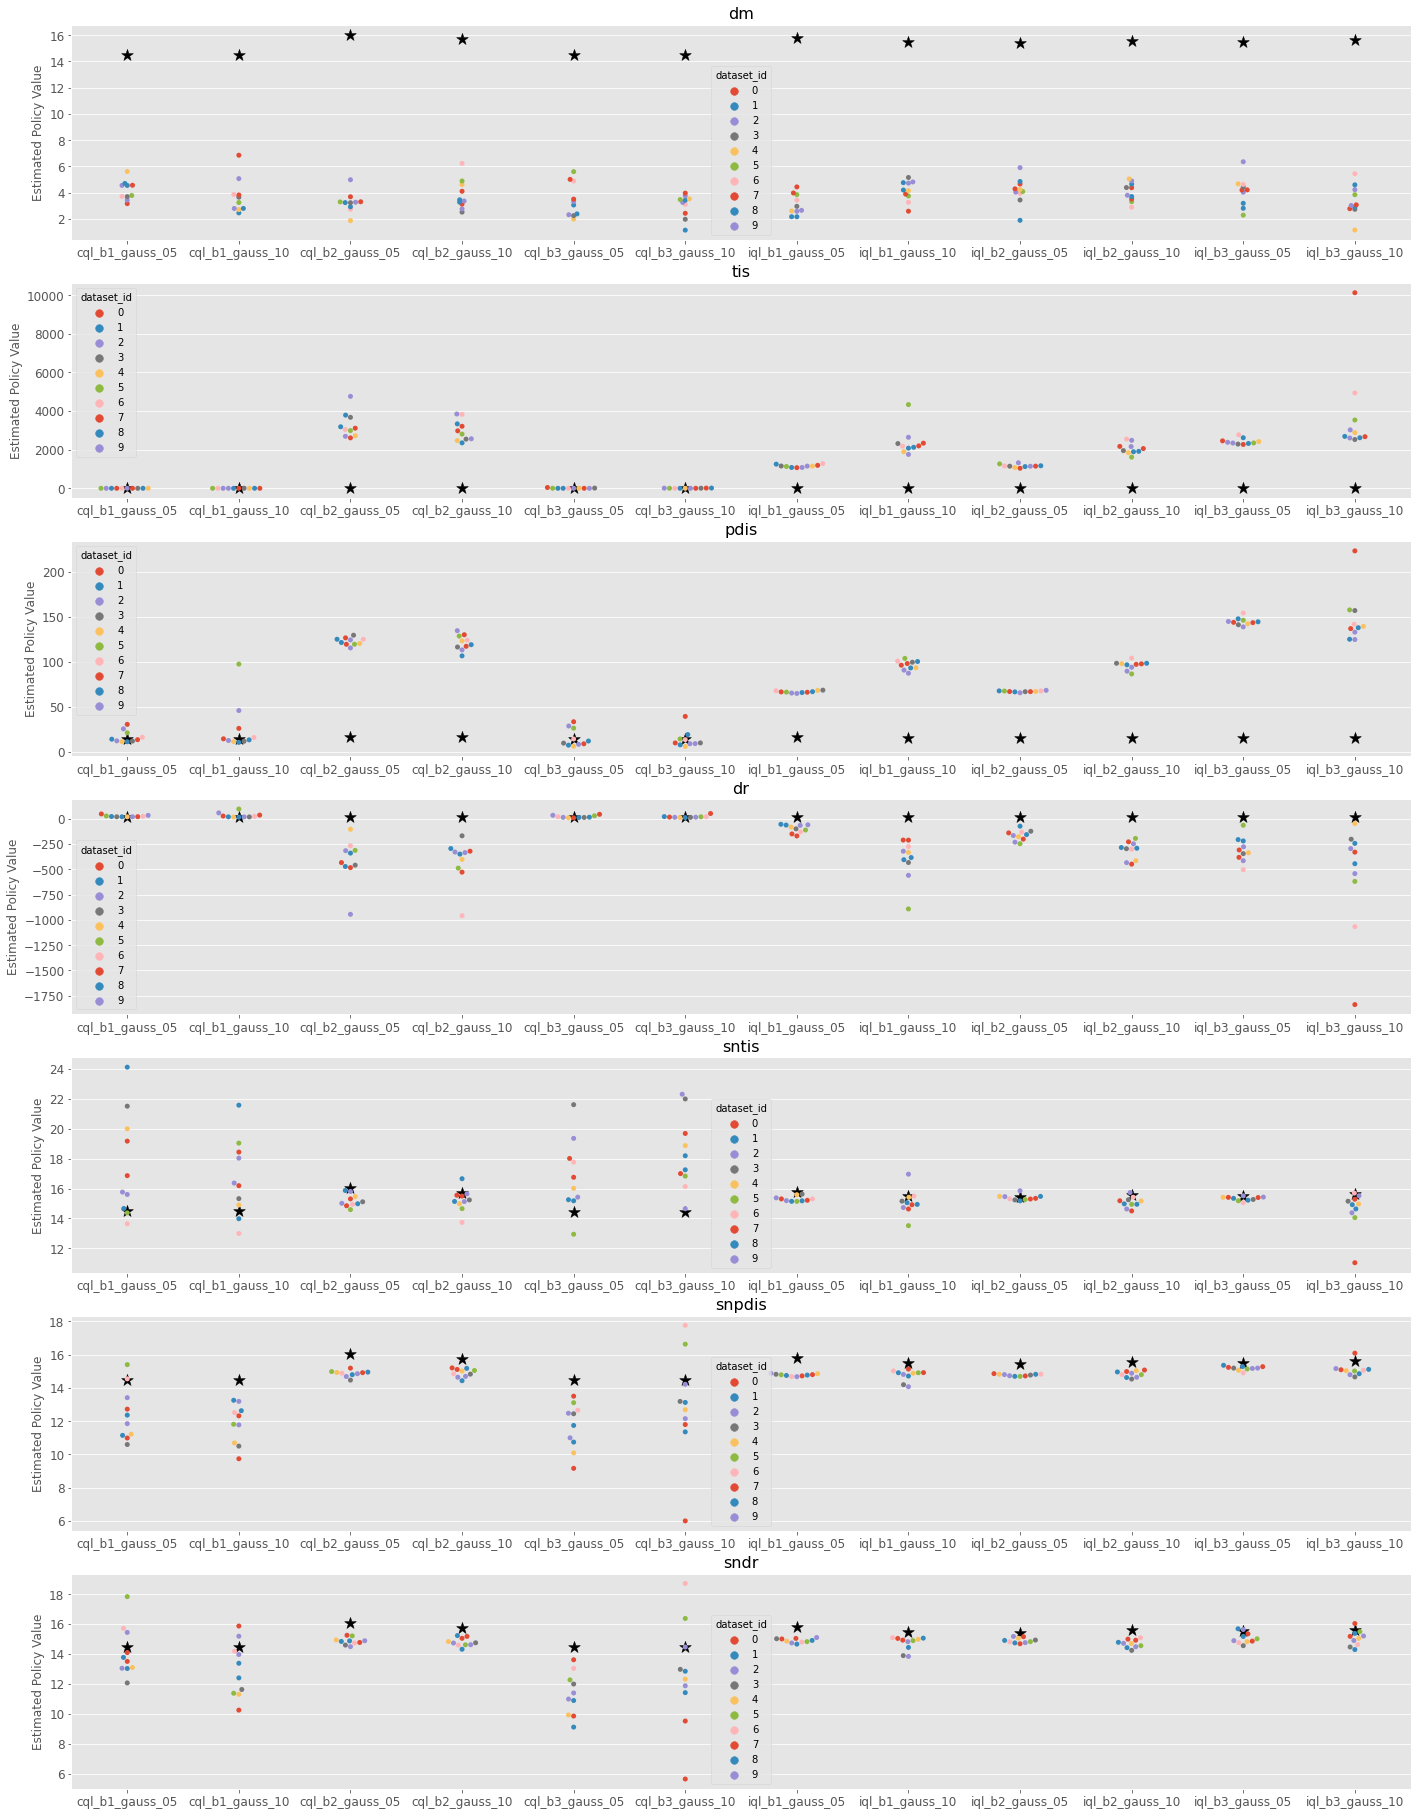

In [31]:
ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="scatter",
    hue="policy",
    random_state=random_state,
)

#### Cumulative Distribution Function Estimation
We can also estimate various statistics regarding the policy performance based on the cumulative distribution function of the trajectory wise reward.

$$ F(t, \pi) := \mathbb{E}\left[ \mathbb{I} \left \{ \sum_{t=1}^T \gamma^{t-1} r_t \leq t \right \} \mid \pi \right] $$

Specifically, we can estimate the following performance metrics.
- Cumulative Distribution Function
- Mean of the return (i.e., policy value)
- Variance of the return
- Conditional Value at Risk
- Interquartile Range

In [32]:
from ofrl.ope import CumulativeDistributionOffPolicyEvaluation as CumulativeDistributionOPE
from ofrl.ope import ContinuousCumulativeDistributionDirectMethod as CD_DM
from ofrl.ope import ContinuousCumulativeDistributionTrajectoryWiseImportanceSampling as CD_IS
from ofrl.ope import ContinuousCumulativeDistributionTrajectoryWiseDoublyRobust as CD_DR
from ofrl.ope import ContinuousCumulativeDistributionSelfNormalizedTrajectoryWiseImportanceSampling as CD_SNIS
from ofrl.ope import ContinuousCumulativeDistributionSelfNormalizedTrajectoryWiseDoublyRobust as CD_SNDR

In [33]:
cd_ope = CumulativeDistributionOPE(
    logged_dataset=logged_dataset,
    ope_estimators=[
        CD_DM(estimator_name="cdf_dm"), 
        CD_IS(estimator_name="cdf_is"), 
        CD_DR(estimator_name="cdf_dr"), 
        CD_SNIS(estimator_name="cdf_snis"), 
        CD_SNDR(estimator_name="cdf_sndr"),
    ],
)

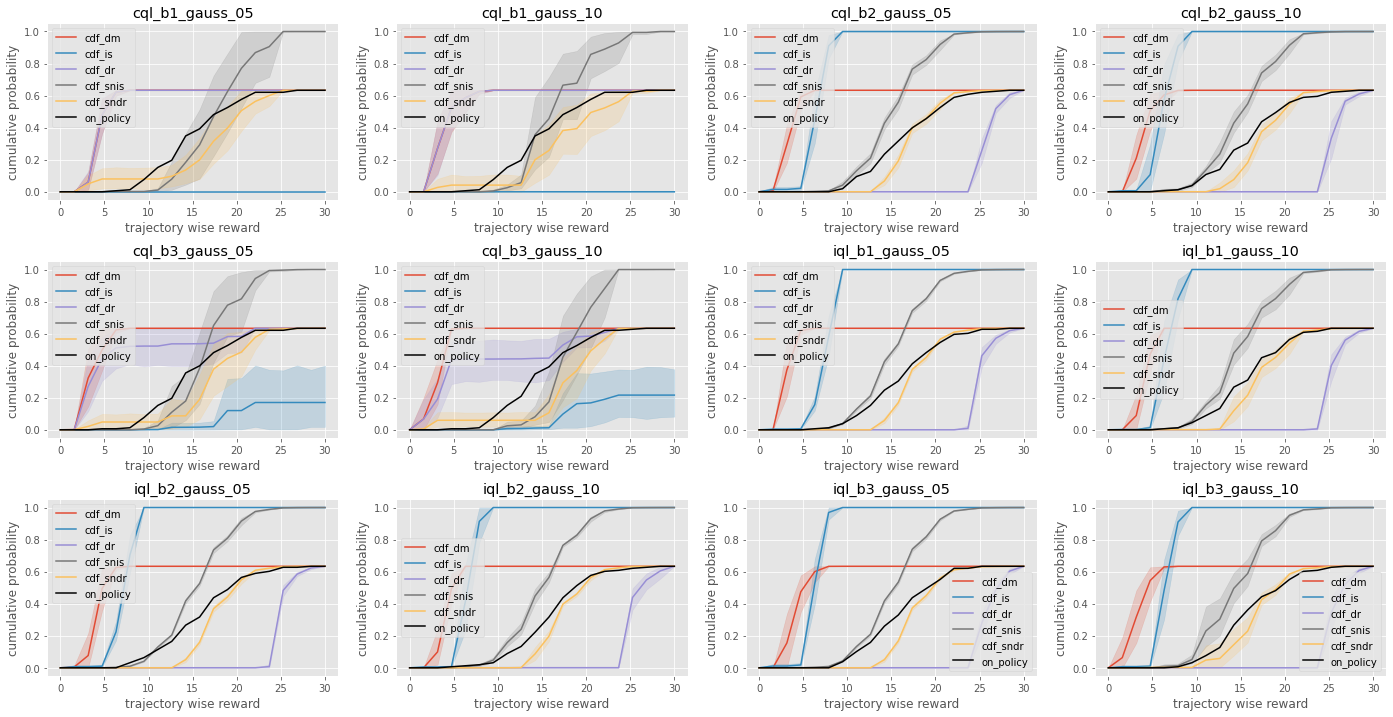

In [34]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict, 
    plot_type="ci",
    scale_min=0.0, 
    scale_max=30.0, 
    n_partition=20, 
    n_cols=4,
)

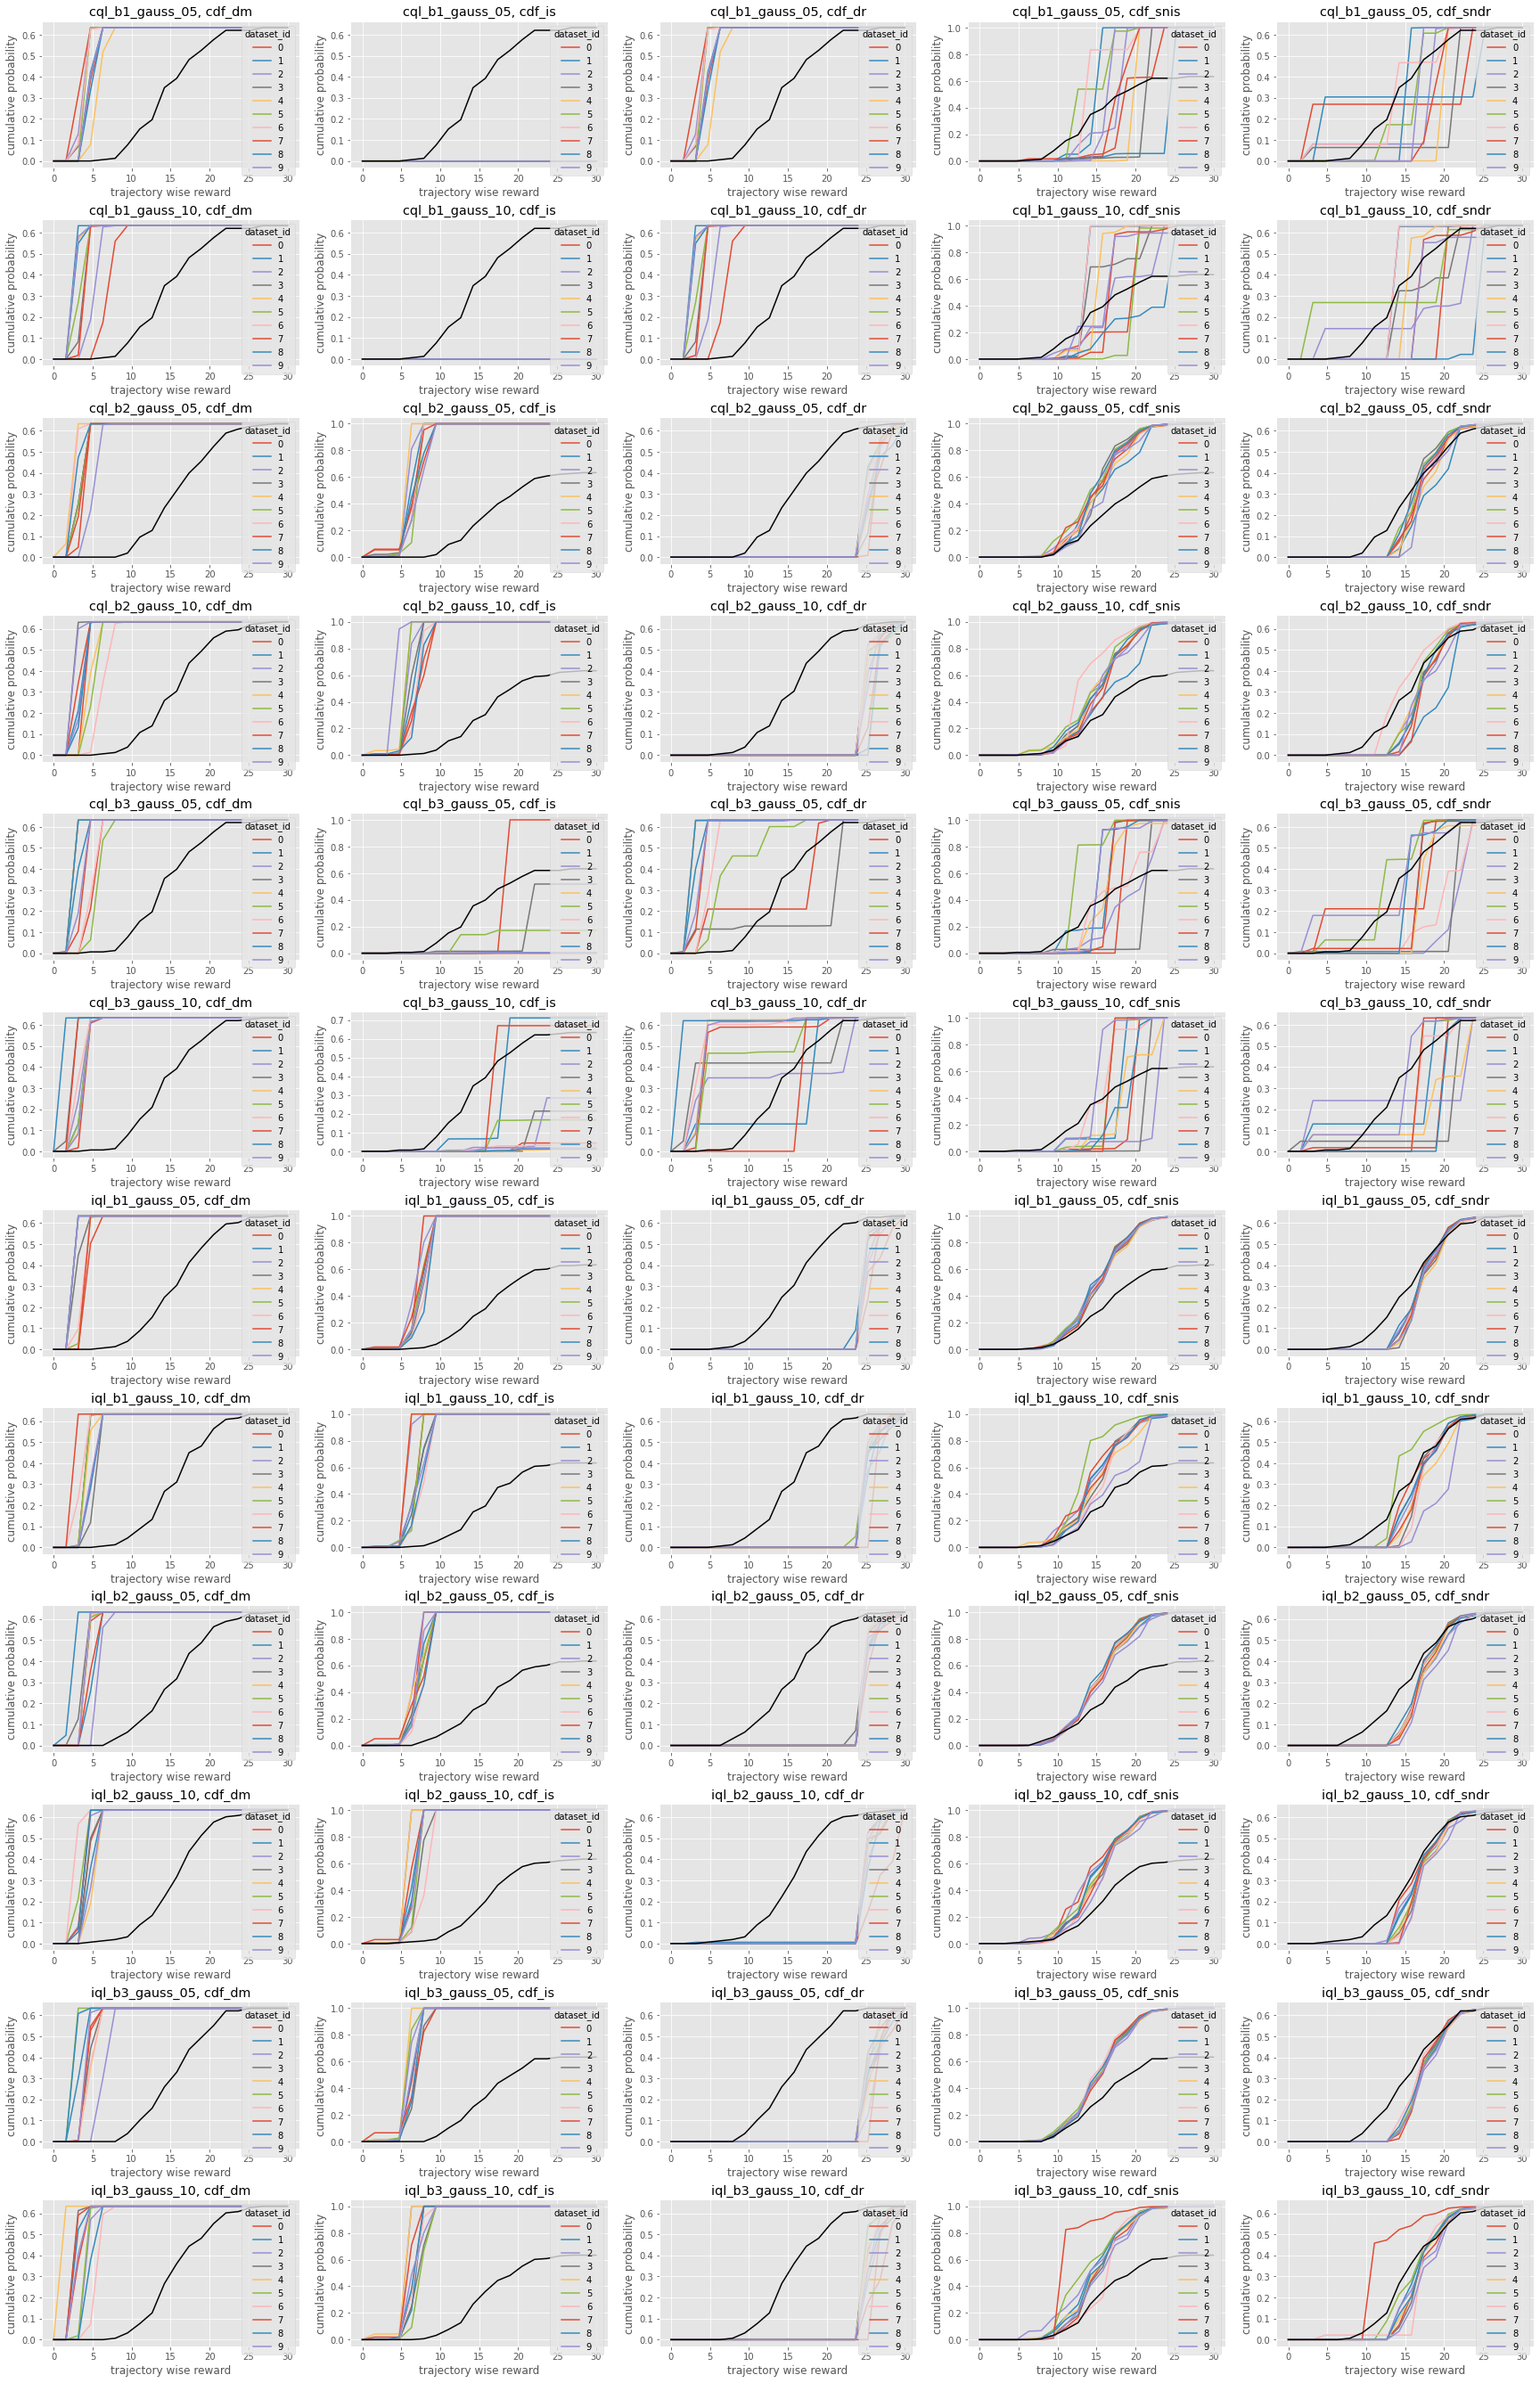

In [35]:
# cumulative distribution function
cd_ope.visualize_cumulative_distribution_function_with_multiple_estimates(
    input_dict, 
    plot_type="enumerate",
    scale_min=0.0, 
    scale_max=30.0, 
    n_partition=20, 
)

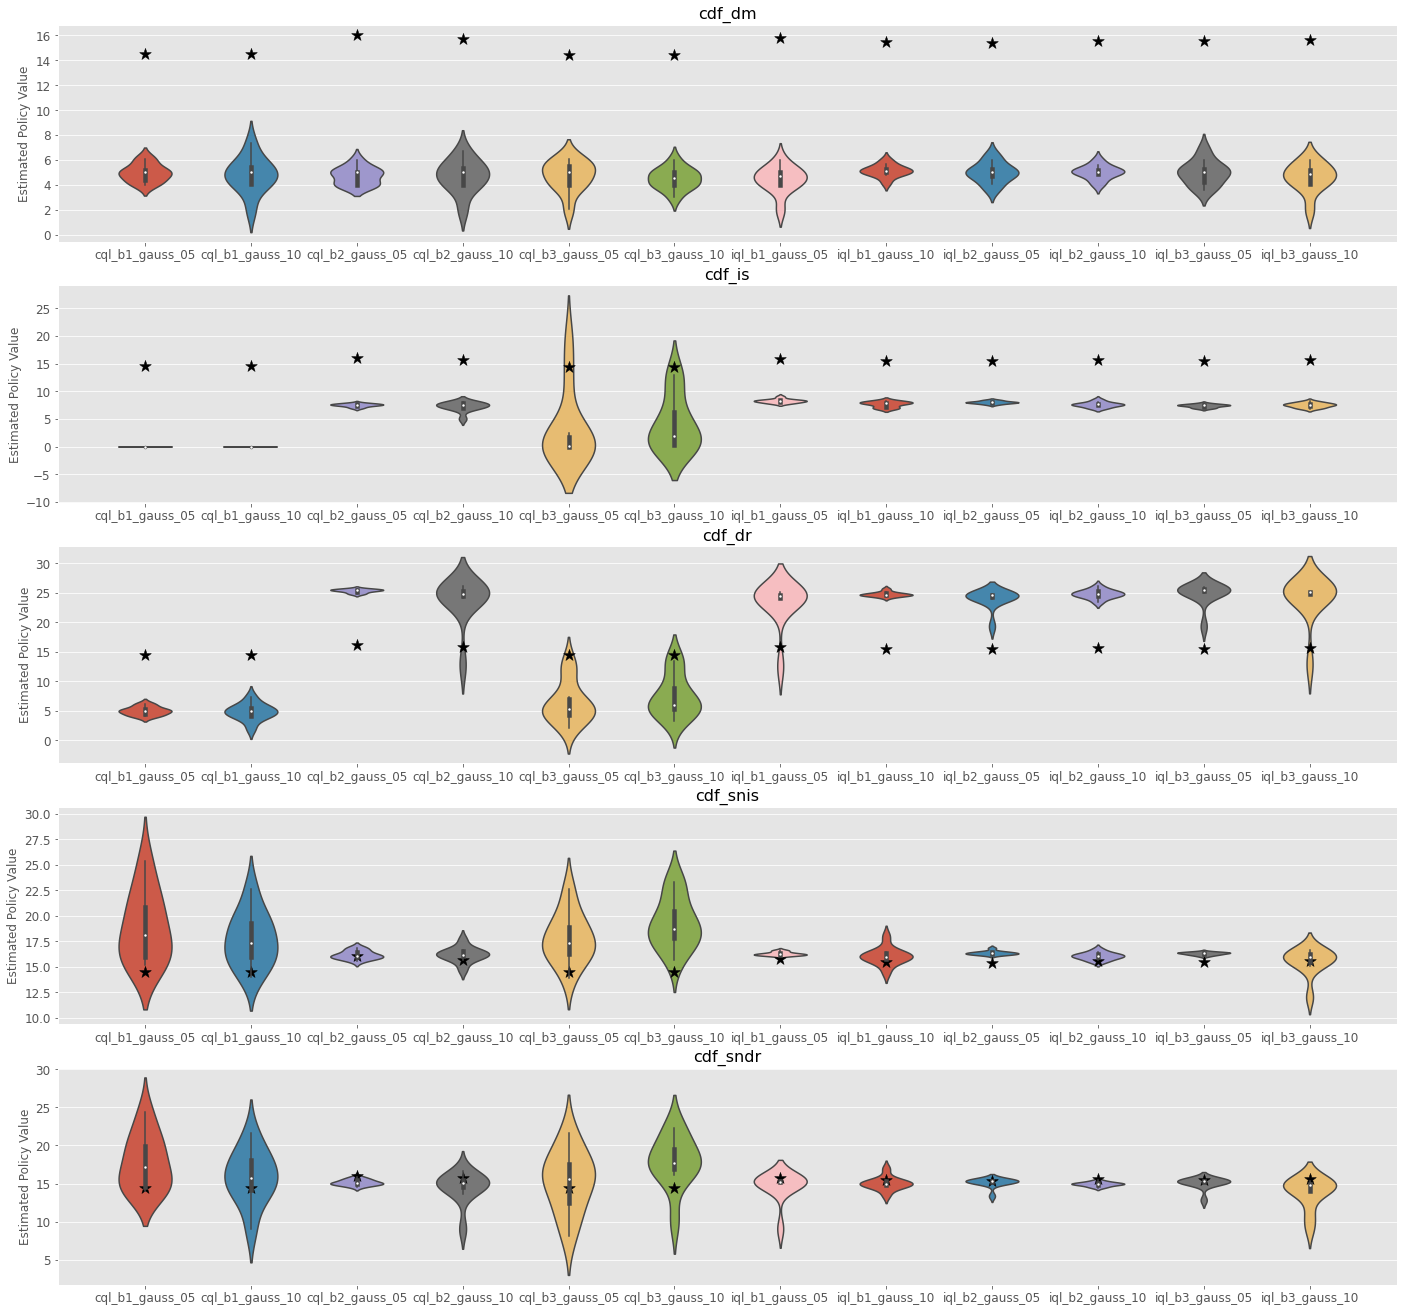

In [36]:
cd_ope.visualize_policy_value_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="violin",
    hue="policy",
    random_state=random_state,
)

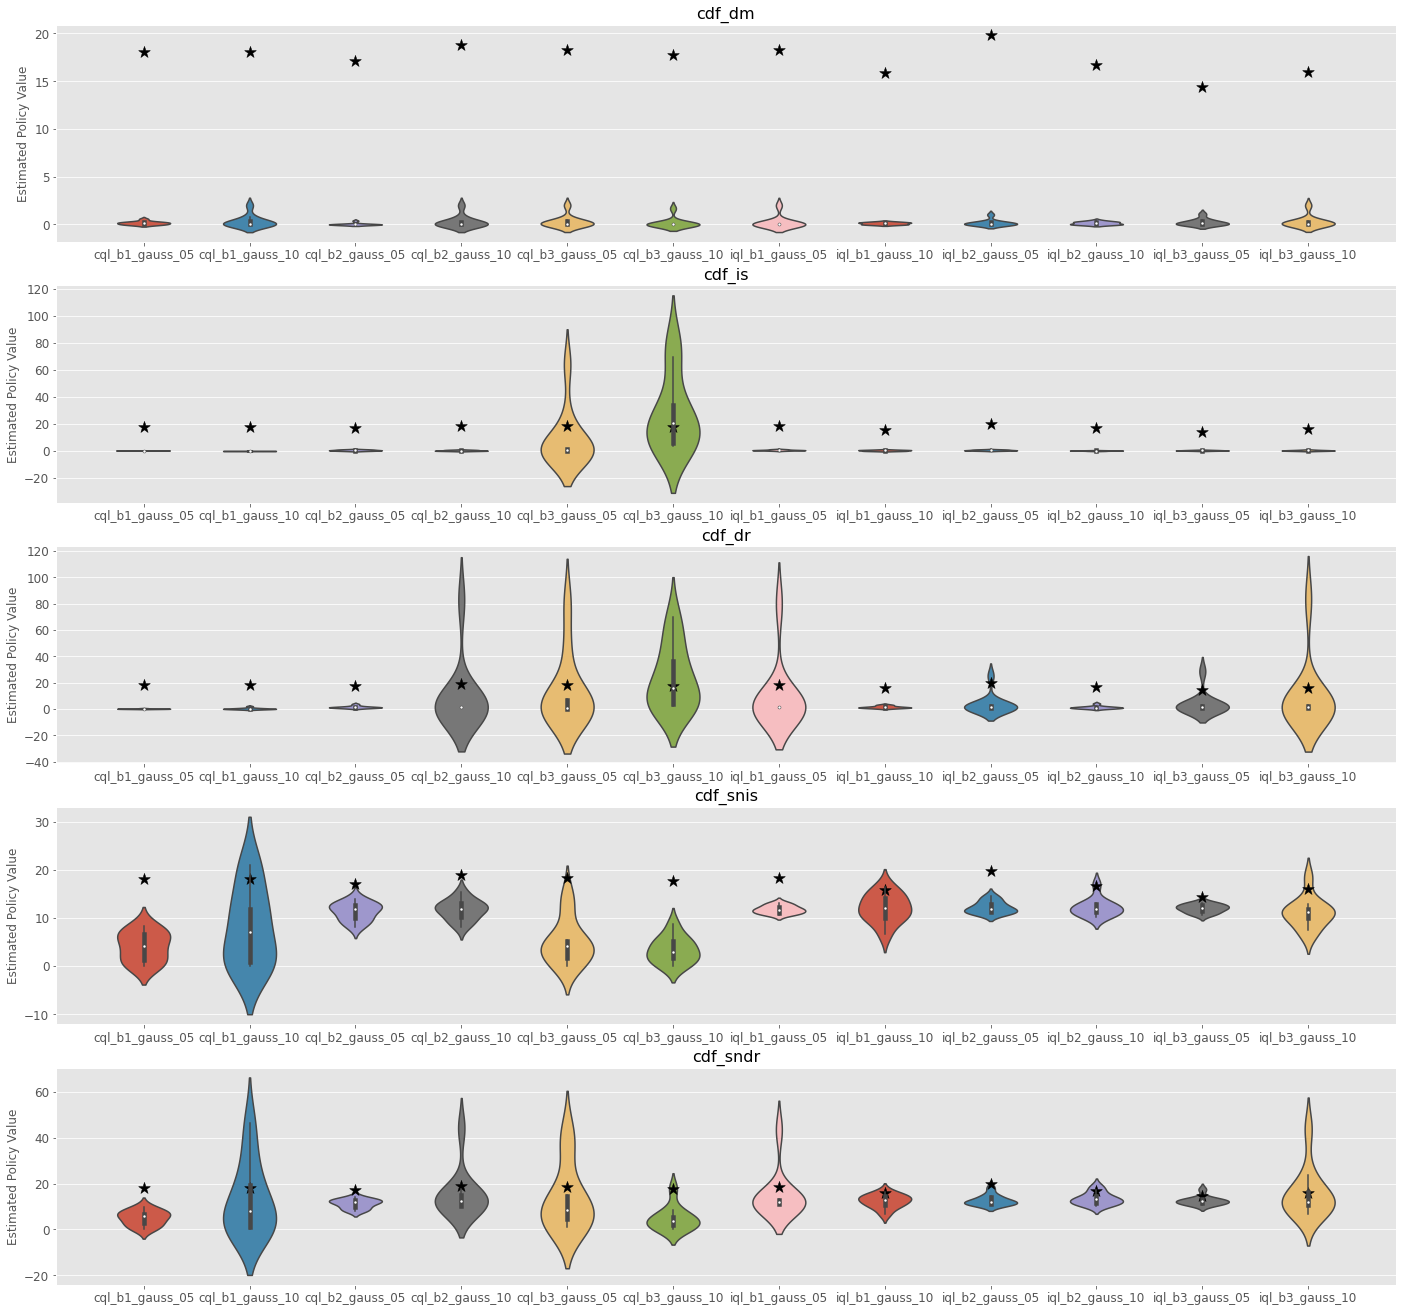

In [37]:
cd_ope.visualize_variance_with_multiple_estimates(
    input_dict=input_dict,
    plot_type="violin",
    hue="policy",
    random_state=random_state,
)

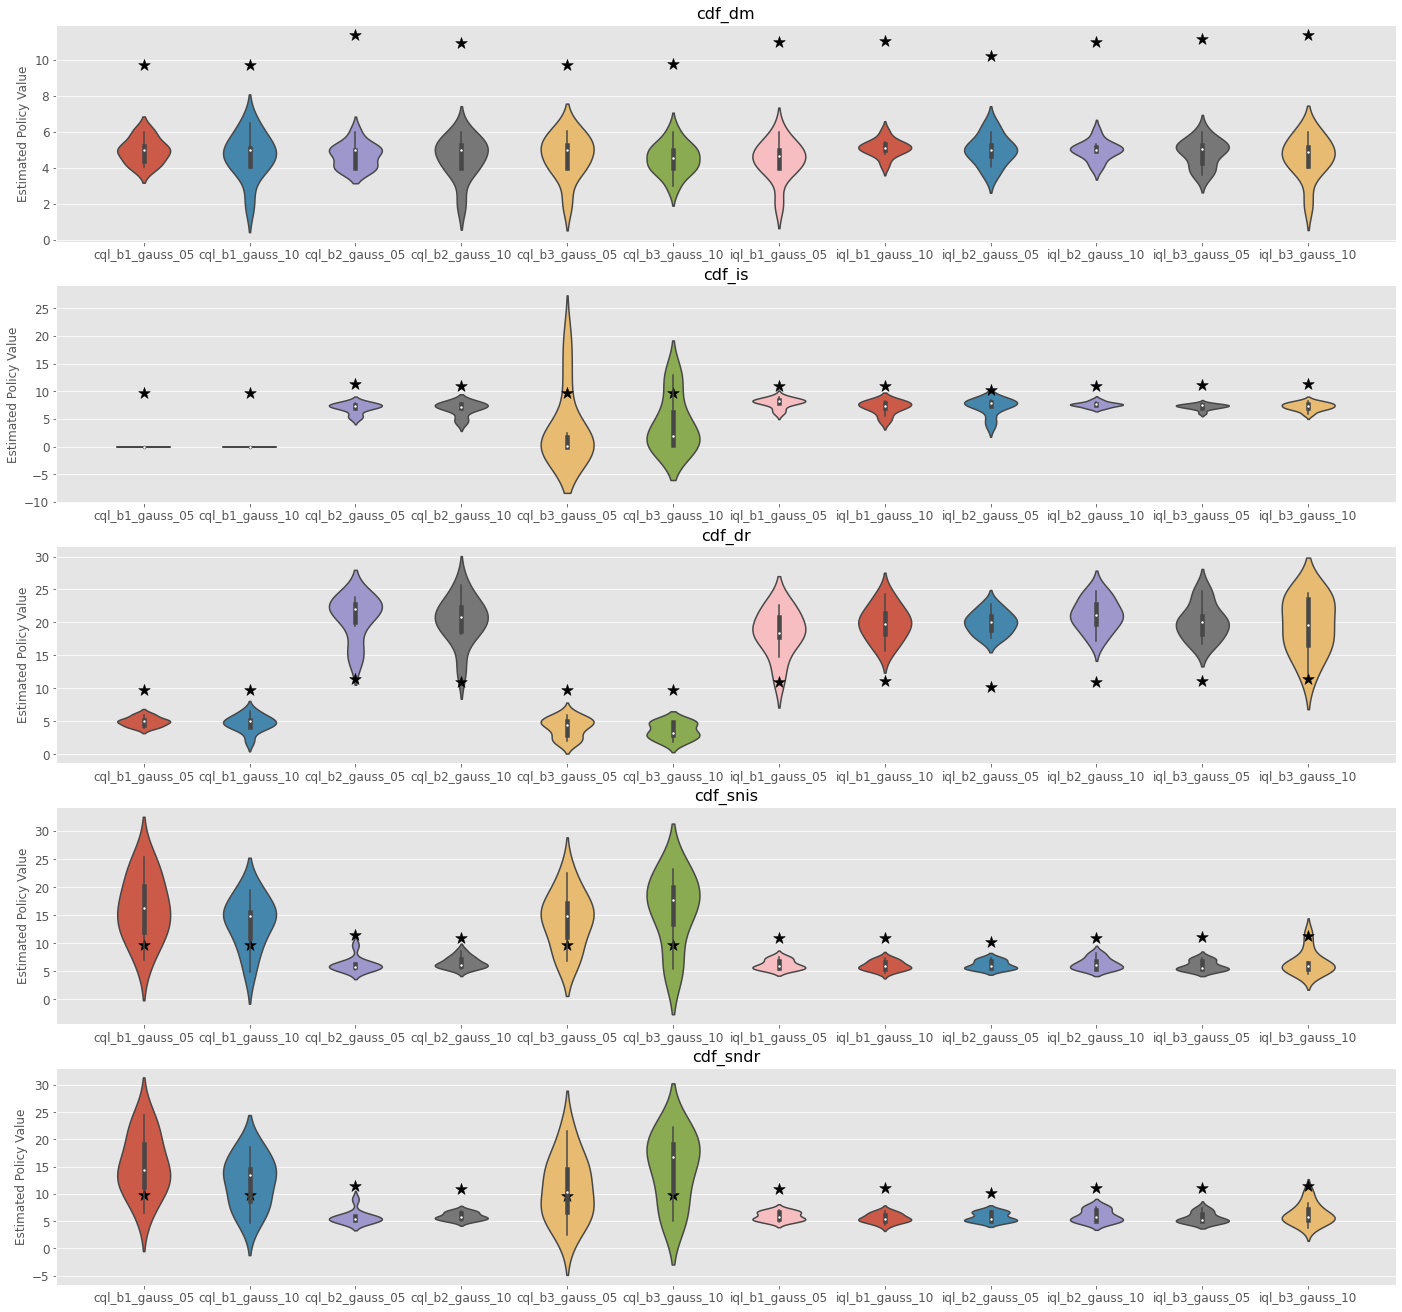

In [38]:
cd_ope.visualize_conditional_value_at_risk_with_multiple_estimates(
    input_dict=input_dict,
    ope_alpha=0.3,
    plot_type="violin",
    hue="policy",
    random_state=random_state,
)

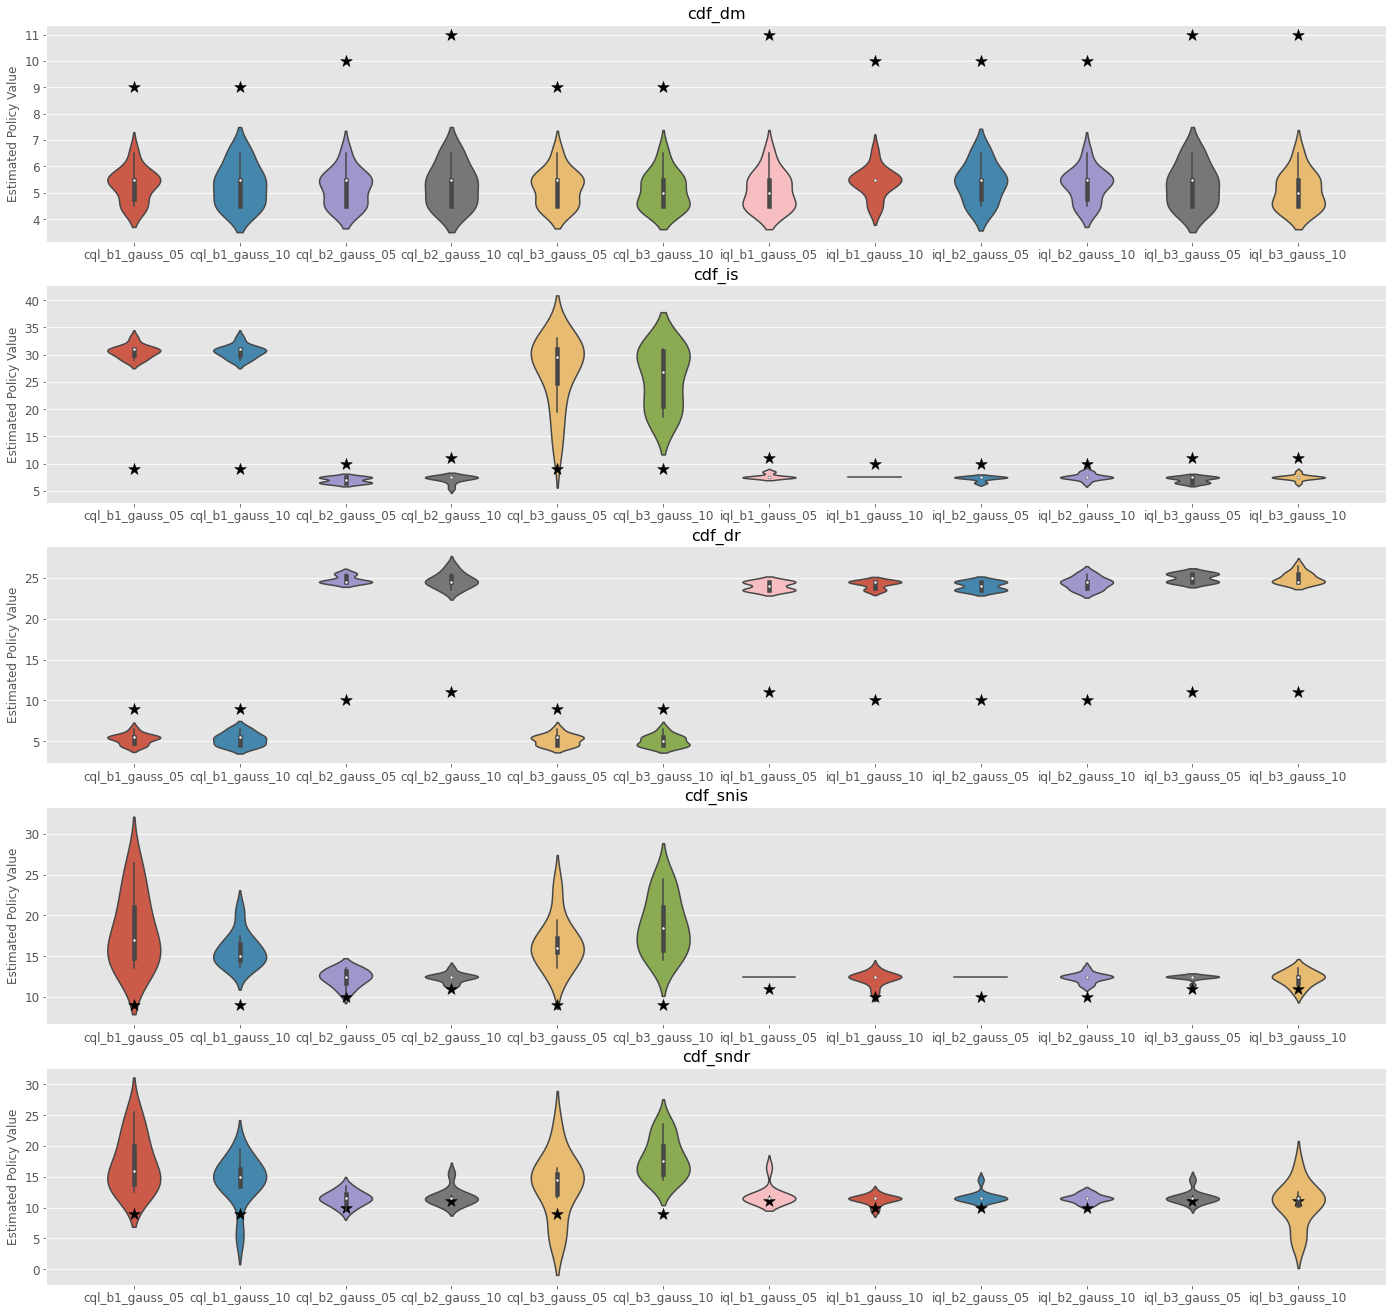

In [39]:
cd_ope.visualize_lower_quartile_with_multiple_estimates(
    input_dict=input_dict,
    ope_alpha=0.1,
    plot_type="violin",
    hue="policy",
    random_state=random_state,
)

## 3. Off-Policy Selection

Off Policy Selection aims to select the ''best'' policy among several candidate policies based on some metrics.

In [40]:
from ofrl.ope import OffPolicySelection

In [41]:
ops = OffPolicySelection(
    ope=ope,
    cumulative_distribution_ope=cd_ope,
)

In [42]:
true_selection_result = ops.obtain_true_selection_result(
    input_dict=input_dict,
    return_variance=True,
    return_lower_quartile=True,
    return_conditional_value_at_risk=True,
    return_by_dataframe=True,
)
true_selection_result[0]

ranking  policy_value  relative_policy_value   variance  \
0   cql_b2_gauss_05         16.05               1.024845  17.138889   
1   iql_b1_gauss_05         15.78               1.007605  18.274343   
2   cql_b2_gauss_10         15.72               1.003774  18.829899   
3   iql_b3_gauss_10         15.61               0.996750  15.937273   
4   iql_b2_gauss_10         15.57               0.994196  16.671818   
5   iql_b3_gauss_05         15.51               0.990365  14.393838   
6   iql_b1_gauss_10         15.50               0.989726  15.828283   
7   iql_b2_gauss_05         15.41               0.983979  19.860505   
8   cql_b1_gauss_10         14.49               0.925234  18.050404   
9   cql_b1_gauss_05         14.49               0.925234  18.050404   
10  cql_b3_gauss_10         14.46               0.923319  17.705455   
11  cql_b3_gauss_05         14.46               0.923319  18.291313   

   ranking_by_lower_quartile  lower_quartile  \
0            cql_b1_gauss_05           10.00   
1            cql_b1_gauss_10            9.95   
2            cql_b2_gauss_05            9.90   
3            cql_b2_gauss_10            9.00   
4            cql_b3_gauss_05            9.00   
5            cql_b3_gauss_10            9.00   
6            iql_b1_gauss_05            8.95   
7            iql_b1_gauss_10            8.00   
8            iql_b2_gauss_10            8.00   
9            iql_b2_gauss_05            8.00   
10           iql_b3_gauss_10            8.00   
11           iql_b3_gauss_05            7.95   

   ranking_by_conditional_value_at_risk  conditional_value_at_risk  
0                       cql_b2_gauss_05                        9.2  
1                       iql_b3_gauss_05                        8.8  
2                       iql_b3_gauss_10                        8.0  
3                       iql_b1_gauss_10                        7.8  
4                       cql_b2_gauss_10                        7.4  
5                       iql_b1_gauss_05                        7.2  
6                       cql_b1_gauss_10                        7.2  
7                       cql_b1_gauss_05                        7.2  
8                       iql_b2_gauss_05                        7.0  
9                       cql_b3_gauss_10                        7.0  
10                      cql_b3_gauss_05                        7.0  
11                      iql_b2_gauss_10                        6.6

In [43]:
ranking_df, metric_df = ops.select_by_policy_value(
    input_dict=input_dict,
    return_true_values=True,
    return_metrics=True,
    return_by_dataframe=True,
)

In [44]:
ranking_df[0]

{'dm':    estimated_ranking  estimated_policy_value  estimated_relative_policy_value  \
 0    cql_b1_gauss_10                6.854784                         0.437701   
 1    cql_b3_gauss_05                5.013557                         0.320132   
 2    iql_b1_gauss_05                4.440731                         0.283555   
 3    iql_b2_gauss_10                4.378822                         0.279602   
 4    iql_b2_gauss_05                4.292983                         0.274121   
 5    iql_b3_gauss_05                4.202181                         0.268323   
 6    cql_b2_gauss_10                4.108329                         0.262330   
 7    cql_b3_gauss_10                3.965606                         0.253217   
 8    iql_b1_gauss_10                3.891467                         0.248483   
 9    cql_b2_gauss_05                3.689056                         0.235558   
 10   cql_b1_gauss_05                3.165960                         0.202157   
 11   iql_

In [45]:
metric_df[0]

estimator  mean_squared_error  rank_correlation    pvalue  regret@1  \
0        dm        1.225621e+02         -0.223776  0.484452      1.56   
1       tis        3.267683e+06          0.776224  0.002993      0.33   
2      pdis        6.100365e+03          0.734266  0.006543      0.54   
3        dr        8.734501e+04         -0.776224  0.002993      1.56   
4     sntis        6.681477e+00         -0.650350  0.022034      1.59   
5    snpdis        1.655875e+00          0.622378  0.030676      0.54   
6      sndr        2.581687e+00          0.426573  0.166700      1.56   

   type_i_error_rate  type_ii_error_rate  
0           0.000000                 0.0  
1           0.000000                 0.0  
2           0.000000                 0.0  
3           0.666667                 0.0  
4           0.000000                 0.0  
5           0.000000                 0.0  
6           0.000000                 0.0

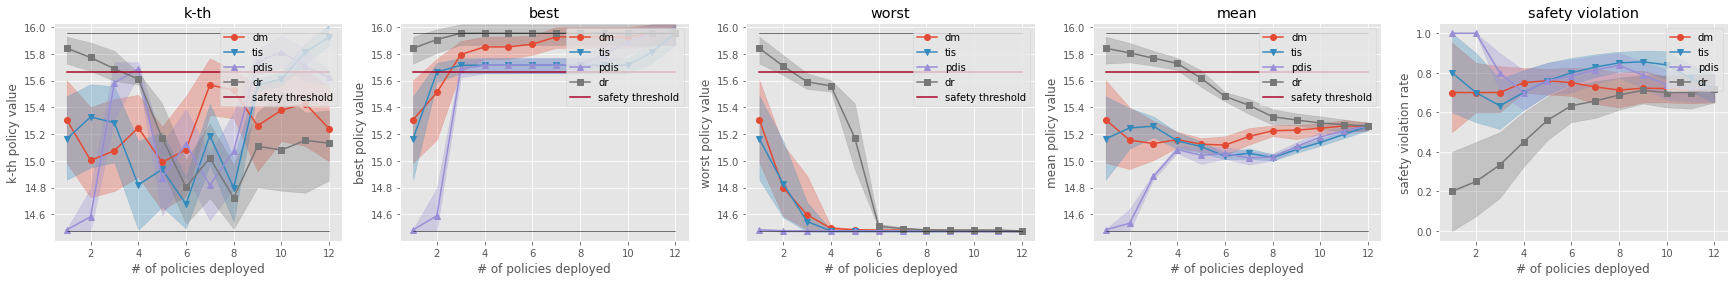

In [46]:
ops.visualize_topk_policy_value_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    safety_criteria=1.0,
    legend=True,
    random_state=random_state,
)

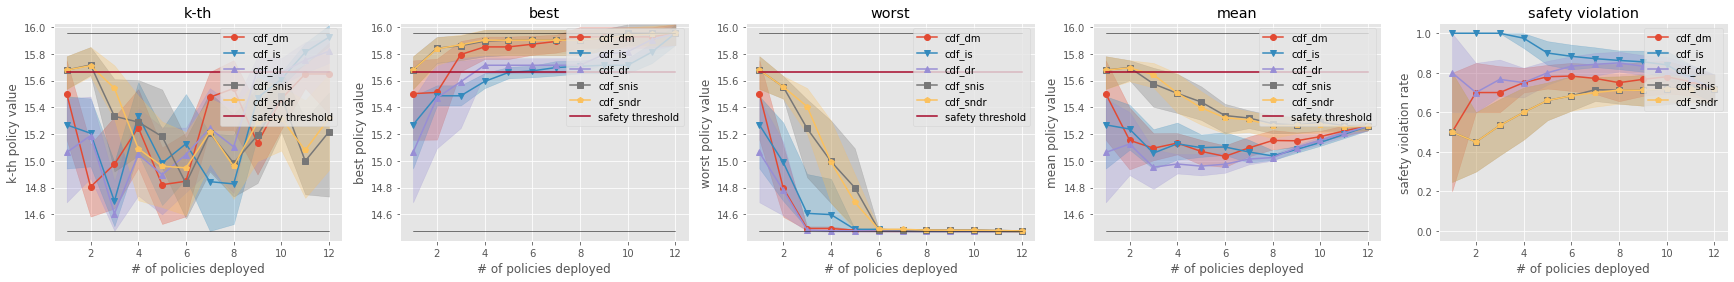

In [47]:
ops.visualize_topk_policy_value_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    safety_criteria=1.0,
    legend=True,
    random_state=random_state,
)

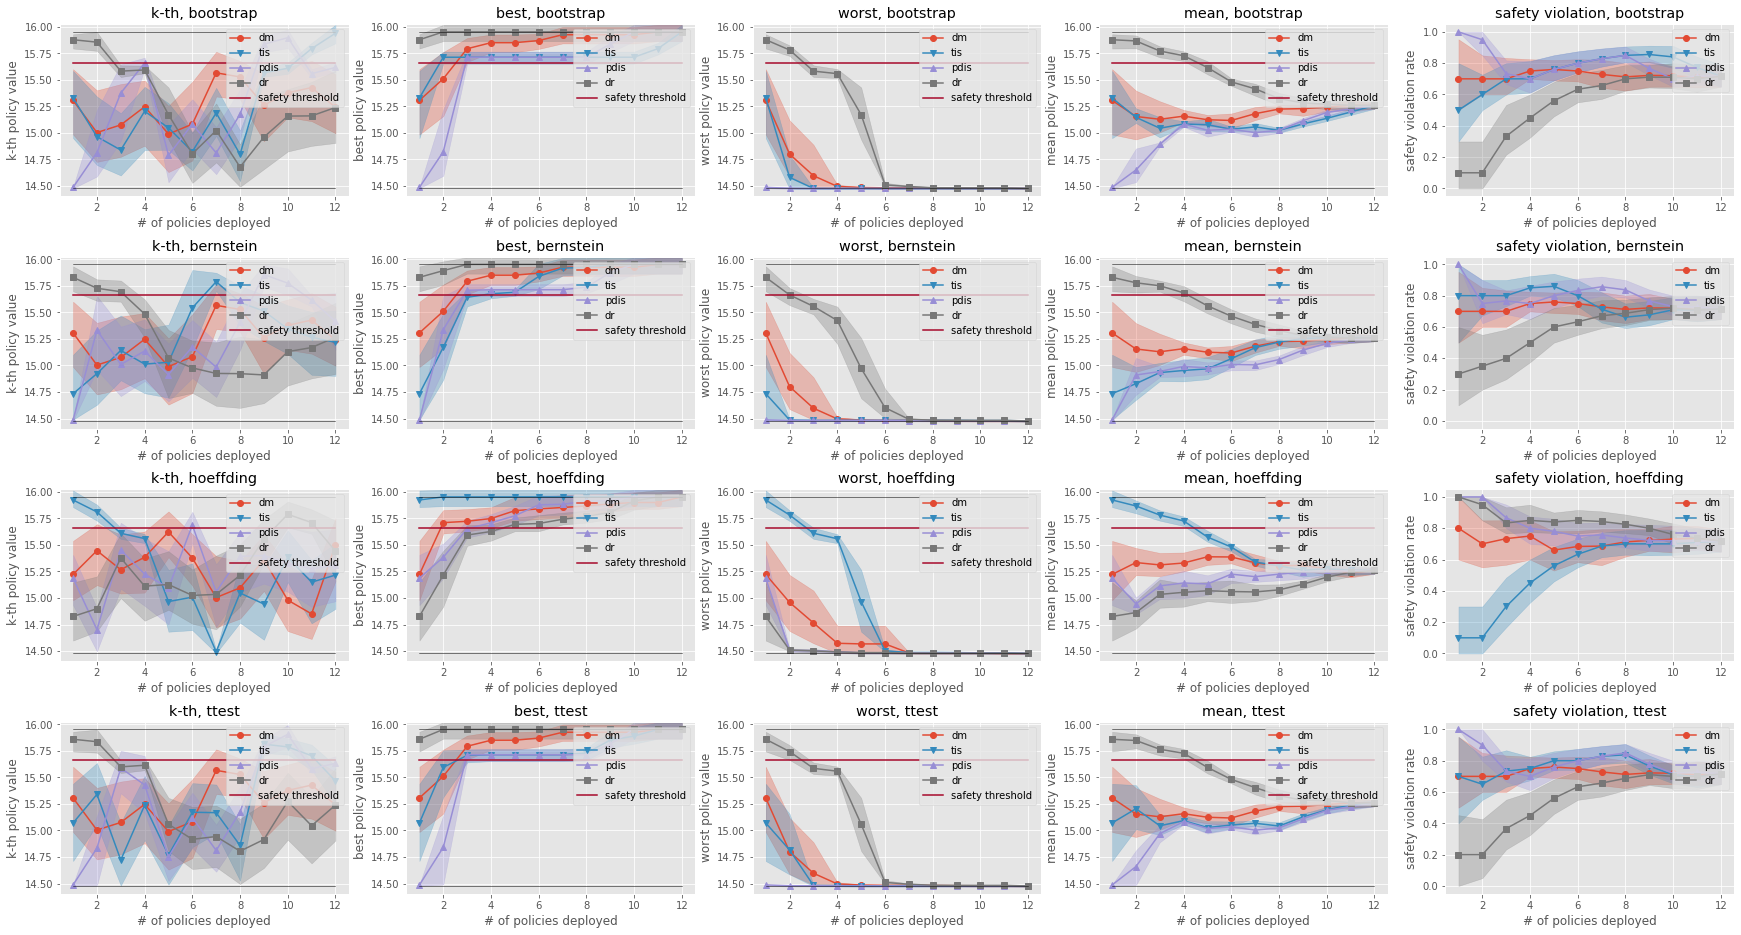

In [48]:
ops.visualize_topk_policy_value_selected_by_lower_bound(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    ope_cis=["bootstrap", "bernstein", "hoeffding", "ttest"],
    visualize_ci=True,
    safety_criteria=1.0,
    legend=True,
    random_state=random_state,
)

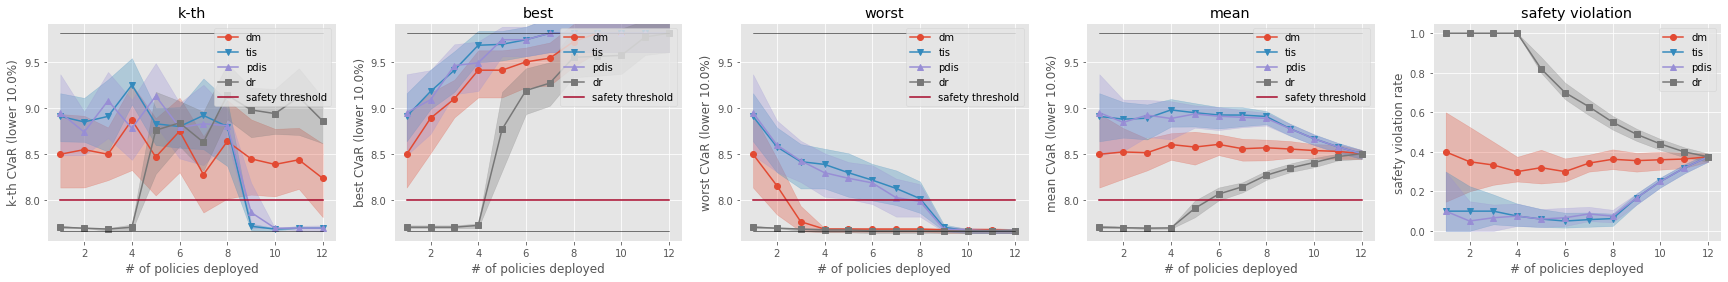

In [49]:
ops.visualize_topk_conditional_value_at_risk_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=8.0,
    legend=True,
    random_state=random_state,
)

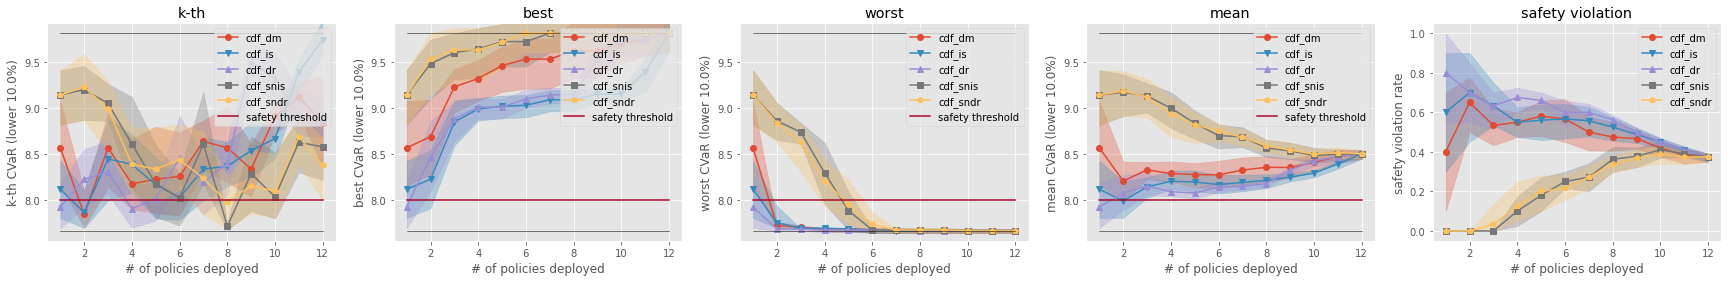

In [50]:
ops.visualize_topk_conditional_value_at_risk_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=8.0,
    legend=True,
    random_state=random_state,
)

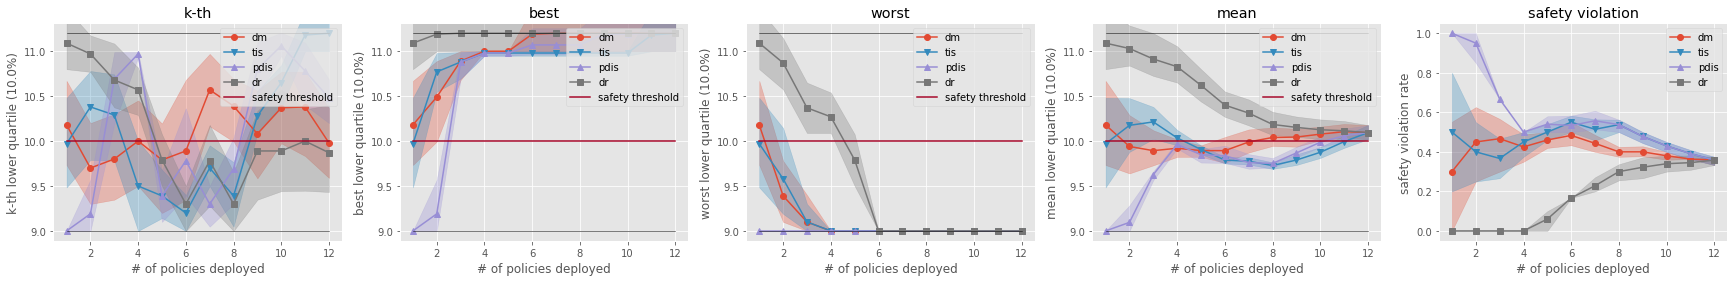

In [51]:
ops.visualize_topk_lower_quartile_selected_by_standard_ope(
    input_dict=input_dict,
    compared_estimators=["dm", "tis", "pdis", "dr"],
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=10.0,
    legend=True,
    random_state=random_state,
)

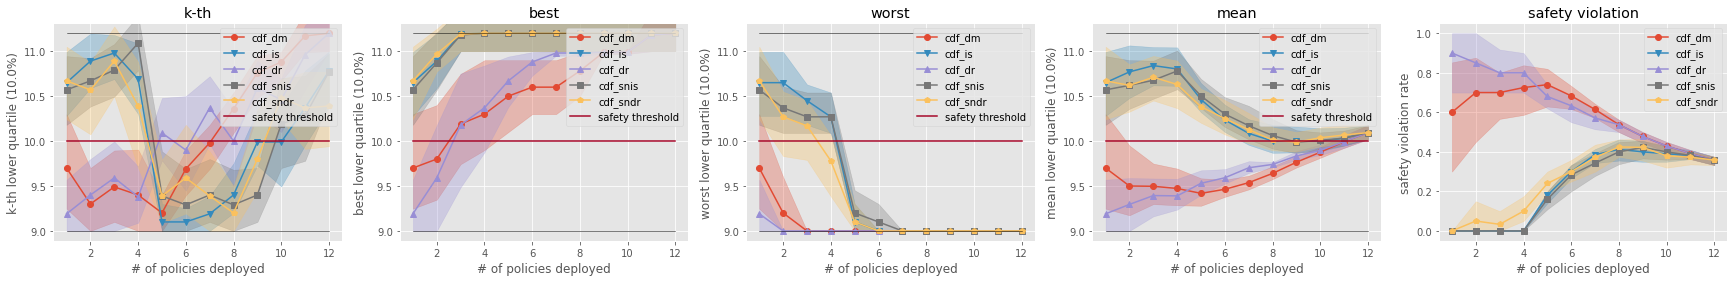

In [52]:
ops.visualize_topk_lower_quartile_selected_by_cumulative_distribution_ope(
    input_dict=input_dict,
    visualize_ci=True,
    ope_alpha=0.10,
    safety_threshold=10.0,
    legend=True,
    random_state=random_state,
)

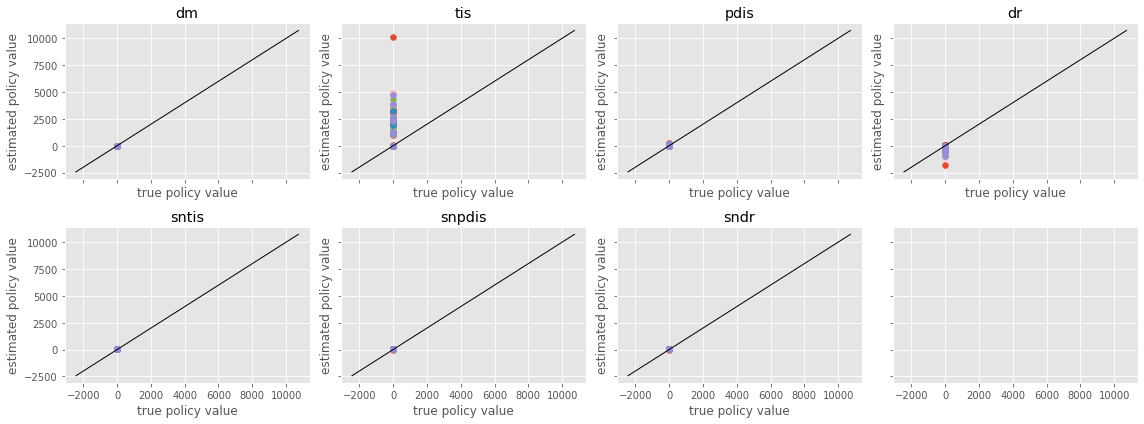

In [53]:
ops.visualize_policy_value_for_validation(
    input_dict=input_dict,
    n_cols=4,
    share_axes=True,
)

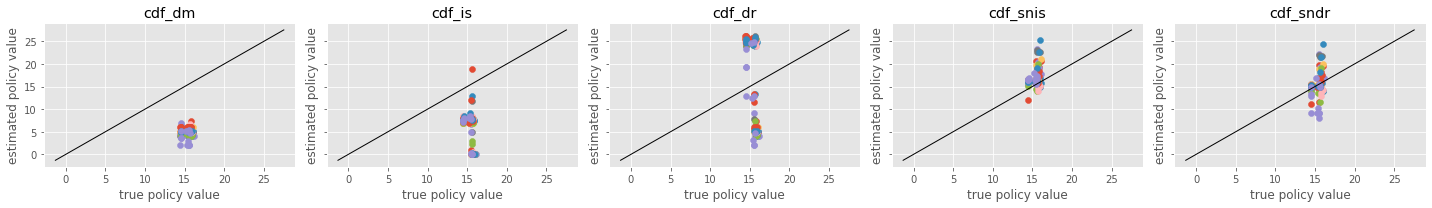

In [54]:
ops.visualize_policy_value_of_cumulative_distribution_ope_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

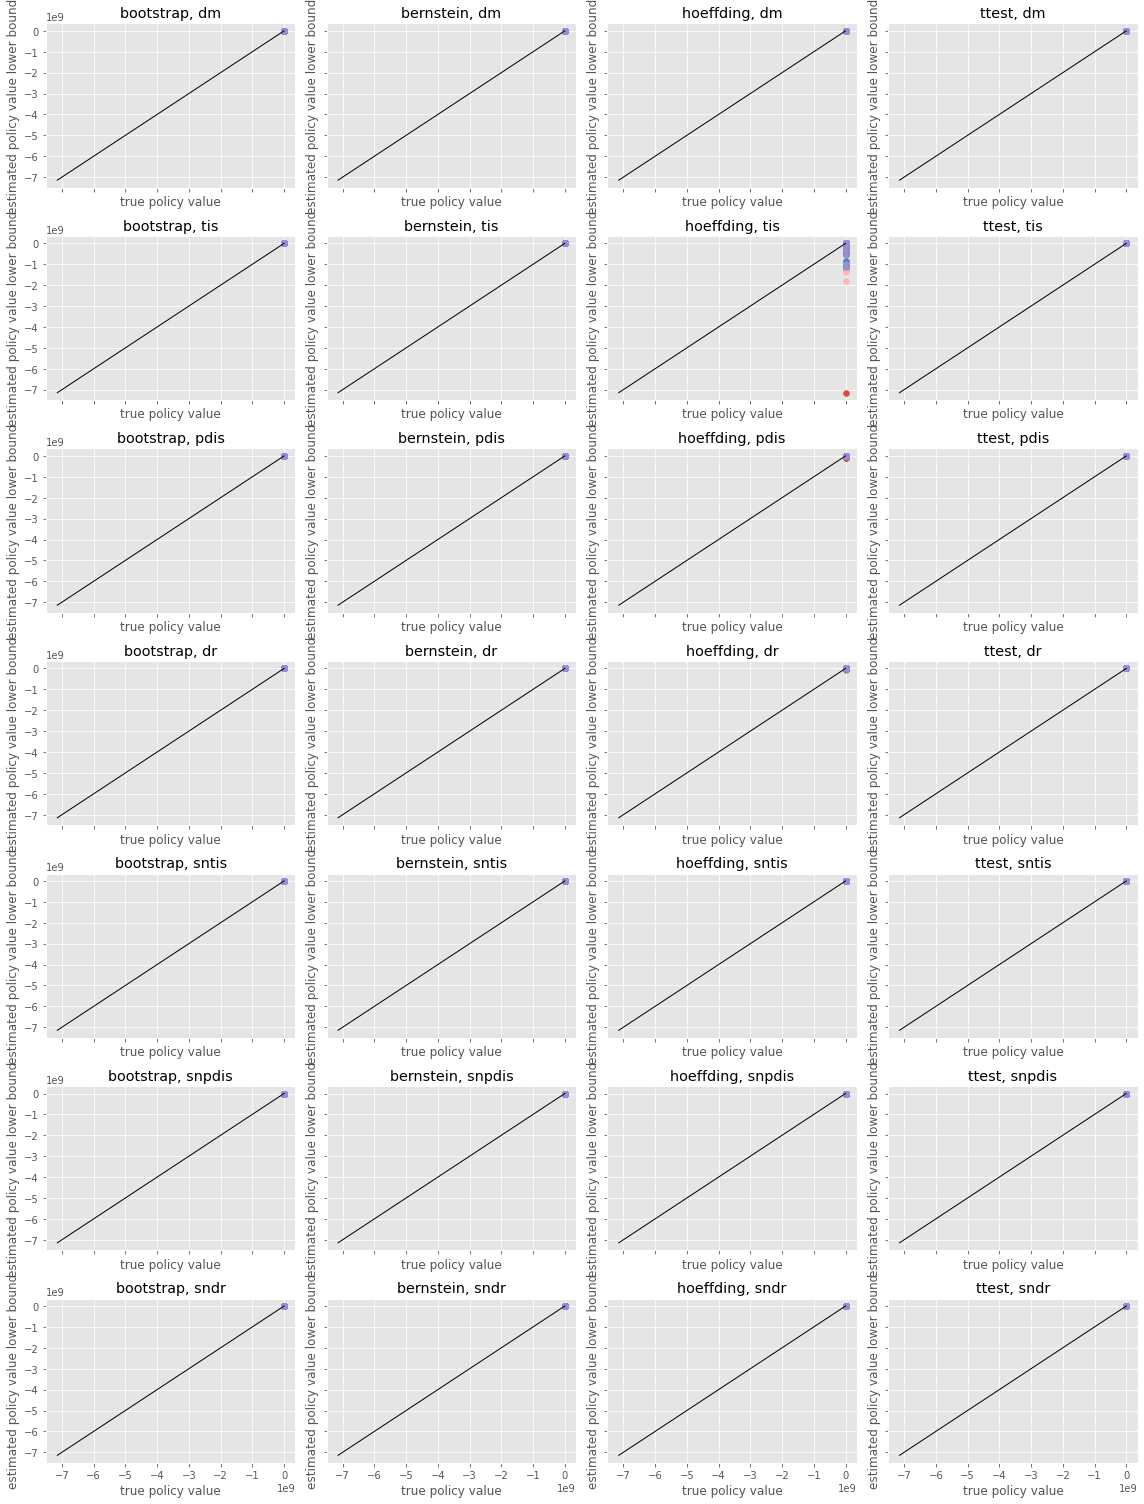

In [55]:
ops.visualize_policy_value_lower_bound_for_validation(
    input_dict=input_dict,
    cis=["bootstrap", "bernstein", "hoeffding", "ttest"],
    alpha=0.30,
    share_axes=True,
    random_state=12345,
)

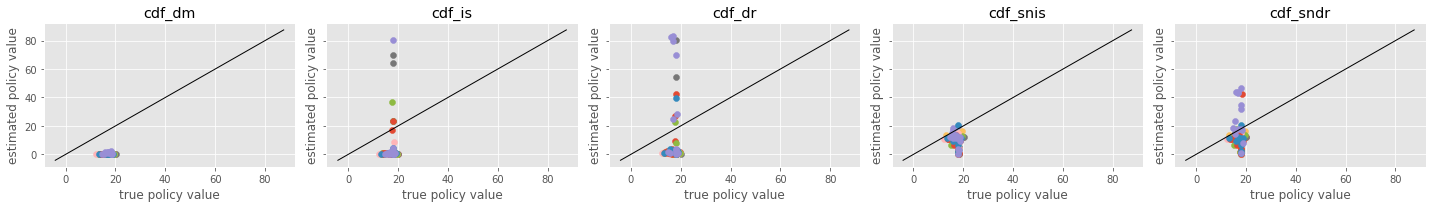

In [56]:
ops.visualize_variance_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

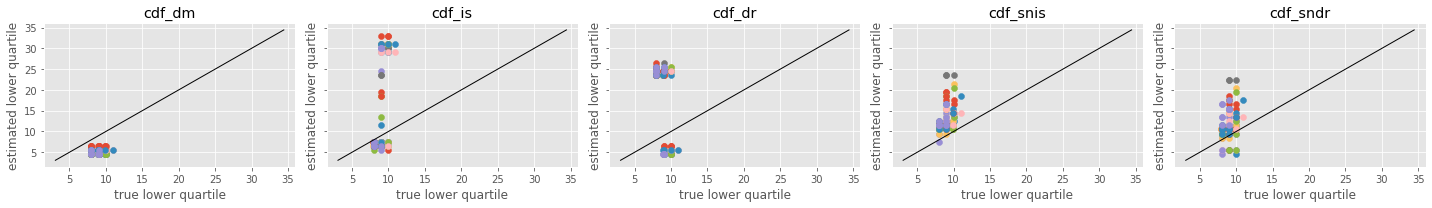

In [57]:
ops.visualize_lower_quartile_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

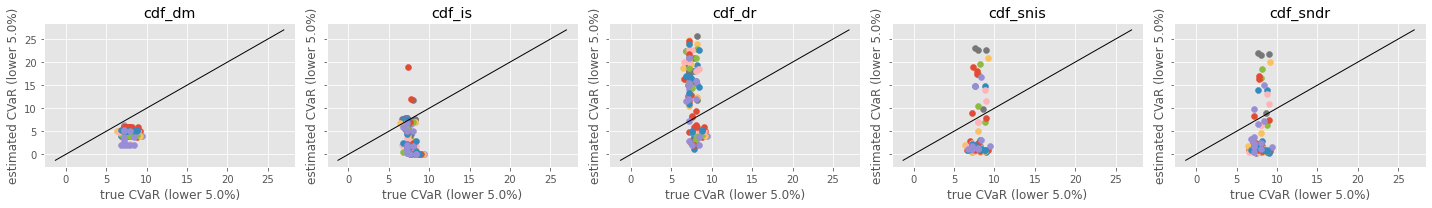

In [58]:
ops.visualize_conditional_value_at_risk_for_validation(
    input_dict=input_dict,
    share_axes=True,
)

For the examples in the discrete action space, please refer to [examples/quickstart/rtb_synthetic_discrete_multiple_datasets.ipynb](https://github.com/negocia-inc/rtb_reinforcement_learing/blob/ope/examples/quickstart/rtb_synthetic_discrete_multiple_datasets.ipynb).

## Reference

- Vladislav Kurenkov and Sergey Kolesnikov. \
"Showing Your Offline Reinforcement Learning Work: Online Evaluation Budget Matters.", 2022.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment for Markov Decision Processes.", 2022.

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Shengpu Tang and Jenna Wiens. \
"Model Selection for Offline Reinforcement Learning: Practical Considerations for Healthcare Settings.", 2021.

- Justin Fu, Mohammad Norouzi, Ofir Nachum, George Tucker, Ziyu Wang, Alexander Novikov, Mengjiao Yang, Michael R. Zhang, Yutian Chen, Aviral Kumar, Cosmin Paduraru, Sergey Levine, and Tom Le Paine. \
"Benchmarks for Deep Off-Policy Evaluation.", 2021.

- Audrey Huang, Liu Leqi, Zachary C. Lipton, and Kamyar Azizzadenesheli. \
"Off-Policy Risk Assessment in Contextual Bandits.", 2021.

- Yash Chandak, Scott Niekum, Bruno Castro da Silva, Erik Learned-Miller, Emma Brunskill, and Philip S. Thomas. \
"Universal Off-Policy Evaluation.", 2021.

- Sergey Levine, Aviral Kumar, George Tucker, and Justin Fu. \
"Offline Reinforcement Learning: Tutorial, Review, and Perspectives on Open Problems." 2020.

- Tom Le Paine, Cosmin Paduraru, Andrea Michi, Caglar Gulcehre, Konrad Zolna, Alexander Novikov, Ziyu Wang, and Nando de Freitas. \
"Hyperparameter Selection for Offline Reinforcement Learning.", 2020.

- Aviral Kumar, Aurick Zhou, George Tucker, and Sergey Levine. \
"Conservative Q-Learning for Offline Reinforcement Learning.", 2020.

- Nathan Kallus and Masatoshi Uehara. \
"Intrinsically Efficient, Stable, and Bounded Off-Policy Evaluation for Reinforcement Learning.", 2019.

- Hoang Le, Cameron Voloshin, and Yisong Yue. \
"Batch Policy Learning under Constraints.", 2019.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Josiah P. Hanna, Peter Stone, and Scott Niekum. \
"Bootstrapping with Models: Confidence Intervals for Off-Policy Evaluation.", 2017.

- Nan Jiang and Lihong Li. \
"Doubly Robust Off-policy Value Evaluation for Reinforcement Learning.", 2016.

- Philip S. Thomas and Emma Brunskill. \
"Data-Efficient Off-Policy Policy Evaluation for Reinforcement Learning.", 2016.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Policy Improvement.", 2015.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Off-Policy Evaluation.", 2015.

- Adith Swaminathan and Thorsten Joachims. \
"The Self-Normalized Estimator for Counterfactual Learning.", 2015.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.

- Miroslav Dudík, Dumitru Erhan, John Langford, and Lihong Li. \
"Doubly Robust Policy Evaluation and Optimization.", 2014.

- Alex Strehl, John Langford, Sham Kakade, and Lihong Li. \
"Learning from Logged Implicit Exploration Data.", 2010.

- Alina Beygelzimer and John Langford. \
"The Offset Tree for Learning with Partial Labels.", 2009.

- Doina Precup, Richard S. Sutton, and Satinder P. Singh. \
"Eligibility Traces for Off-Policy Policy Evaluation.", 2000.